# [Title]
This is a single notebook to reproduce the results in the final version of the NIPS paper [Deep, complex, invertible networks for inversion of transmission effects in multimode optical fibres]. It takes roughly x hours to run in its entirety on an NVIDIA Titan X GPU but can also be run as standalone sections, provided the setup section has been run [and the right data]...

## Setup

In [38]:
%%time 
# Change to appropriate pat
my_path = '/media/extremebeast/D21036D21036BD73/Dropbox_Ubuntu/Dropbox/fibre imaging NN/NIPS_data/'


import os
import gc

from matplotlib import pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.linewidth'] = 0

import numpy as np
import pickle
import h5py
import cv2
import tensorflow as tf
from keras.layers import Input, Reshape, Dense,AveragePooling2D, UpSampling2D, Conv2D, Flatten, PReLU, Lambda, Conv1D
from keras.models import Model
from keras.initializers import RandomUniform
from keras.engine.topology import Layer
from keras.constraints import *
from keras.optimizers import SGD
from keras.callbacks import *
#from keras_contrib.losses.dssim import DSSIMObjective

from ComplexNets import *

import subprocess
import imageio
from IPython.display import HTML

def axes_off():
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)
    
new_folders = ['figures', 'gifs', 'logs', 'models', 'tables', 'triptychs', 'weights']
for new_folder in new_folders:
    if not os.path.isdir(new_folder): 
        os.makedirs(new_folder)

CPU times: user 313 µs, sys: 56 µs, total: 369 µs
Wall time: 345 µs


## Figure 1 - Single pixel responses


CPU times: user 2.85 s, sys: 1.33 s, total: 4.17 s
Wall time: 2.33 s


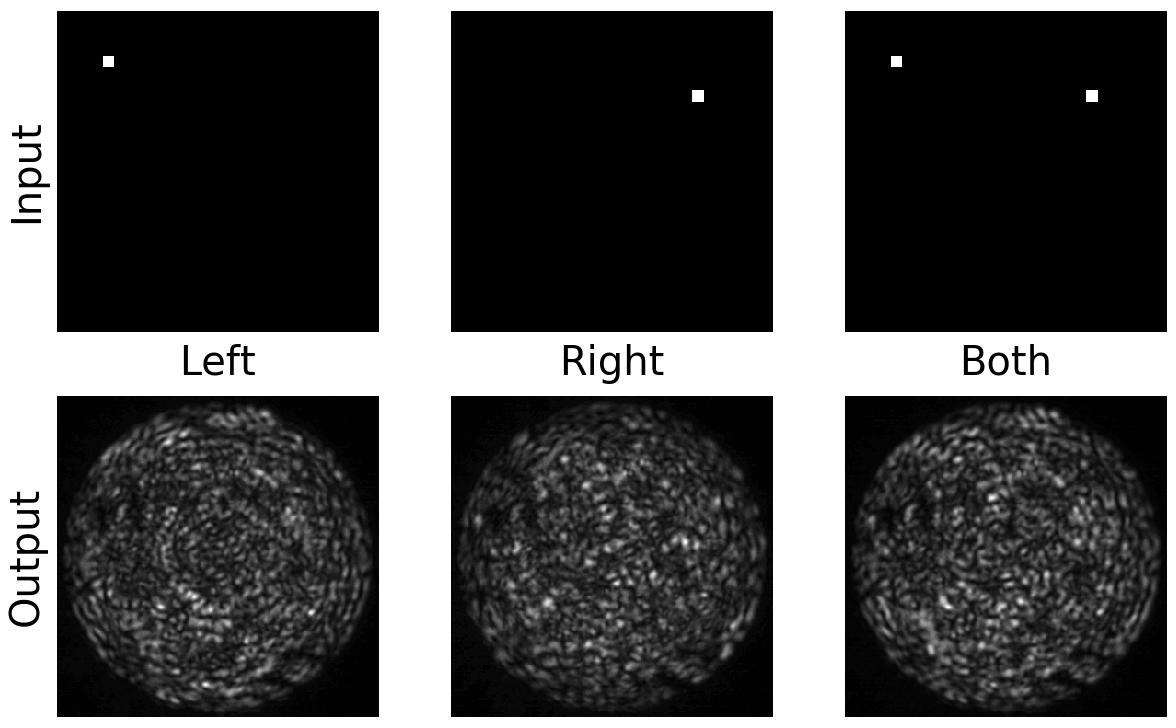

In [5]:
%%time

file_location = 'Figure_1.pkl'
f = open(my_path + file_location,'rb')
figure = pickle.load(f)        
f.close()

dx_in = figure['Input']['Right'].astype('float32')
sx_in = figure['Input']['Left'].astype('float32')
bo_in = figure['Input']['Both'].astype('float32')

dx = figure['Output']['Right'].astype('float32')
sx = figure['Output']['Left'].astype('float32')
bo = figure['Output']['Both'].astype('float32')

rows, cols = 2, 3
x_size, y_size = 40, 40
x_pad, y_pad = 12, 10

def add_to_plot(img, rows, cols, idx, 
                x_label=None, y_label=None, x_size=None, y_size=None, x_pad=None, y_pad=None,):
    plt.subplot(rows, cols, idx)
    plt.imshow(img)
    if x_label: plt.xlabel(x_label, size = x_size, labelpad = x_pad)
    if y_label: plt.ylabel(y_label, size = y_size, labelpad = y_pad)
    plt.xticks([]); plt.yticks([])
    
# Set subplot size
f, ax_arr = plt.subplots(rows, cols, figsize=(20, 13))

# LEFT
add_to_plot(sx_in, rows, cols, 1, 
            x_label='Left', y_label='Input', x_size=x_size, y_size=y_size, x_pad=x_pad, y_pad=y_pad)
add_to_plot(sx, rows, cols, 4, y_label='Output', y_size=y_size, y_pad=y_pad)
# RIGHT
add_to_plot(dx_in, rows, cols, 2, x_label='Right', x_size=x_size, x_pad=x_pad)
add_to_plot(dx, rows, cols, 5)
# BOTH
add_to_plot(bo_in, rows, cols, 3, x_label='Both', x_size=x_size, x_pad=x_pad)
add_to_plot(bo, rows, cols, 6)

f.savefig(f'figures/single_pixel_responses.png', bbox_inches='tight')
K.clear_session()

## Figure 3 - Example of training input & outputs

AttributeError: '_io.BufferedReader' object has no attribute 'savefig'

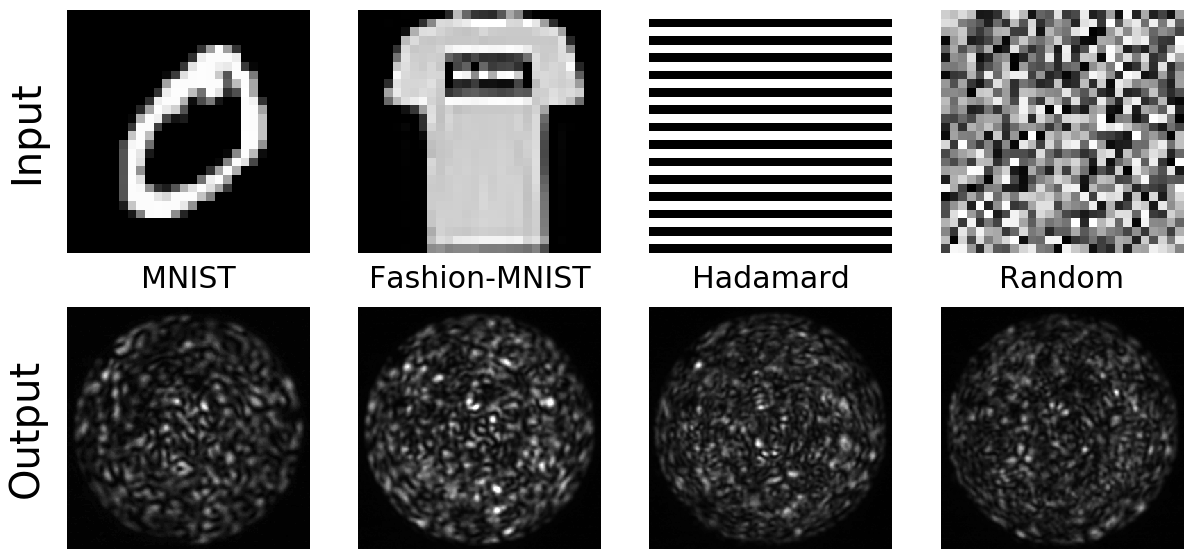

In [6]:
%%time
# Example number
ex = 1

file_location = 'Figure_3.pkl'
f = open(my_path + file_location,'rb')
figure = pickle.load(f)        
f.close()


mnist_in = figure['Input']['MNIST'].astype('float32')
fashion_in = figure['Input']['Fashion-MNIST'].astype('float32')
hadamard_in = figure['Input']['Hadamard'].astype('float32')
random_in = figure['Input']['Random'].astype('float32')

mnist = figure['Output']['MNIST'].astype('float32')
fashion = figure['Output']['Fashion-MNIST'].astype('float32')
hadamard = figure['Output']['Hadamard'].astype('float32')
random = figure['Output']['Random'].astype('float32')


rows, cols = 2, 4
x_size, y_size = 30, 40
x_pad, y_pad = 12, 20

# Set subplot size
f1, ax_arr1 = plt.subplots(rows, cols, figsize=(20, 10))


def add_to_plot(img, rows, cols, idx, 
                x_label=None, y_label=None, x_size=None, y_size=None, x_pad=None, y_pad=None,):
    plt.subplot(rows, cols, idx)
    plt.imshow(img)
    if x_label: plt.xlabel(x_label, size = x_size, labelpad = x_pad)
    if y_label: plt.ylabel(y_label, size = y_size, labelpad = y_pad)
    plt.xticks([]); plt.yticks([])

    
# MNIST
add_to_plot(mnist_in, rows, cols, 1, 
            x_label='MNIST', y_label='Input', x_size=x_size, y_size=y_size, x_pad=x_pad, y_pad=y_pad)
add_to_plot(mnist, rows, cols, 5, y_label='Output', y_size=y_size, y_pad=y_pad)
# Fashion-MNIST
add_to_plot(fashion_in, rows, cols, 2, x_label='Fashion-MNIST', x_size=x_size, x_pad=x_pad)
add_to_plot(fashion, rows, cols, 6)
# Hadamard
add_to_plot(hadamard_in, rows, cols, 3, x_label='Hadamard', x_size=x_size, x_pad=x_pad)
add_to_plot(hadamard, rows, cols, 7)
# Random
add_to_plot(random_in, rows, cols, 4, x_label='Random', x_size=x_size, x_pad=x_pad)
add_to_plot(random, rows, cols, 8)

f.savefig(f'figures/input_output_examples.png', bbox_inches='tight')
K.clear_session()

## Table 1 & Figure 5 - Comparison of various models, Impact of regularisation methods
### Hyperparameters

In [2]:
lamb = 1.0
epochs = 850
lr = 1e-5
batch_size = 64

### Load data

Loading digi ...
Loading fash ...
Loading rand ...
Loading fash_test ...
Loading digi_test ...
Loading punc ...


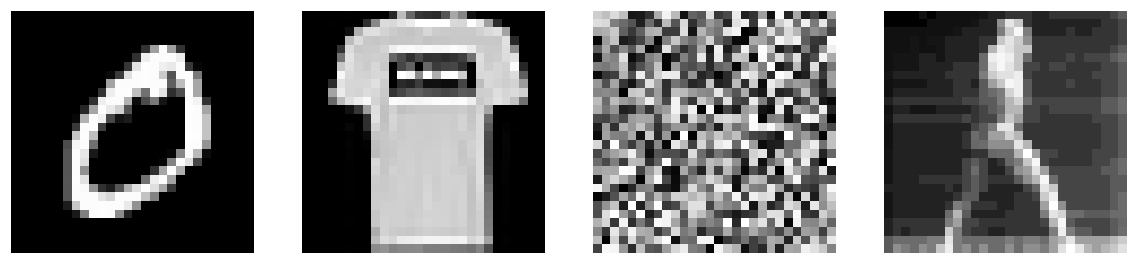

In [3]:
out_dim = 28
speckle_dim = 112 #56
image_dim = speckle_dim
Use_root    = False
phase_shift = False


file_location = 'Data_1m.h5'
hf = h5py.File( my_path + file_location , 'r')



# Original/input image filenames
orig_img_filenames =  {'digi': 'Training/Original_images/MNIST',
                      'fash': 'Training/Original_images/Fashion-MNIST',
                      'rand': 'Training/Original_images/Random Patterns',
                 'fash_test': 'Testing/Original_images/MNIST',
                 'digi_test': 'Testing/Original_images/Fashion-MNIST',
                      'punc': 'Testing/Original_images/Muybridge Punch'}

orig_imgs = {dataset: None for dataset in orig_img_filenames}


for dataset, filename in orig_img_filenames.items():
    # Load
    fl = hf[filename]
    orig_imgs[dataset] =  np.array(fl)


## TRAIN
y_train = np.concatenate((orig_imgs['digi'],
                          orig_imgs['fash'],
                          orig_imgs['rand'],
                         ))

y_train = np.squeeze(y_train.reshape(-1, 28*28, 1))

## TEST
y_test = np.concatenate((orig_imgs['digi_test'],
                         orig_imgs['fash_test'],))

y_test = np.squeeze(y_test.reshape(-1, 28*28, 1))


## Example of each dataset
rows, cols = 1, len(orig_img_filenames)-2 # exclude test sets
f, ax_arr = plt.subplots(rows, cols, figsize=(20, 10))
ex = 1

i = 1
for name in (name for name in orig_img_filenames if 'test' not in name):
    plt.subplot(rows, cols, i)
    plt.imshow(orig_imgs[name][ex].reshape(28,28))
    axes_off()
    i+=1




# Load and resize all datasets

# Original/input image filenames
speckle_img_filenames =  {'digi': 'Training/Speckle_images/MNIST',
                      'fash': 'Training/Speckle_images/Fashion-MNIST',
                      'rand': 'Training/Speckle_images/Random Patterns',
                 'fash_test': 'Testing/Speckle_images/MNIST',
                 'digi_test': 'Testing/Speckle_images/Fashion-MNIST',
                      'punc': 'Testing/Speckle_images/Muybridge Punch'}

data_dict = {dataset: None for dataset in speckle_img_filenames}


# import speckle images and resize them from 224 to the chosen speckle_dim
for dataset, filename in speckle_img_filenames.items():
    print(f"Loading {dataset} ...")
    # Load
    fl = hf[filename]
    data_dict[dataset] =  np.array(fl)
    # To resize we recover the original image shape
    Data_resize = np.reshape(data_dict[dataset], (data_dict[dataset].shape[0],224,224) )
    Data_temp = np.zeros((data_dict[dataset].shape[0],speckle_dim*speckle_dim))
    # Resize
    for im in range(data_dict[dataset].shape[0]):

        Data_temp[im] = np.reshape(cv2.resize(Data_resize[im], dsize=(speckle_dim, speckle_dim), interpolation=cv2.INTER_AREA), (speckle_dim*speckle_dim))
    
    data_dict[dataset] = Data_temp            
    del Data_temp, Data_resize
    gc.collect()




#TRAIN
x_train = np.concatenate((data_dict['digi'],
                          data_dict['fash'],
                          data_dict['rand'],
                         ))
# TEST
x_test = np.concatenate((data_dict['digi_test'], data_dict['fash_test'],))


x_train_ch = real_to_channels_np(x_train.astype('float32'))
x_test_ch  = real_to_channels_np(x_test.astype('float32'))



hf.close()

### Apply the nonlinear transformation that the SLM induces on amplitude and phase.


In [4]:
from scipy import interpolate
experimentalAmp   = np.load(my_path + 'amplitude.npy')
experimentalPhase = np.load(my_path + 'phase.npy')
experimentalPhase = np.append(experimentalPhase, experimentalPhase[-2] ) # add in missing datapoint

x1 = np.arange(0.0,101.0)/100.0
x2 = np.arange(0.0,101.0)/100.0
print(len(experimentalPhase), len(x2))
testx = np.arange(0.0,100.0,0.5)/100.0
fSLMamp = interpolate.interp1d(x1, experimentalAmp/np.max(experimentalAmp))
fSLMphase = interpolate.interp1d(x2, experimentalPhase)


print(np.min(y_train), np.max(y_train))
y_train_phase = fSLMphase(y_train)*255.0
y_test_phase  = fSLMphase(y_test)*255.0
y_train       = fSLMamp(y_train)*255.0
y_test        = fSLMamp(y_test)*255.0
print(np.min(y_train), np.max(y_train))


101 101
0.0 1.0
3.113248752079867 255.0


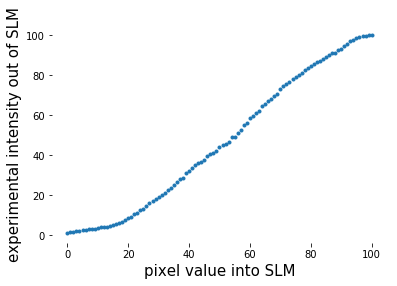

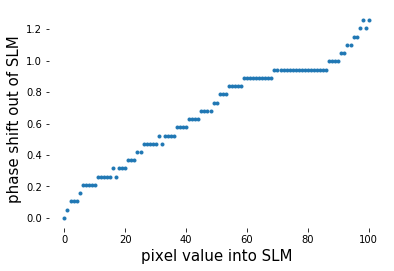

In [5]:
import math
plt.figure()
plt.plot(100.0*experimentalAmp/np.max(experimentalAmp),'.')
#plt.plot(testx, fSLMamp(testx),'-k')
plt.xlabel('pixel value into SLM',fontsize=15)
plt.ylabel('experimental intensity out of SLM',fontsize=15)
plt.savefig(f'figures/phaseSLM.png', bbox_inches='tight')
plt.figure()
plt.plot(experimentalPhase*math.pi,'.')
#plt.plot(testx, fSLMphase(testx),'-k')
plt.ylabel('phase shift out of SLM',fontsize=15)
plt.xlabel('pixel value into SLM',fontsize=15)
plt.savefig(f'figures/ampSLM.png', bbox_inches='tight')


In [6]:
class Hadamard2(Layer):
    # creates a custom layer for elementwise multiplying every element of a vector by another weight vector
    # assumes input is complex in separate real and imaginary channels
    def __init__(self, kernel_constraint=None, **kwargs):
        super(Hadamard2, self).__init__(**kwargs)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
 
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(1,input_shape[1]),
                                      initializer=keras.initializers.Constant(value=1.0),
                                      constraint=self.kernel_constraint,
                                      trainable=True)
        super(Hadamard2, self).build(input_shape)  # Be sure to call this somewhere!
 
    def call(self, x):
        if tf.keras.backend.ndim(x) == 3:
            return complex_to_channels(channels_to_complex(x) * 
                                       tf.complex(self.kernel, 0*self.kernel))
        else:
            return x*self.kernel
        
    def get_config(self):
        config = {
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint)
        }
        base_config = super(Hadamard2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
 
    def compute_output_shape(self, input_shape):
        return input_shape


### Single Layer - Real, No Regularisation
This and other real models have effectively half the parameters (TODO: try fairer comparison)

In [7]:
inp_1 = Input(shape=(image_dim*image_dim, 2))
lay_1 = Amplitude()(inp_1)
lay_1 = Reshape((image_dim*image_dim,))(lay_1)
out_1 = Dense(28*28, use_bias=False)(lay_1)
# learn the amplitude attenuation function
out_1 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(out_1)
mod_1 = Model(inputs=inp_1, outputs=[out_1])

mod_1.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])
mod_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12544, 2)          0         
_________________________________________________________________
amplitude_1 (Amplitude)      (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               9834496   
_________________________________________________________________
hadamard2_1 (Hadamard2)      (None, 784)               784       
Total params: 9,835,280
Trainable params: 9,835,280
Non-trainable params: 0
_________________________________________________________________


### Single Layer - Real, L2 Weight Regularisation

In [8]:
lamb = 0.03

inp_2 = Input(shape=(image_dim*image_dim, 2))
lay_2 = Amplitude()(inp_2)
lay_2 = Reshape((image_dim*image_dim,))(lay_2)
out_2 = Dense(28*28, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(lay_2)
# learn the amplitude attenuation function
out_2 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(out_2)
mod_2 = Model(inputs=inp_2, outputs=[out_2])

mod_2.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])
mod_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 12544, 2)          0         
_________________________________________________________________
amplitude_2 (Amplitude)      (None, 12544)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               9834496   
_________________________________________________________________
hadamard2_2 (Hadamard2)      (None, 784)               784       
Total params: 9,835,280
Trainable params: 9,835,280
Non-trainable params: 0
_________________________________________________________________


### Single Layer - Complex, No Regularisation

In [9]:
inp_3 = Input(shape=(image_dim*image_dim, 2))
lay_3 = ComplexDense(28*28, use_bias=False)(inp_3)
# learn the amplitude attenuation function
out_3 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_3)
out_3 = Amplitude()(out_3)
mod_3 = Model(inputs=inp_3, outputs=[out_3])

mod_3.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])
mod_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 12544, 2)          0         
_________________________________________________________________
complex_dense_1 (ComplexDens (None, 784, 2)            19668992  
_________________________________________________________________
hadamard2_3 (Hadamard2)      (None, 784, 2)            784       
_________________________________________________________________
amplitude_3 (Amplitude)      (None, 784)               0         
Total params: 19,669,776
Trainable params: 19,669,776
Non-trainable params: 0
_________________________________________________________________


### Single Layer - Complex, L2 Weight Regularisation

In [10]:
inp_4 = Input(shape=(image_dim*image_dim, 2))
lay_4 = ComplexDense(28*28, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(inp_4)
had_4 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_4)
out_4 = Amplitude()(had_4)
#out_ph4 = Phase()(had_4)
mod_4 = Model(inputs=inp_4, outputs=out_4)#, out_ph4])

mod_4.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse'])
mod_4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 12544, 2)          0         
_________________________________________________________________
complex_dense_2 (ComplexDens (None, 784, 2)            19668992  
_________________________________________________________________
hadamard2_4 (Hadamard2)      (None, 784, 2)            784       
_________________________________________________________________
amplitude_4 (Amplitude)      (None, 784)               0         
Total params: 19,669,776
Trainable params: 19,669,776
Non-trainable params: 0
_________________________________________________________________


### Single Layer - Complex, Semi-Unitary Regularisation

In [11]:
inp_5 = Input(shape=(image_dim*image_dim, 2))
lay_5 = ComplexDense(28*28, use_bias=False, kernel_regularizer=UnitaryReg(lamb))(inp_5)
out_5 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=10.0, 
                                                                     rate=1.0, axis=0))(lay_5)
out_5 = Amplitude()(lay_5)
mod_5 = Model(inputs=inp_5, outputs=[out_5])

mod_5.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])
mod_5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 12544, 2)          0         
_________________________________________________________________
complex_dense_3 (ComplexDens (None, 784, 2)            19668992  
_________________________________________________________________
amplitude_5 (Amplitude)      (None, 784)               0         
Total params: 19,668,992
Trainable params: 19,668,992
Non-trainable params: 0
_________________________________________________________________


In [12]:
#now try UnitaryReg2 (transposed unitary constraint)
inp_52 = Input(shape=(image_dim*image_dim, 2))
lay_5 = ComplexDense(28*28, use_bias=False, 
                     #kernel_initializer=RandomUnitaryNormal(),
                     kernel_regularizer=UnitaryReg2(lamb*10)
                    )(inp_52)
out_5 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=10.0, 
                                                                     rate=1.0, axis=0))(lay_5)
out_52 = Amplitude()(lay_5)
mod_52 = Model(inputs=inp_52, outputs=[out_52])

mod_52.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])
mod_52.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 12544, 2)          0         
_________________________________________________________________
complex_dense_4 (ComplexDens (None, 784, 2)            19668992  
_________________________________________________________________
amplitude_6 (Amplitude)      (None, 784)               0         
Total params: 19,668,992
Trainable params: 19,668,992
Non-trainable params: 0
_________________________________________________________________


### Single Layer - Complex, Square Unitary Regularisation

In [41]:
T_dim = int(speckle_dim/2)

inp_5s    = Input(shape=(image_dim*image_dim, 2))
reshape_1 = Reshape((speckle_dim,speckle_dim,2))(inp_5s)
pool_1    = AveragePooling2D((2,2))(reshape_1)
reshape_2 = Reshape((T_dim**2,2))(pool_1)
#lay_5 = ComplexDense(T_dim**2, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(reshape_2)

lay_5     = ComplexDense(T_dim**2, use_bias=False,
                         kernel_initializer=RandomUnitaryNormal(),
                         kernel_regularizer=UnitaryReg(lamb*10))(reshape_2)
reshape_3 = Reshape((T_dim,T_dim,2))(lay_5)
out_5s    = AveragePooling2D((2,2))(reshape_3)
out_5s    = Reshape((out_dim*out_dim,2))(out_5s)
#out_5s = AveragePooling2D((2,2))(out_5s)
out_5s    = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=10.0, 
                                                                     rate=10.0, axis=0))(out_5s)
out_5s = Amplitude()(out_5s)
#out_5s = Flatten()(out_5s)
#had_layer = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.00001, max_value=1.0, 
#                                                                         rate=1.0, axis=0))
#out_5s = had_layer(out_5s)


mod_5s = Model(inputs=inp_5s, outputs=[out_5s])

mod_5s.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])
mod_5s.summary()

starting random unitary matrix generation of size %f
 3136
finishing random unitary matrix generation

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 12544, 2)          0         
_________________________________________________________________
reshape_32 (Reshape)         (None, 112, 112, 2)       0         
_________________________________________________________________
average_pooling2d_17 (Averag (None, 56, 56, 2)         0         
_________________________________________________________________
reshape_33 (Reshape)         (None, 3136, 2)           0         
_________________________________________________________________
complex_dense_9 (ComplexDens (None, 3136, 2)           19668992  
_________________________________________________________________
reshape_34 (Reshape)         (None, 56, 56, 2)         0         
_______________________________________

Single, square, non-Unitary regularisation

In [14]:
T_dim = int(speckle_dim/2)

inp_5snu    = Input(shape=(image_dim*image_dim, 2))
reshape_1 = Reshape((speckle_dim,speckle_dim,2))(inp_5snu)
pool_1    = AveragePooling2D((2,2))(reshape_1)
reshape_2 = Reshape((T_dim**2,2))(pool_1)
#lay_5 = ComplexDense(T_dim**2, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(reshape_2)

lay_5     = ComplexDense(T_dim**2, use_bias=False)(reshape_2)
reshape_3 = Reshape((T_dim,T_dim,2))(lay_5)
out_5snu    = AveragePooling2D((2,2))(reshape_3)
out_5snu    = Reshape((out_dim*out_dim,2))(out_5snu)
#out_5s = AveragePooling2D((2,2))(out_5s)
out_5snu    = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=10.0, axis=0))(out_5snu)
out_5snu = Amplitude()(out_5snu)
#out_5s = Flatten()(out_5s)
#had_layer = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.00001, max_value=1.0, 
#                                                                         rate=1.0, axis=0))
#out_5s = had_layer(out_5s)


mod_5snu = Model(inputs=inp_5snu, outputs=[out_5snu])

mod_5snu.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])
mod_5snu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 12544, 2)          0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 112, 112, 2)       0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 56, 56, 2)         0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 3136, 2)           0         
_________________________________________________________________
complex_dense_5 (ComplexDens (None, 3136, 2)           19668992  
_________________________________________________________________
reshape_7 (Reshape)          (None, 56, 56, 2)         0         
_________________________________________________________________
average_pooling2d_3 (Average (None, 28, 28, 2)         0         
__________

### Single Layer - Complex, Multi-res training

In [15]:
inp_6 = Input(shape=(image_dim*image_dim, 2))
lay_6 = ComplexDense(28*28, use_bias=False, kernel_regularizer=UnitaryAndL2Reg(l_u=lamb/10, l_a=lamb/3))(inp_6)
lay_6 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_6)
reshape_1 = Reshape((28,28,2))(lay_6)
pool1 = AveragePooling2D((2,2))(reshape_1)
pool2 = AveragePooling2D((4,4))(reshape_1)
flatten1 = Reshape((14*14,2))(pool1)
flatten2 = Reshape((7*7,2))(pool2)
out1 = Amplitude()(lay_6)
out2 = Amplitude()(flatten1)
out3 = Amplitude()(flatten2)

mod_6 = Model(inputs=inp_6, outputs=[out1, out2, out3])

mod_6.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse'])
mod_6.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 12544, 2)     0                                            
__________________________________________________________________________________________________
complex_dense_6 (ComplexDense)  (None, 784, 2)       19668992    input_9[0][0]                    
__________________________________________________________________________________________________
hadamard2_8 (Hadamard2)         (None, 784, 2)       784         complex_dense_6[0][0]            
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 28, 28, 2)    0           hadamard2_8[0][0]                
__________________________________________________________________________________________________
average_po

In [16]:
inp_6noreg = Input(shape=(image_dim*image_dim, 2))
lay_6 = ComplexDense(28*28, use_bias=False)(inp_6noreg)
lay_6 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_6)
reshape_1 = Reshape((28,28,2))(lay_6)
pool1 = AveragePooling2D((2,2))(reshape_1)
pool2 = AveragePooling2D((4,4))(reshape_1)
flatten1 = Reshape((14*14,2))(pool1)
flatten2 = Reshape((7*7,2))(pool2)
out1_noreg = Amplitude()(lay_6)
out2_noreg = Amplitude()(flatten1)
out3_noreg = Amplitude()(flatten2)

mod_6noreg = Model(inputs=inp_6noreg, outputs=[out1_noreg, out2_noreg, out3_noreg])

mod_6noreg.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse'])
mod_6noreg.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 12544, 2)     0                                            
__________________________________________________________________________________________________
complex_dense_7 (ComplexDense)  (None, 784, 2)       19668992    input_10[0][0]                   
__________________________________________________________________________________________________
hadamard2_9 (Hadamard2)         (None, 784, 2)       784         complex_dense_7[0][0]            
__________________________________________________________________________________________________
reshape_12 (Reshape)            (None, 28, 28, 2)    0           hadamard2_9[0][0]                
__________________________________________________________________________________________________
average_po

In [17]:
inp_6l2 = Input(shape=(image_dim*image_dim, 2))
lay_6 = ComplexDense(28*28, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(inp_6l2)
lay_6 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_6)
reshape_1 = Reshape((28,28,2))(lay_6)
pool1 = AveragePooling2D((2,2))(reshape_1)
pool2 = AveragePooling2D((4,4))(reshape_1)
flatten1 = Reshape((14*14,2))(pool1)
flatten2 = Reshape((7*7,2))(pool2)
out1l2 = Amplitude()(lay_6)
out2l2 = Amplitude()(flatten1)
out3l2 = Amplitude()(flatten2)

mod_6l2 = Model(inputs=inp_6l2, outputs=[out1l2, out2l2, out3l2])

mod_6l2.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse'])
mod_6l2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 12544, 2)     0                                            
__________________________________________________________________________________________________
complex_dense_8 (ComplexDense)  (None, 784, 2)       19668992    input_11[0][0]                   
__________________________________________________________________________________________________
hadamard2_10 (Hadamard2)        (None, 784, 2)       784         complex_dense_8[0][0]            
__________________________________________________________________________________________________
reshape_15 (Reshape)            (None, 28, 28, 2)    0           hadamard2_10[0][0]               
__________________________________________________________________________________________________
average_po

In [18]:
from copy import copy
from matplotlib import colors

def eval_and_display(model, model_name, x_vals, y_vals, square_results=False, out_dim=28, vmax=255.0):
    # Evaluate MSE
    MSE = model.evaluate(x_vals, y_vals, batch_size=1000)[1]
    print(f"MSE for {model_name} = {MSE}\n")
    with open("tables/MSE.txt", "a") as file:
        file.write(f'\\verb+{model_name}+ & {MSE:.4f}  \\\\\n')
    
    pred_test = model.predict(x_vals)
    if type(pred_test) == list:
        pred_test = pred_test[0]
    if square_results:
        pred_test = pred_test ** 2
    
    rows, cols = 4, 4
    f, ax_arr = plt.subplots(rows, cols, figsize=(20, 20))

    i = 1
    offsets = [0, 3000-2*cols]
    
    palette = copy(plt.cm.gray)
    palette.set_over('r', 1.0)
    palette.set_under('g', 1.0)
    palette.set_bad('b', 1.0)

    for row in range(1,rows+1,2):
        for col in range(cols):
            i = (row-1)*cols + (col+1)
            offset = offsets[(row-1)//2]
            if row>1 and col>2: offset+=4

            plt.subplot(rows,cols,i)
            if type(y_vals) == list:
                this_image = y_vals[0][offset+i-1].reshape(out_dim,out_dim)
            else:
                this_image = y_vals[offset+i-1].reshape(out_dim,out_dim)        
            plt.imshow(this_image,
                      norm=colors.Normalize(vmin=0.0, vmax=vmax, clip=False))
            axes_off()

            plt.subplot(rows,cols,i+cols)
            plt.imshow(pred_test[offset+i-1].reshape(out_dim,out_dim),
                      norm=colors.Normalize(vmin=0.0, vmax=vmax, clip=False))
            axes_off()

    f.savefig(f'figures/model_comparison_{model_name}.png', bbox_inches='tight')
    
def energy(x):
    e = np.linalg.norm(x,axis=1)
    return e

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=lr/1e3,
                              verbose=1,)

early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=10)

In [19]:
# Start of table
LaTeX_table =  ("\\begin{table}\n"
                "\\caption{Model comparisons where each single layer model with approximately "
                f"{int(round(mod_2.count_params()/1_000_000))} million parameters was trained for "
                f"${epochs}$ epochs, on a speckle resolution of "
                f"${image_dim}\\times{image_dim}$, and with "
                f"$\\lambda={lamb}$ where the model was regularised.}}"
                "\\label{tab:models}\n"
                "\\centering\n"
                "\\begin{tabular}{ll}\n"
                "\\toprule\n"
                "\\multicolumn{1}{c}{Model}\\\\\n"
                "\\cmidrule(r){1-1}\n"
                "Name & MSE \\\\ \n\\midrule\n")
with open("tables/MSE.txt", "w") as file:
        file.write(LaTeX_table)

Train on 44000 samples, validate on 6000 samples
Epoch 1/850
44000/44000 [==============================] - 436s 10ms/step - loss: 9533.7073 - amplitude_8_loss: 5133.4257 - amplitude_9_loss: 2067.2870 - amplitude_10_loss: 2208.5014 - amplitude_8_mean_squared_error: 5133.4257 - amplitude_9_mean_squared_error: 2067.2870 - amplitude_10_mean_squared_error: 2208.5014 - val_loss: 6083.2182 - val_amplitude_8_loss: 2546.5761 - val_amplitude_9_loss: 1562.9437 - val_amplitude_10_loss: 1802.8956 - val_amplitude_8_mean_squared_error: 2546.5761 - val_amplitude_9_mean_squared_error: 1562.9437 - val_amplitude_10_mean_squared_error: 1802.8956
Epoch 2/850
44000/44000 [==============================] - 328s 7ms/step - loss: 7807.1560 - amplitude_8_loss: 4465.6533 - amplitude_9_loss: 1500.8948 - amplitude_10_loss: 1644.1652 - amplitude_8_mean_squared_error: 4465.6533 - amplitude_9_mean_squared_error: 1500.8948 - amplitude_10_mean_squared_error: 1644.1652 - val_loss: 5076.8943 - val_amplitude_8_loss: 2151

Epoch 15/850
44000/44000 [==============================] - 329s 7ms/step - loss: 5800.2456 - amplitude_8_loss: 3328.6324 - amplitude_9_loss: 896.5216 - amplitude_10_loss: 1132.6143 - amplitude_8_mean_squared_error: 3328.6324 - amplitude_9_mean_squared_error: 896.5216 - amplitude_10_mean_squared_error: 1132.6143 - val_loss: 3537.4829 - val_amplitude_8_loss: 1400.7658 - val_amplitude_9_loss: 701.8806 - val_amplitude_10_loss: 987.5521 - val_amplitude_8_mean_squared_error: 1400.7658 - val_amplitude_9_mean_squared_error: 701.8806 - val_amplitude_10_mean_squared_error: 987.5521
Epoch 16/850
44000/44000 [==============================] - 329s 7ms/step - loss: 5751.8114 - amplitude_8_loss: 3291.3467 - amplitude_9_loss: 884.0101 - amplitude_10_loss: 1124.2194 - amplitude_8_mean_squared_error: 3291.3467 - amplitude_9_mean_squared_error: 884.0101 - amplitude_10_mean_squared_error: 1124.2194 - val_loss: 3521.8942 - val_amplitude_8_loss: 1388.8249 - val_amplitude_9_loss: 695.6129 - val_amplitude_1

44000/44000 [==============================] - 330s 7ms/step - loss: 5348.8381 - amplitude_8_loss: 2951.6020 - amplitude_9_loss: 785.9991 - amplitude_10_loss: 1061.1009 - amplitude_8_mean_squared_error: 2951.6020 - amplitude_9_mean_squared_error: 785.9991 - amplitude_10_mean_squared_error: 1061.1009 - val_loss: 3403.0799 - val_amplitude_8_loss: 1285.0150 - val_amplitude_9_loss: 637.1485 - val_amplitude_10_loss: 927.8026 - val_amplitude_8_mean_squared_error: 1285.0150 - val_amplitude_9_mean_squared_error: 637.1485 - val_amplitude_10_mean_squared_error: 927.8026
Epoch 30/850
44000/44000 [==============================] - 330s 7ms/step - loss: 5328.2674 - amplitude_8_loss: 2932.8237 - amplitude_9_loss: 781.2674 - amplitude_10_loss: 1058.0932 - amplitude_8_mean_squared_error: 2932.8237 - amplitude_9_mean_squared_error: 781.2674 - amplitude_10_mean_squared_error: 1058.0932 - val_loss: 3403.7638 - val_amplitude_8_loss: 1283.5437 - val_amplitude_9_loss: 637.4631 - val_amplitude_10_loss: 923.7

44000/44000 [==============================] - 330s 7ms/step - loss: 5134.1838 - amplitude_8_loss: 2741.8517 - amplitude_9_loss: 737.0436 - amplitude_10_loss: 1031.4085 - amplitude_8_mean_squared_error: 2741.8517 - amplitude_9_mean_squared_error: 737.0436 - amplitude_10_mean_squared_error: 1031.4085 - val_loss: 3394.5547 - val_amplitude_8_loss: 1245.4633 - val_amplitude_9_loss: 612.6032 - val_amplitude_10_loss: 910.4696 - val_amplitude_8_mean_squared_error: 1245.4633 - val_amplitude_9_mean_squared_error: 612.6032 - val_amplitude_10_mean_squared_error: 910.4696
Epoch 44/850
44000/44000 [==============================] - 329s 7ms/step - loss: 5123.5701 - amplitude_8_loss: 2730.4572 - amplitude_9_loss: 734.6545 - amplitude_10_loss: 1030.2251 - amplitude_8_mean_squared_error: 2730.4572 - amplitude_9_mean_squared_error: 734.6545 - amplitude_10_mean_squared_error: 1030.2251 - val_loss: 3381.1161 - val_amplitude_8_loss: 1240.2601 - val_amplitude_9_loss: 608.7590 - val_amplitude_10_loss: 901.4

44000/44000 [==============================] - 329s 7ms/step - loss: 5010.6176 - amplitude_8_loss: 2607.2980 - amplitude_9_loss: 709.0694 - amplitude_10_loss: 1014.7395 - amplitude_8_mean_squared_error: 2607.2980 - amplitude_9_mean_squared_error: 709.0694 - amplitude_10_mean_squared_error: 1014.7395 - val_loss: 3395.8365 - val_amplitude_8_loss: 1222.8111 - val_amplitude_9_loss: 596.6217 - val_amplitude_10_loss: 894.9599 - val_amplitude_8_mean_squared_error: 1222.8111 - val_amplitude_9_mean_squared_error: 596.6217 - val_amplitude_10_mean_squared_error: 894.9599
Epoch 58/850
44000/44000 [==============================] - 329s 7ms/step - loss: 5003.7343 - amplitude_8_loss: 2599.4173 - amplitude_9_loss: 707.4903 - amplitude_10_loss: 1013.6921 - amplitude_8_mean_squared_error: 2599.4173 - amplitude_9_mean_squared_error: 707.4903 - amplitude_10_mean_squared_error: 1013.6921 - val_loss: 3402.0105 - val_amplitude_8_loss: 1223.0030 - val_amplitude_9_loss: 598.0240 - val_amplitude_10_loss: 896.2

44000/44000 [==============================] - 340s 8ms/step - loss: 4931.8512 - amplitude_8_loss: 2514.2156 - amplitude_9_loss: 690.8994 - amplitude_10_loss: 1003.4118 - amplitude_8_mean_squared_error: 2514.2156 - amplitude_9_mean_squared_error: 690.8994 - amplitude_10_mean_squared_error: 1003.4118 - val_loss: 3409.8469 - val_amplitude_8_loss: 1212.8685 - val_amplitude_9_loss: 588.8376 - val_amplitude_10_loss: 883.3324 - val_amplitude_8_mean_squared_error: 1212.8685 - val_amplitude_9_mean_squared_error: 588.8376 - val_amplitude_10_mean_squared_error: 883.3324
Epoch 72/850
44000/44000 [==============================] - 341s 8ms/step - loss: 4927.1184 - amplitude_8_loss: 2508.6536 - amplitude_9_loss: 689.8243 - amplitude_10_loss: 1002.5418 - amplitude_8_mean_squared_error: 2508.6536 - amplitude_9_mean_squared_error: 689.8243 - amplitude_10_mean_squared_error: 1002.5418 - val_loss: 3417.3692 - val_amplitude_8_loss: 1216.3023 - val_amplitude_9_loss: 591.2270 - val_amplitude_10_loss: 882.1

44000/44000 [==============================] - 334s 8ms/step - loss: 4878.3791 - amplitude_8_loss: 2446.7778 - amplitude_9_loss: 678.2294 - amplitude_10_loss: 994.9566 - amplitude_8_mean_squared_error: 2446.7778 - amplitude_9_mean_squared_error: 678.2294 - amplitude_10_mean_squared_error: 994.9566 - val_loss: 3429.6495 - val_amplitude_8_loss: 1211.1330 - val_amplitude_9_loss: 587.7021 - val_amplitude_10_loss: 871.2943 - val_amplitude_8_mean_squared_error: 1211.1330 - val_amplitude_9_mean_squared_error: 587.7021 - val_amplitude_10_mean_squared_error: 871.2943
Epoch 86/850
44000/44000 [==============================] - 334s 8ms/step - loss: 4875.3287 - amplitude_8_loss: 2442.7681 - amplitude_9_loss: 677.5043 - amplitude_10_loss: 994.4831 - amplitude_8_mean_squared_error: 2442.7681 - amplitude_9_mean_squared_error: 677.5043 - amplitude_10_mean_squared_error: 994.4831 - val_loss: 3436.3340 - val_amplitude_8_loss: 1208.1662 - val_amplitude_9_loss: 585.5231 - val_amplitude_10_loss: 880.9381 

44000/44000 [==============================] - 331s 8ms/step - loss: 4840.2401 - amplitude_8_loss: 2396.2540 - amplitude_9_loss: 668.8479 - amplitude_10_loss: 988.4533 - amplitude_8_mean_squared_error: 2396.2540 - amplitude_9_mean_squared_error: 668.8479 - amplitude_10_mean_squared_error: 988.4533 - val_loss: 3437.1159 - val_amplitude_8_loss: 1200.2390 - val_amplitude_9_loss: 578.0554 - val_amplitude_10_loss: 871.3935 - val_amplitude_8_mean_squared_error: 1200.2390 - val_amplitude_9_mean_squared_error: 578.0554 - val_amplitude_10_mean_squared_error: 871.3935
Epoch 100/850
44000/44000 [==============================] - 331s 8ms/step - loss: 4837.8611 - amplitude_8_loss: 2393.1339 - amplitude_9_loss: 668.2566 - amplitude_10_loss: 988.1221 - amplitude_8_mean_squared_error: 2393.1339 - amplitude_9_mean_squared_error: 668.2566 - amplitude_10_mean_squared_error: 988.1221 - val_loss: 3438.8998 - val_amplitude_8_loss: 1198.1417 - val_amplitude_9_loss: 576.5364 - val_amplitude_10_loss: 875.0024

44000/44000 [==============================] - 330s 8ms/step - loss: 4811.4151 - amplitude_8_loss: 2357.1843 - amplitude_9_loss: 661.5577 - amplitude_10_loss: 983.3439 - amplitude_8_mean_squared_error: 2357.1843 - amplitude_9_mean_squared_error: 661.5577 - amplitude_10_mean_squared_error: 983.3439 - val_loss: 3444.1270 - val_amplitude_8_loss: 1193.3481 - val_amplitude_9_loss: 571.8319 - val_amplitude_10_loss: 869.1083 - val_amplitude_8_mean_squared_error: 1193.3481 - val_amplitude_9_mean_squared_error: 571.8319 - val_amplitude_10_mean_squared_error: 869.1083
Epoch 114/850
44000/44000 [==============================] - 330s 8ms/step - loss: 4809.8021 - amplitude_8_loss: 2354.8798 - amplitude_9_loss: 661.1712 - amplitude_10_loss: 983.0970 - amplitude_8_mean_squared_error: 2354.8798 - amplitude_9_mean_squared_error: 661.1712 - amplitude_10_mean_squared_error: 983.0970 - val_loss: 3450.9026 - val_amplitude_8_loss: 1194.6528 - val_amplitude_9_loss: 572.9138 - val_amplitude_10_loss: 871.9063

44000/44000 [==============================] - 331s 8ms/step - loss: 4789.9100 - amplitude_8_loss: 2326.7582 - amplitude_9_loss: 656.0491 - amplitude_10_loss: 979.4946 - amplitude_8_mean_squared_error: 2326.7582 - amplitude_9_mean_squared_error: 656.0491 - amplitude_10_mean_squared_error: 979.4946 - val_loss: 3464.3871 - val_amplitude_8_loss: 1197.0397 - val_amplitude_9_loss: 574.4423 - val_amplitude_10_loss: 864.6192 - val_amplitude_8_mean_squared_error: 1197.0397 - val_amplitude_9_mean_squared_error: 574.4423 - val_amplitude_10_mean_squared_error: 864.6192
Epoch 128/850
44000/44000 [==============================] - 330s 7ms/step - loss: 4788.3173 - amplitude_8_loss: 2324.8385 - amplitude_9_loss: 655.6868 - amplitude_10_loss: 978.9120 - amplitude_8_mean_squared_error: 2324.8385 - amplitude_9_mean_squared_error: 655.6868 - amplitude_10_mean_squared_error: 978.9120 - val_loss: 3452.5126 - val_amplitude_8_loss: 1190.8101 - val_amplitude_9_loss: 568.5030 - val_amplitude_10_loss: 863.8023

44000/44000 [==============================] - 330s 8ms/step - loss: 4772.5355 - amplitude_8_loss: 2302.4836 - amplitude_9_loss: 651.5977 - amplitude_10_loss: 976.1005 - amplitude_8_mean_squared_error: 2302.4836 - amplitude_9_mean_squared_error: 651.5977 - amplitude_10_mean_squared_error: 976.1005 - val_loss: 3460.7408 - val_amplitude_8_loss: 1189.6824 - val_amplitude_9_loss: 565.1572 - val_amplitude_10_loss: 862.9829 - val_amplitude_8_mean_squared_error: 1189.6824 - val_amplitude_9_mean_squared_error: 565.1572 - val_amplitude_10_mean_squared_error: 862.9829
Epoch 142/850
44000/44000 [==============================] - 330s 8ms/step - loss: 4771.3474 - amplitude_8_loss: 2300.9137 - amplitude_9_loss: 651.2825 - amplitude_10_loss: 975.8067 - amplitude_8_mean_squared_error: 2300.9137 - amplitude_9_mean_squared_error: 651.2825 - amplitude_10_mean_squared_error: 975.8067 - val_loss: 3453.7981 - val_amplitude_8_loss: 1185.9504 - val_amplitude_9_loss: 565.1711 - val_amplitude_10_loss: 858.8231

44000/44000 [==============================] - 331s 8ms/step - loss: 4758.1578 - amplitude_8_loss: 2282.8291 - amplitude_9_loss: 648.0284 - amplitude_10_loss: 972.8829 - amplitude_8_mean_squared_error: 2282.8291 - amplitude_9_mean_squared_error: 648.0284 - amplitude_10_mean_squared_error: 972.8829 - val_loss: 3474.0350 - val_amplitude_8_loss: 1189.4515 - val_amplitude_9_loss: 567.0788 - val_amplitude_10_loss: 862.8180 - val_amplitude_8_mean_squared_error: 1189.4515 - val_amplitude_9_mean_squared_error: 567.0788 - val_amplitude_10_mean_squared_error: 862.8180
Epoch 156/850
44000/44000 [==============================] - 331s 8ms/step - loss: 4757.3884 - amplitude_8_loss: 2281.5925 - amplitude_9_loss: 647.7520 - amplitude_10_loss: 972.9191 - amplitude_8_mean_squared_error: 2281.5925 - amplitude_9_mean_squared_error: 647.7520 - amplitude_10_mean_squared_error: 972.9191 - val_loss: 3470.6756 - val_amplitude_8_loss: 1189.0971 - val_amplitude_9_loss: 567.4585 - val_amplitude_10_loss: 858.7975

44000/44000 [==============================] - 331s 8ms/step - loss: 4746.6869 - amplitude_8_loss: 2266.8064 - amplitude_9_loss: 645.0961 - amplitude_10_loss: 970.7714 - amplitude_8_mean_squared_error: 2266.8064 - amplitude_9_mean_squared_error: 645.0961 - amplitude_10_mean_squared_error: 970.7714 - val_loss: 3479.8307 - val_amplitude_8_loss: 1187.5820 - val_amplitude_9_loss: 566.1612 - val_amplitude_10_loss: 861.8374 - val_amplitude_8_mean_squared_error: 1187.5820 - val_amplitude_9_mean_squared_error: 566.1612 - val_amplitude_10_mean_squared_error: 861.8374
Epoch 170/850
44000/44000 [==============================] - 330s 8ms/step - loss: 4745.7845 - amplitude_8_loss: 2265.6781 - amplitude_9_loss: 644.8645 - amplitude_10_loss: 970.6282 - amplitude_8_mean_squared_error: 2265.6781 - amplitude_9_mean_squared_error: 644.8645 - amplitude_10_mean_squared_error: 970.6282 - val_loss: 3482.6498 - val_amplitude_8_loss: 1187.9041 - val_amplitude_9_loss: 566.3872 - val_amplitude_10_loss: 863.4361

44000/44000 [==============================] - 331s 8ms/step - loss: 4736.4644 - amplitude_8_loss: 2253.2552 - amplitude_9_loss: 642.5552 - amplitude_10_loss: 968.8304 - amplitude_8_mean_squared_error: 2253.2552 - amplitude_9_mean_squared_error: 642.5552 - amplitude_10_mean_squared_error: 968.8304 - val_loss: 3476.5900 - val_amplitude_8_loss: 1187.5951 - val_amplitude_9_loss: 564.5585 - val_amplitude_10_loss: 852.3907 - val_amplitude_8_mean_squared_error: 1187.5951 - val_amplitude_9_mean_squared_error: 564.5585 - val_amplitude_10_mean_squared_error: 852.3907
Epoch 184/850
44000/44000 [==============================] - 331s 8ms/step - loss: 4735.9468 - amplitude_8_loss: 2252.5063 - amplitude_9_loss: 642.4817 - amplitude_10_loss: 968.6265 - amplitude_8_mean_squared_error: 2252.5063 - amplitude_9_mean_squared_error: 642.4817 - amplitude_10_mean_squared_error: 968.6265 - val_loss: 3489.9368 - val_amplitude_8_loss: 1191.3770 - val_amplitude_9_loss: 568.4592 - val_amplitude_10_loss: 857.5408

44000/44000 [==============================] - 331s 8ms/step - loss: 4727.7755 - amplitude_8_loss: 2242.0602 - amplitude_9_loss: 640.5113 - amplitude_10_loss: 967.0716 - amplitude_8_mean_squared_error: 2242.0602 - amplitude_9_mean_squared_error: 640.5113 - amplitude_10_mean_squared_error: 967.0716 - val_loss: 3476.0016 - val_amplitude_8_loss: 1183.9139 - val_amplitude_9_loss: 561.3273 - val_amplitude_10_loss: 852.3674 - val_amplitude_8_mean_squared_error: 1183.9139 - val_amplitude_9_mean_squared_error: 561.3273 - val_amplitude_10_mean_squared_error: 852.3674
Epoch 198/850
44000/44000 [==============================] - 330s 7ms/step - loss: 4727.3606 - amplitude_8_loss: 2241.3963 - amplitude_9_loss: 640.4838 - amplitude_10_loss: 966.8775 - amplitude_8_mean_squared_error: 2241.3963 - amplitude_9_mean_squared_error: 640.4838 - amplitude_10_mean_squared_error: 966.8775 - val_loss: 3485.8549 - val_amplitude_8_loss: 1184.6838 - val_amplitude_9_loss: 562.7168 - val_amplitude_10_loss: 859.7306

44000/44000 [==============================] - 331s 8ms/step - loss: 4720.4263 - amplitude_8_loss: 2232.7096 - amplitude_9_loss: 638.8791 - amplitude_10_loss: 965.5864 - amplitude_8_mean_squared_error: 2232.7096 - amplitude_9_mean_squared_error: 638.8791 - amplitude_10_mean_squared_error: 965.5864 - val_loss: 3485.6914 - val_amplitude_8_loss: 1187.6364 - val_amplitude_9_loss: 564.9231 - val_amplitude_10_loss: 849.6212 - val_amplitude_8_mean_squared_error: 1187.6364 - val_amplitude_9_mean_squared_error: 564.9231 - val_amplitude_10_mean_squared_error: 849.6212
Epoch 212/850
44000/44000 [==============================] - 331s 8ms/step - loss: 4720.0977 - amplitude_8_loss: 2232.1863 - amplitude_9_loss: 638.8429 - amplitude_10_loss: 965.4352 - amplitude_8_mean_squared_error: 2232.1863 - amplitude_9_mean_squared_error: 638.8429 - amplitude_10_mean_squared_error: 965.4352 - val_loss: 3483.7284 - val_amplitude_8_loss: 1185.9699 - val_amplitude_9_loss: 562.4668 - val_amplitude_10_loss: 851.5182

44000/44000 [==============================] - 331s 8ms/step - loss: 4713.8178 - amplitude_8_loss: 2224.6621 - amplitude_9_loss: 637.4729 - amplitude_10_loss: 964.2782 - amplitude_8_mean_squared_error: 2224.6621 - amplitude_9_mean_squared_error: 637.4729 - amplitude_10_mean_squared_error: 964.2782 - val_loss: 3487.6416 - val_amplitude_8_loss: 1181.1213 - val_amplitude_9_loss: 560.7107 - val_amplitude_10_loss: 858.2000 - val_amplitude_8_mean_squared_error: 1181.1213 - val_amplitude_9_mean_squared_error: 560.7107 - val_amplitude_10_mean_squared_error: 858.2000
Epoch 226/850
44000/44000 [==============================] - 330s 8ms/step - loss: 4713.1152 - amplitude_8_loss: 2224.0702 - amplitude_9_loss: 637.3070 - amplitude_10_loss: 964.0235 - amplitude_8_mean_squared_error: 2224.0702 - amplitude_9_mean_squared_error: 637.3070 - amplitude_10_mean_squared_error: 964.0235 - val_loss: 3485.8865 - val_amplitude_8_loss: 1185.3486 - val_amplitude_9_loss: 562.7583 - val_amplitude_10_loss: 849.9258

44000/44000 [==============================] - 330s 8ms/step - loss: 4707.6634 - amplitude_8_loss: 2217.7004 - amplitude_9_loss: 636.1494 - amplitude_10_loss: 962.9081 - amplitude_8_mean_squared_error: 2217.7004 - amplitude_9_mean_squared_error: 636.1494 - amplitude_10_mean_squared_error: 962.9081 - val_loss: 3488.1604 - val_amplitude_8_loss: 1184.6955 - val_amplitude_9_loss: 561.4544 - val_amplitude_10_loss: 851.2102 - val_amplitude_8_mean_squared_error: 1184.6955 - val_amplitude_9_mean_squared_error: 561.4544 - val_amplitude_10_mean_squared_error: 851.2102
Epoch 240/850
44000/44000 [==============================] - 331s 8ms/step - loss: 4707.3374 - amplitude_8_loss: 2217.2725 - amplitude_9_loss: 636.1004 - amplitude_10_loss: 963.0055 - amplitude_8_mean_squared_error: 2217.2725 - amplitude_9_mean_squared_error: 636.1004 - amplitude_10_mean_squared_error: 963.0055 - val_loss: 3487.9299 - val_amplitude_8_loss: 1182.7115 - val_amplitude_9_loss: 559.8627 - val_amplitude_10_loss: 854.2587

44000/44000 [==============================] - 335s 8ms/step - loss: 4702.2996 - amplitude_8_loss: 2211.7751 - amplitude_9_loss: 635.1539 - amplitude_10_loss: 961.7925 - amplitude_8_mean_squared_error: 2211.7751 - amplitude_9_mean_squared_error: 635.1539 - amplitude_10_mean_squared_error: 961.7925 - val_loss: 3484.6843 - val_amplitude_8_loss: 1181.4736 - val_amplitude_9_loss: 559.4220 - val_amplitude_10_loss: 850.2720 - val_amplitude_8_mean_squared_error: 1181.4736 - val_amplitude_9_mean_squared_error: 559.4220 - val_amplitude_10_mean_squared_error: 850.2720
Epoch 254/850
44000/44000 [==============================] - 333s 8ms/step - loss: 4702.1457 - amplitude_8_loss: 2211.3616 - amplitude_9_loss: 635.1090 - amplitude_10_loss: 962.0222 - amplitude_8_mean_squared_error: 2211.3616 - amplitude_9_mean_squared_error: 635.1090 - amplitude_10_mean_squared_error: 962.0222 - val_loss: 3490.9825 - val_amplitude_8_loss: 1185.6560 - val_amplitude_9_loss: 561.0277 - val_amplitude_10_loss: 850.5229

44000/44000 [==============================] - 325s 7ms/step - loss: 4697.3199 - amplitude_8_loss: 2206.4034 - amplitude_9_loss: 634.1485 - amplitude_10_loss: 960.9634 - amplitude_8_mean_squared_error: 2206.4034 - amplitude_9_mean_squared_error: 634.1485 - amplitude_10_mean_squared_error: 960.9634 - val_loss: 3498.5676 - val_amplitude_8_loss: 1187.2548 - val_amplitude_9_loss: 563.2350 - val_amplitude_10_loss: 852.3857 - val_amplitude_8_mean_squared_error: 1187.2548 - val_amplitude_9_mean_squared_error: 563.2350 - val_amplitude_10_mean_squared_error: 852.3857
Epoch 268/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4697.1866 - amplitude_8_loss: 2206.1543 - amplitude_9_loss: 634.1300 - amplitude_10_loss: 961.0458 - amplitude_8_mean_squared_error: 2206.1543 - amplitude_9_mean_squared_error: 634.1300 - amplitude_10_mean_squared_error: 961.0458 - val_loss: 3487.3259 - val_amplitude_8_loss: 1182.7770 - val_amplitude_9_loss: 559.1989 - val_amplitude_10_loss: 849.4972

44000/44000 [==============================] - 325s 7ms/step - loss: 4692.7173 - amplitude_8_loss: 2201.7675 - amplitude_9_loss: 633.2713 - amplitude_10_loss: 960.0993 - amplitude_8_mean_squared_error: 2201.7675 - amplitude_9_mean_squared_error: 633.2713 - amplitude_10_mean_squared_error: 960.0993 - val_loss: 3494.9294 - val_amplitude_8_loss: 1184.7333 - val_amplitude_9_loss: 561.6192 - val_amplitude_10_loss: 851.0382 - val_amplitude_8_mean_squared_error: 1184.7333 - val_amplitude_9_mean_squared_error: 561.6192 - val_amplitude_10_mean_squared_error: 851.0382
Epoch 282/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4692.5152 - amplitude_8_loss: 2201.5256 - amplitude_9_loss: 633.2949 - amplitude_10_loss: 960.0443 - amplitude_8_mean_squared_error: 2201.5256 - amplitude_9_mean_squared_error: 633.2949 - amplitude_10_mean_squared_error: 960.0443 - val_loss: 3478.7606 - val_amplitude_8_loss: 1179.0328 - val_amplitude_9_loss: 558.0539 - val_amplitude_10_loss: 843.9620

44000/44000 [==============================] - 325s 7ms/step - loss: 4688.8001 - amplitude_8_loss: 2197.7730 - amplitude_9_loss: 632.6037 - amplitude_10_loss: 959.4706 - amplitude_8_mean_squared_error: 2197.7730 - amplitude_9_mean_squared_error: 632.6037 - amplitude_10_mean_squared_error: 959.4706 - val_loss: 3495.8305 - val_amplitude_8_loss: 1185.5014 - val_amplitude_9_loss: 561.9109 - val_amplitude_10_loss: 849.3180 - val_amplitude_8_mean_squared_error: 1185.5014 - val_amplitude_9_mean_squared_error: 561.9109 - val_amplitude_10_mean_squared_error: 849.3180
Epoch 296/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4688.6722 - amplitude_8_loss: 2197.5932 - amplitude_9_loss: 632.6612 - amplitude_10_loss: 959.3212 - amplitude_8_mean_squared_error: 2197.5932 - amplitude_9_mean_squared_error: 632.6612 - amplitude_10_mean_squared_error: 959.3212 - val_loss: 3491.7278 - val_amplitude_8_loss: 1182.2856 - val_amplitude_9_loss: 559.7310 - val_amplitude_10_loss: 850.5688

44000/44000 [==============================] - 325s 7ms/step - loss: 4684.8736 - amplitude_8_loss: 2194.1570 - amplitude_9_loss: 631.9752 - amplitude_10_loss: 958.6990 - amplitude_8_mean_squared_error: 2194.1570 - amplitude_9_mean_squared_error: 631.9752 - amplitude_10_mean_squared_error: 958.6990 - val_loss: 3491.7946 - val_amplitude_8_loss: 1182.6070 - val_amplitude_9_loss: 558.7779 - val_amplitude_10_loss: 850.2444 - val_amplitude_8_mean_squared_error: 1182.6070 - val_amplitude_9_mean_squared_error: 558.7779 - val_amplitude_10_mean_squared_error: 850.2444
Epoch 310/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4684.8181 - amplitude_8_loss: 2193.9748 - amplitude_9_loss: 631.9929 - amplitude_10_loss: 958.6352 - amplitude_8_mean_squared_error: 2193.9748 - amplitude_9_mean_squared_error: 631.9929 - amplitude_10_mean_squared_error: 958.6352 - val_loss: 3495.5574 - val_amplitude_8_loss: 1183.6232 - val_amplitude_9_loss: 559.9110 - val_amplitude_10_loss: 851.8282

44000/44000 [==============================] - 325s 7ms/step - loss: 4681.5097 - amplitude_8_loss: 2191.0177 - amplitude_9_loss: 631.4800 - amplitude_10_loss: 958.0775 - amplitude_8_mean_squared_error: 2191.0177 - amplitude_9_mean_squared_error: 631.4800 - amplitude_10_mean_squared_error: 958.0775 - val_loss: 3498.3111 - val_amplitude_8_loss: 1186.8446 - val_amplitude_9_loss: 563.2269 - val_amplitude_10_loss: 847.0381 - val_amplitude_8_mean_squared_error: 1186.8446 - val_amplitude_9_mean_squared_error: 563.2269 - val_amplitude_10_mean_squared_error: 847.0381
Epoch 324/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4681.1973 - amplitude_8_loss: 2190.7112 - amplitude_9_loss: 631.3983 - amplitude_10_loss: 958.0370 - amplitude_8_mean_squared_error: 2190.7112 - amplitude_9_mean_squared_error: 631.3983 - amplitude_10_mean_squared_error: 958.0370 - val_loss: 3484.2760 - val_amplitude_8_loss: 1180.0956 - val_amplitude_9_loss: 556.9586 - val_amplitude_10_loss: 845.9856

44000/44000 [==============================] - 325s 7ms/step - loss: 4678.3865 - amplitude_8_loss: 2188.1300 - amplitude_9_loss: 631.0250 - amplitude_10_loss: 957.4117 - amplitude_8_mean_squared_error: 2188.1300 - amplitude_9_mean_squared_error: 631.0250 - amplitude_10_mean_squared_error: 957.4117 - val_loss: 3485.4375 - val_amplitude_8_loss: 1178.7744 - val_amplitude_9_loss: 556.9060 - val_amplitude_10_loss: 848.0408 - val_amplitude_8_mean_squared_error: 1178.7744 - val_amplitude_9_mean_squared_error: 556.9060 - val_amplitude_10_mean_squared_error: 848.0408
Epoch 338/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4677.8409 - amplitude_8_loss: 2187.8092 - amplitude_9_loss: 630.8468 - amplitude_10_loss: 957.3299 - amplitude_8_mean_squared_error: 2187.8092 - amplitude_9_mean_squared_error: 630.8468 - amplitude_10_mean_squared_error: 957.3299 - val_loss: 3491.6967 - val_amplitude_8_loss: 1183.6395 - val_amplitude_9_loss: 559.4806 - val_amplitude_10_loss: 846.7666

44000/44000 [==============================] - 325s 7ms/step - loss: 4675.2414 - amplitude_8_loss: 2185.4265 - amplitude_9_loss: 630.5247 - amplitude_10_loss: 956.9273 - amplitude_8_mean_squared_error: 2185.4265 - amplitude_9_mean_squared_error: 630.5247 - amplitude_10_mean_squared_error: 956.9273 - val_loss: 3488.2799 - val_amplitude_8_loss: 1180.5720 - val_amplitude_9_loss: 557.0340 - val_amplitude_10_loss: 848.2045 - val_amplitude_8_mean_squared_error: 1180.5720 - val_amplitude_9_mean_squared_error: 557.0340 - val_amplitude_10_mean_squared_error: 848.2045
Epoch 352/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4674.9060 - amplitude_8_loss: 2185.1901 - amplitude_9_loss: 630.4139 - amplitude_10_loss: 956.8380 - amplitude_8_mean_squared_error: 2185.1901 - amplitude_9_mean_squared_error: 630.4139 - amplitude_10_mean_squared_error: 956.8380 - val_loss: 3495.4019 - val_amplitude_8_loss: 1185.0245 - val_amplitude_9_loss: 561.4267 - val_amplitude_10_loss: 846.5024

44000/44000 [==============================] - 325s 7ms/step - loss: 4672.1214 - amplitude_8_loss: 2182.9563 - amplitude_9_loss: 630.0005 - amplitude_10_loss: 956.2748 - amplitude_8_mean_squared_error: 2182.9563 - amplitude_9_mean_squared_error: 630.0005 - amplitude_10_mean_squared_error: 956.2748 - val_loss: 3494.7553 - val_amplitude_8_loss: 1181.9147 - val_amplitude_9_loss: 557.4464 - val_amplitude_10_loss: 852.6097 - val_amplitude_8_mean_squared_error: 1181.9147 - val_amplitude_9_mean_squared_error: 557.4464 - val_amplitude_10_mean_squared_error: 852.6097
Epoch 366/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4672.0327 - amplitude_8_loss: 2182.8325 - amplitude_9_loss: 629.9797 - amplitude_10_loss: 956.3390 - amplitude_8_mean_squared_error: 2182.8325 - amplitude_9_mean_squared_error: 629.9797 - amplitude_10_mean_squared_error: 956.3390 - val_loss: 3488.1831 - val_amplitude_8_loss: 1182.8441 - val_amplitude_9_loss: 557.5558 - val_amplitude_10_loss: 844.9177

44000/44000 [==============================] - 325s 7ms/step - loss: 4669.4867 - amplitude_8_loss: 2180.7443 - amplitude_9_loss: 629.5562 - amplitude_10_loss: 956.0184 - amplitude_8_mean_squared_error: 2180.7443 - amplitude_9_mean_squared_error: 629.5562 - amplitude_10_mean_squared_error: 956.0184 - val_loss: 3489.3015 - val_amplitude_8_loss: 1182.7233 - val_amplitude_9_loss: 558.0398 - val_amplitude_10_loss: 845.2682 - val_amplitude_8_mean_squared_error: 1182.7233 - val_amplitude_9_mean_squared_error: 558.0398 - val_amplitude_10_mean_squared_error: 845.2682
Epoch 380/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4669.5403 - amplitude_8_loss: 2180.7152 - amplitude_9_loss: 629.6730 - amplitude_10_loss: 955.8827 - amplitude_8_mean_squared_error: 2180.7152 - amplitude_9_mean_squared_error: 629.6730 - amplitude_10_mean_squared_error: 955.8827 - val_loss: 3495.8602 - val_amplitude_8_loss: 1184.8082 - val_amplitude_9_loss: 558.9194 - val_amplitude_10_loss: 848.8803

44000/44000 [==============================] - 325s 7ms/step - loss: 4667.4081 - amplitude_8_loss: 2178.9520 - amplitude_9_loss: 629.3862 - amplitude_10_loss: 955.5469 - amplitude_8_mean_squared_error: 2178.9520 - amplitude_9_mean_squared_error: 629.3862 - amplitude_10_mean_squared_error: 955.5469 - val_loss: 3491.3702 - val_amplitude_8_loss: 1183.0846 - val_amplitude_9_loss: 558.1840 - val_amplitude_10_loss: 846.6568 - val_amplitude_8_mean_squared_error: 1183.0846 - val_amplitude_9_mean_squared_error: 558.1840 - val_amplitude_10_mean_squared_error: 846.6568
Epoch 394/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4666.8085 - amplitude_8_loss: 2178.6625 - amplitude_9_loss: 629.2637 - amplitude_10_loss: 955.3330 - amplitude_8_mean_squared_error: 2178.6625 - amplitude_9_mean_squared_error: 629.2637 - amplitude_10_mean_squared_error: 955.3330 - val_loss: 3493.8351 - val_amplitude_8_loss: 1185.8230 - val_amplitude_9_loss: 560.7941 - val_amplitude_10_loss: 843.7176

44000/44000 [==============================] - 325s 7ms/step - loss: 4664.6793 - amplitude_8_loss: 2176.9533 - amplitude_9_loss: 628.9684 - amplitude_10_loss: 954.9842 - amplitude_8_mean_squared_error: 2176.9533 - amplitude_9_mean_squared_error: 628.9684 - amplitude_10_mean_squared_error: 954.9842 - val_loss: 3500.3479 - val_amplitude_8_loss: 1185.0593 - val_amplitude_9_loss: 560.2994 - val_amplitude_10_loss: 851.1999 - val_amplitude_8_mean_squared_error: 1185.0593 - val_amplitude_9_mean_squared_error: 560.2994 - val_amplitude_10_mean_squared_error: 851.1999
Epoch 408/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4664.6590 - amplitude_8_loss: 2176.8855 - amplitude_9_loss: 628.9547 - amplitude_10_loss: 954.9936 - amplitude_8_mean_squared_error: 2176.8855 - amplitude_9_mean_squared_error: 628.9547 - amplitude_10_mean_squared_error: 954.9936 - val_loss: 3489.1169 - val_amplitude_8_loss: 1180.8085 - val_amplitude_9_loss: 557.0952 - val_amplitude_10_loss: 847.4833

44000/44000 [==============================] - 325s 7ms/step - loss: 4662.7909 - amplitude_8_loss: 2175.3572 - amplitude_9_loss: 628.7140 - amplitude_10_loss: 954.7591 - amplitude_8_mean_squared_error: 2175.3572 - amplitude_9_mean_squared_error: 628.7140 - amplitude_10_mean_squared_error: 954.7591 - val_loss: 3487.5559 - val_amplitude_8_loss: 1182.7154 - val_amplitude_9_loss: 558.4516 - val_amplitude_10_loss: 842.3696 - val_amplitude_8_mean_squared_error: 1182.7154 - val_amplitude_9_mean_squared_error: 558.4516 - val_amplitude_10_mean_squared_error: 842.3696
Epoch 422/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4662.4168 - amplitude_8_loss: 2175.2155 - amplitude_9_loss: 628.6932 - amplitude_10_loss: 954.5229 - amplitude_8_mean_squared_error: 2175.2155 - amplitude_9_mean_squared_error: 628.6932 - amplitude_10_mean_squared_error: 954.5229 - val_loss: 3491.8379 - val_amplitude_8_loss: 1182.8647 - val_amplitude_9_loss: 556.7602 - val_amplitude_10_loss: 848.1522

44000/44000 [==============================] - 325s 7ms/step - loss: 4660.6188 - amplitude_8_loss: 2173.7677 - amplitude_9_loss: 628.4262 - amplitude_10_loss: 954.2546 - amplitude_8_mean_squared_error: 2173.7677 - amplitude_9_mean_squared_error: 628.4262 - amplitude_10_mean_squared_error: 954.2546 - val_loss: 3482.6448 - val_amplitude_8_loss: 1181.0900 - val_amplitude_9_loss: 556.7303 - val_amplitude_10_loss: 840.7034 - val_amplitude_8_mean_squared_error: 1181.0900 - val_amplitude_9_mean_squared_error: 556.7303 - val_amplitude_10_mean_squared_error: 840.7034
Epoch 436/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4660.0855 - amplitude_8_loss: 2173.5896 - amplitude_9_loss: 628.3354 - amplitude_10_loss: 953.9695 - amplitude_8_mean_squared_error: 2173.5896 - amplitude_9_mean_squared_error: 628.3354 - amplitude_10_mean_squared_error: 953.9695 - val_loss: 3501.2140 - val_amplitude_8_loss: 1189.6344 - val_amplitude_9_loss: 563.4748 - val_amplitude_10_loss: 843.9631

44000/44000 [==============================] - 325s 7ms/step - loss: 4658.3732 - amplitude_8_loss: 2172.2312 - amplitude_9_loss: 628.1356 - amplitude_10_loss: 953.7504 - amplitude_8_mean_squared_error: 2172.2312 - amplitude_9_mean_squared_error: 628.1356 - amplitude_10_mean_squared_error: 953.7504 - val_loss: 3501.3920 - val_amplitude_8_loss: 1184.6886 - val_amplitude_9_loss: 561.1478 - val_amplitude_10_loss: 851.3645 - val_amplitude_8_mean_squared_error: 1184.6886 - val_amplitude_9_mean_squared_error: 561.1478 - val_amplitude_10_mean_squared_error: 851.3645
Epoch 450/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4658.1348 - amplitude_8_loss: 2172.0998 - amplitude_9_loss: 628.0245 - amplitude_10_loss: 953.7661 - amplitude_8_mean_squared_error: 2172.0998 - amplitude_9_mean_squared_error: 628.0245 - amplitude_10_mean_squared_error: 953.7661 - val_loss: 3491.4398 - val_amplitude_8_loss: 1184.2471 - val_amplitude_9_loss: 558.9897 - val_amplitude_10_loss: 843.9922

44000/44000 [==============================] - 325s 7ms/step - loss: 4656.1952 - amplitude_8_loss: 2170.7312 - amplitude_9_loss: 627.7445 - amplitude_10_loss: 953.5193 - amplitude_8_mean_squared_error: 2170.7312 - amplitude_9_mean_squared_error: 627.7445 - amplitude_10_mean_squared_error: 953.5193 - val_loss: 3492.2259 - val_amplitude_8_loss: 1184.2800 - val_amplitude_9_loss: 558.2085 - val_amplitude_10_loss: 845.4415 - val_amplitude_8_mean_squared_error: 1184.2800 - val_amplitude_9_mean_squared_error: 558.2085 - val_amplitude_10_mean_squared_error: 845.4415
Epoch 464/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4656.3393 - amplitude_8_loss: 2170.7635 - amplitude_9_loss: 627.8186 - amplitude_10_loss: 953.5425 - amplitude_8_mean_squared_error: 2170.7635 - amplitude_9_mean_squared_error: 627.8186 - amplitude_10_mean_squared_error: 953.5425 - val_loss: 3488.7733 - val_amplitude_8_loss: 1183.6252 - val_amplitude_9_loss: 558.4291 - val_amplitude_10_loss: 842.3650

44000/44000 [==============================] - 325s 7ms/step - loss: 4654.5728 - amplitude_8_loss: 2169.5414 - amplitude_9_loss: 627.5584 - amplitude_10_loss: 953.2466 - amplitude_8_mean_squared_error: 2169.5414 - amplitude_9_mean_squared_error: 627.5584 - amplitude_10_mean_squared_error: 953.2466 - val_loss: 3491.5435 - val_amplitude_8_loss: 1184.9405 - val_amplitude_9_loss: 559.2658 - val_amplitude_10_loss: 843.0935 - val_amplitude_8_mean_squared_error: 1184.9405 - val_amplitude_9_mean_squared_error: 559.2658 - val_amplitude_10_mean_squared_error: 843.0935
Epoch 478/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4654.4950 - amplitude_8_loss: 2169.5240 - amplitude_9_loss: 627.6003 - amplitude_10_loss: 953.1257 - amplitude_8_mean_squared_error: 2169.5240 - amplitude_9_mean_squared_error: 627.6003 - amplitude_10_mean_squared_error: 953.1257 - val_loss: 3490.9990 - val_amplitude_8_loss: 1183.5148 - val_amplitude_9_loss: 558.4902 - val_amplitude_10_loss: 844.8489

44000/44000 [==============================] - 325s 7ms/step - loss: 4653.0434 - amplitude_8_loss: 2168.5582 - amplitude_9_loss: 627.4864 - amplitude_10_loss: 952.7722 - amplitude_8_mean_squared_error: 2168.5582 - amplitude_9_mean_squared_error: 627.4864 - amplitude_10_mean_squared_error: 952.7722 - val_loss: 3493.6392 - val_amplitude_8_loss: 1183.2583 - val_amplitude_9_loss: 557.6335 - val_amplitude_10_loss: 848.6217 - val_amplitude_8_mean_squared_error: 1183.2583 - val_amplitude_9_mean_squared_error: 557.6335 - val_amplitude_10_mean_squared_error: 848.6217
Epoch 492/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4652.6476 - amplitude_8_loss: 2168.3109 - amplitude_9_loss: 627.3548 - amplitude_10_loss: 952.7748 - amplitude_8_mean_squared_error: 2168.3109 - amplitude_9_mean_squared_error: 627.3548 - amplitude_10_mean_squared_error: 952.7748 - val_loss: 3494.4615 - val_amplitude_8_loss: 1184.7087 - val_amplitude_9_loss: 559.0065 - val_amplitude_10_loss: 846.5982

44000/44000 [==============================] - 325s 7ms/step - loss: 4651.2263 - amplitude_8_loss: 2167.3851 - amplitude_9_loss: 627.2253 - amplitude_10_loss: 952.5507 - amplitude_8_mean_squared_error: 2167.3851 - amplitude_9_mean_squared_error: 627.2253 - amplitude_10_mean_squared_error: 952.5507 - val_loss: 3498.2427 - val_amplitude_8_loss: 1187.0280 - val_amplitude_9_loss: 560.9499 - val_amplitude_10_loss: 846.1364 - val_amplitude_8_mean_squared_error: 1187.0280 - val_amplitude_9_mean_squared_error: 560.9499 - val_amplitude_10_mean_squared_error: 846.1364
Epoch 506/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4651.0226 - amplitude_8_loss: 2167.2879 - amplitude_9_loss: 627.1598 - amplitude_10_loss: 952.4840 - amplitude_8_mean_squared_error: 2167.2879 - amplitude_9_mean_squared_error: 627.1598 - amplitude_10_mean_squared_error: 952.4840 - val_loss: 3492.4101 - val_amplitude_8_loss: 1183.9996 - val_amplitude_9_loss: 558.5519 - val_amplitude_10_loss: 845.7046

44000/44000 [==============================] - 325s 7ms/step - loss: 4649.5570 - amplitude_8_loss: 2166.3422 - amplitude_9_loss: 626.9787 - amplitude_10_loss: 952.1945 - amplitude_8_mean_squared_error: 2166.3422 - amplitude_9_mean_squared_error: 626.9787 - amplitude_10_mean_squared_error: 952.1945 - val_loss: 3493.6801 - val_amplitude_8_loss: 1185.1873 - val_amplitude_9_loss: 559.8241 - val_amplitude_10_loss: 844.7464 - val_amplitude_8_mean_squared_error: 1185.1873 - val_amplitude_9_mean_squared_error: 559.8241 - val_amplitude_10_mean_squared_error: 844.7464
Epoch 520/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4649.6066 - amplitude_8_loss: 2166.2974 - amplitude_9_loss: 627.0074 - amplitude_10_loss: 952.3278 - amplitude_8_mean_squared_error: 2166.2974 - amplitude_9_mean_squared_error: 627.0074 - amplitude_10_mean_squared_error: 952.3278 - val_loss: 3496.4931 - val_amplitude_8_loss: 1186.3243 - val_amplitude_9_loss: 560.1415 - val_amplitude_10_loss: 845.9808

44000/44000 [==============================] - 325s 7ms/step - loss: 4648.1218 - amplitude_8_loss: 2165.3407 - amplitude_9_loss: 626.7414 - amplitude_10_loss: 952.1994 - amplitude_8_mean_squared_error: 2165.3407 - amplitude_9_mean_squared_error: 626.7414 - amplitude_10_mean_squared_error: 952.1994 - val_loss: 3492.9128 - val_amplitude_8_loss: 1184.8173 - val_amplitude_9_loss: 557.9605 - val_amplitude_10_loss: 846.2173 - val_amplitude_8_mean_squared_error: 1184.8173 - val_amplitude_9_mean_squared_error: 557.9605 - val_amplitude_10_mean_squared_error: 846.2173
Epoch 534/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4648.0407 - amplitude_8_loss: 2165.3741 - amplitude_9_loss: 626.8027 - amplitude_10_loss: 951.9985 - amplitude_8_mean_squared_error: 2165.3741 - amplitude_9_mean_squared_error: 626.8027 - amplitude_10_mean_squared_error: 951.9985 - val_loss: 3485.2494 - val_amplitude_8_loss: 1182.2179 - val_amplitude_9_loss: 555.9364 - val_amplitude_10_loss: 843.2252

44000/44000 [==============================] - 325s 7ms/step - loss: 4646.5588 - amplitude_8_loss: 2164.4868 - amplitude_9_loss: 626.5895 - amplitude_10_loss: 951.8046 - amplitude_8_mean_squared_error: 2164.4868 - amplitude_9_mean_squared_error: 626.5895 - amplitude_10_mean_squared_error: 951.8046 - val_loss: 3510.8090 - val_amplitude_8_loss: 1188.1874 - val_amplitude_9_loss: 563.1328 - val_amplitude_10_loss: 855.7220 - val_amplitude_8_mean_squared_error: 1188.1874 - val_amplitude_9_mean_squared_error: 563.1328 - val_amplitude_10_mean_squared_error: 855.7220
Epoch 548/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4646.6493 - amplitude_8_loss: 2164.4940 - amplitude_9_loss: 626.6522 - amplitude_10_loss: 951.7768 - amplitude_8_mean_squared_error: 2164.4940 - amplitude_9_mean_squared_error: 626.6522 - amplitude_10_mean_squared_error: 951.7768 - val_loss: 3484.8489 - val_amplitude_8_loss: 1182.4358 - val_amplitude_9_loss: 556.3285 - val_amplitude_10_loss: 842.3947

44000/44000 [==============================] - 325s 7ms/step - loss: 4645.2339 - amplitude_8_loss: 2163.6866 - amplitude_9_loss: 626.4668 - amplitude_10_loss: 951.4614 - amplitude_8_mean_squared_error: 2163.6866 - amplitude_9_mean_squared_error: 626.4668 - amplitude_10_mean_squared_error: 951.4614 - val_loss: 3487.5980 - val_amplitude_8_loss: 1184.2067 - val_amplitude_9_loss: 557.6795 - val_amplitude_10_loss: 842.1058 - val_amplitude_8_mean_squared_error: 1184.2067 - val_amplitude_9_mean_squared_error: 557.6795 - val_amplitude_10_mean_squared_error: 842.1058
Epoch 562/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4645.3806 - amplitude_8_loss: 2163.7319 - amplitude_9_loss: 626.5529 - amplitude_10_loss: 951.4203 - amplitude_8_mean_squared_error: 2163.7319 - amplitude_9_mean_squared_error: 626.5529 - amplitude_10_mean_squared_error: 951.4203 - val_loss: 3491.6423 - val_amplitude_8_loss: 1185.9709 - val_amplitude_9_loss: 558.1682 - val_amplitude_10_loss: 843.9474

44000/44000 [==============================] - 325s 7ms/step - loss: 4643.8332 - amplitude_8_loss: 2162.8884 - amplitude_9_loss: 626.3281 - amplitude_10_loss: 951.1781 - amplitude_8_mean_squared_error: 2162.8884 - amplitude_9_mean_squared_error: 626.3281 - amplitude_10_mean_squared_error: 951.1781 - val_loss: 3489.1622 - val_amplitude_8_loss: 1183.7177 - val_amplitude_9_loss: 557.9028 - val_amplitude_10_loss: 844.1730 - val_amplitude_8_mean_squared_error: 1183.7177 - val_amplitude_9_mean_squared_error: 557.9028 - val_amplitude_10_mean_squared_error: 844.1730
Epoch 576/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4643.8795 - amplitude_8_loss: 2162.9019 - amplitude_9_loss: 626.3409 - amplitude_10_loss: 951.2298 - amplitude_8_mean_squared_error: 2162.9019 - amplitude_9_mean_squared_error: 626.3409 - amplitude_10_mean_squared_error: 951.2298 - val_loss: 3487.0999 - val_amplitude_8_loss: 1183.3294 - val_amplitude_9_loss: 556.6423 - val_amplitude_10_loss: 843.7443

44000/44000 [==============================] - 325s 7ms/step - loss: 4642.5846 - amplitude_8_loss: 2162.0974 - amplitude_9_loss: 626.1519 - amplitude_10_loss: 951.0235 - amplitude_8_mean_squared_error: 2162.0974 - amplitude_9_mean_squared_error: 626.1519 - amplitude_10_mean_squared_error: 951.0235 - val_loss: 3488.1581 - val_amplitude_8_loss: 1183.3319 - val_amplitude_9_loss: 556.6142 - val_amplitude_10_loss: 844.9308 - val_amplitude_8_mean_squared_error: 1183.3319 - val_amplitude_9_mean_squared_error: 556.6142 - val_amplitude_10_mean_squared_error: 844.9308
Epoch 590/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4642.7967 - amplitude_8_loss: 2162.2163 - amplitude_9_loss: 626.2376 - amplitude_10_loss: 951.0240 - amplitude_8_mean_squared_error: 2162.2163 - amplitude_9_mean_squared_error: 626.2376 - amplitude_10_mean_squared_error: 951.0240 - val_loss: 3496.6439 - val_amplitude_8_loss: 1186.1612 - val_amplitude_9_loss: 559.4216 - val_amplitude_10_loss: 847.8635

44000/44000 [==============================] - 325s 7ms/step - loss: 4641.6591 - amplitude_8_loss: 2161.5259 - amplitude_9_loss: 626.0862 - amplitude_10_loss: 950.9156 - amplitude_8_mean_squared_error: 2161.5259 - amplitude_9_mean_squared_error: 626.0862 - amplitude_10_mean_squared_error: 950.9156 - val_loss: 3490.1970 - val_amplitude_8_loss: 1183.6514 - val_amplitude_9_loss: 556.7756 - val_amplitude_10_loss: 846.8304 - val_amplitude_8_mean_squared_error: 1183.6514 - val_amplitude_9_mean_squared_error: 556.7756 - val_amplitude_10_mean_squared_error: 846.8304
Epoch 604/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4641.3856 - amplitude_8_loss: 2161.4453 - amplitude_9_loss: 626.0700 - amplitude_10_loss: 950.7632 - amplitude_8_mean_squared_error: 2161.4453 - amplitude_9_mean_squared_error: 626.0700 - amplitude_10_mean_squared_error: 950.7632 - val_loss: 3491.6836 - val_amplitude_8_loss: 1188.6039 - val_amplitude_9_loss: 559.9401 - val_amplitude_10_loss: 840.0681

44000/44000 [==============================] - 325s 7ms/step - loss: 4640.3262 - amplitude_8_loss: 2160.7932 - amplitude_9_loss: 625.9132 - amplitude_10_loss: 950.6956 - amplitude_8_mean_squared_error: 2160.7932 - amplitude_9_mean_squared_error: 625.9132 - amplitude_10_mean_squared_error: 950.6956 - val_loss: 3479.0949 - val_amplitude_8_loss: 1181.0885 - val_amplitude_9_loss: 554.4313 - val_amplitude_10_loss: 840.5890 - val_amplitude_8_mean_squared_error: 1181.0885 - val_amplitude_9_mean_squared_error: 554.4313 - val_amplitude_10_mean_squared_error: 840.5890
Epoch 618/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4640.2482 - amplitude_8_loss: 2160.8125 - amplitude_9_loss: 625.9355 - amplitude_10_loss: 950.5406 - amplitude_8_mean_squared_error: 2160.8125 - amplitude_9_mean_squared_error: 625.9355 - amplitude_10_mean_squared_error: 950.5406 - val_loss: 3496.7374 - val_amplitude_8_loss: 1184.2302 - val_amplitude_9_loss: 557.4661 - val_amplitude_10_loss: 851.9923

44000/44000 [==============================] - 325s 7ms/step - loss: 4639.1179 - amplitude_8_loss: 2160.2240 - amplitude_9_loss: 625.8141 - amplitude_10_loss: 950.2355 - amplitude_8_mean_squared_error: 2160.2240 - amplitude_9_mean_squared_error: 625.8141 - amplitude_10_mean_squared_error: 950.2355 - val_loss: 3484.8350 - val_amplitude_8_loss: 1183.1335 - val_amplitude_9_loss: 556.8349 - val_amplitude_10_loss: 842.1383 - val_amplitude_8_mean_squared_error: 1183.1335 - val_amplitude_9_mean_squared_error: 556.8349 - val_amplitude_10_mean_squared_error: 842.1383
Epoch 632/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4639.0555 - amplitude_8_loss: 2160.1377 - amplitude_9_loss: 625.7755 - amplitude_10_loss: 950.3199 - amplitude_8_mean_squared_error: 2160.1377 - amplitude_9_mean_squared_error: 625.7755 - amplitude_10_mean_squared_error: 950.3199 - val_loss: 3485.0917 - val_amplitude_8_loss: 1182.9771 - val_amplitude_9_loss: 556.1276 - val_amplitude_10_loss: 843.2478

44000/44000 [==============================] - 326s 7ms/step - loss: 4620.7128 - amplitude_8_loss: 2150.0662 - amplitude_9_loss: 620.9042 - amplitude_10_loss: 947.6275 - amplitude_8_mean_squared_error: 2150.0662 - amplitude_9_mean_squared_error: 620.9042 - amplitude_10_mean_squared_error: 947.6275 - val_loss: 3471.7588 - val_amplitude_8_loss: 1176.3213 - val_amplitude_9_loss: 552.5817 - val_amplitude_10_loss: 840.7638 - val_amplitude_8_mean_squared_error: 1176.3213 - val_amplitude_9_mean_squared_error: 552.5817 - val_amplitude_10_mean_squared_error: 840.7638
Epoch 646/850
44000/44000 [==============================] - 325s 7ms/step - loss: 4620.6890 - amplitude_8_loss: 2150.0887 - amplitude_9_loss: 620.9134 - amplitude_10_loss: 947.6185 - amplitude_8_mean_squared_error: 2150.0887 - amplitude_9_mean_squared_error: 620.9134 - amplitude_10_mean_squared_error: 947.6185 - val_loss: 3474.4625 - val_amplitude_8_loss: 1176.8825 - val_amplitude_9_loss: 553.3188 - val_amplitude_10_loss: 842.2154

44000/44000 [==============================] - 326s 7ms/step - loss: 4620.4928 - amplitude_8_loss: 2150.1088 - amplitude_9_loss: 620.9410 - amplitude_10_loss: 947.6212 - amplitude_8_mean_squared_error: 2150.1088 - amplitude_9_mean_squared_error: 620.9410 - amplitude_10_mean_squared_error: 947.6212 - val_loss: 3472.0447 - val_amplitude_8_loss: 1176.3437 - val_amplitude_9_loss: 552.7428 - val_amplitude_10_loss: 841.1600 - val_amplitude_8_mean_squared_error: 1176.3437 - val_amplitude_9_mean_squared_error: 552.7428 - val_amplitude_10_mean_squared_error: 841.1600

Epoch 00659: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 660/850
44000/44000 [==============================] - 326s 7ms/step - loss: 4619.1788 - amplitude_8_loss: 2149.3773 - amplitude_9_loss: 620.5620 - amplitude_10_loss: 947.4665 - amplitude_8_mean_squared_error: 2149.3773 - amplitude_9_mean_squared_error: 620.5620 - amplitude_10_mean_squared_error: 947.4665 - val_loss: 3472.0800 - val_amplitude_8_l

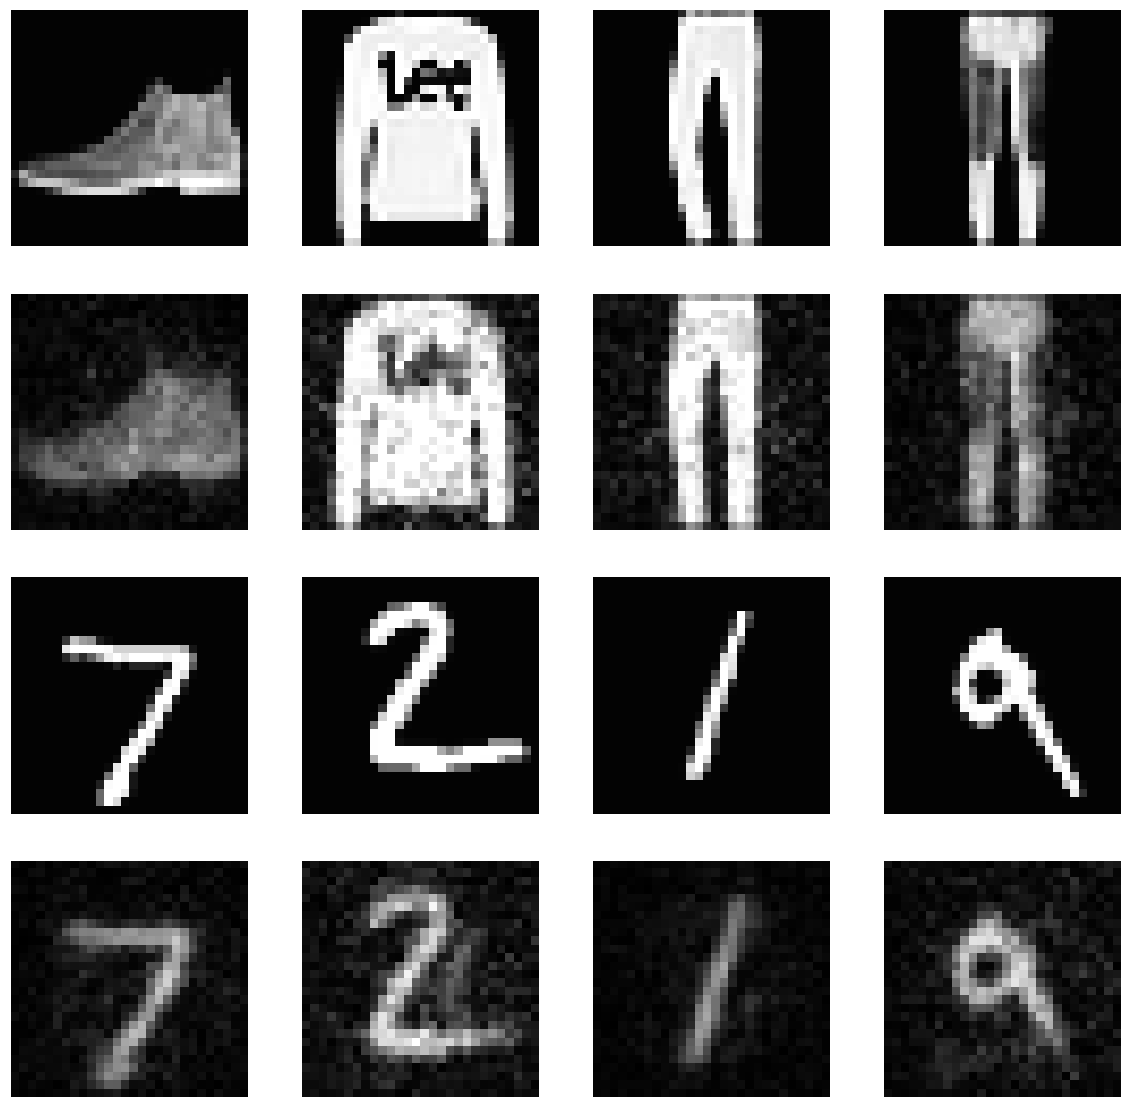

In [21]:
%%time 
model_name = 'comp_pyramid_unitary'

base_img_size = 28
def pyramidize(imgs, levels):
    
    # get images into right shape
    imgs = np.reshape(imgs, (imgs.shape[0], base_img_size, base_img_size))
    
    # do resizing
    resized_imgs = [np.array([cv2.resize(img, dsize=(int(base_img_size//2**i), 
                    int(base_img_size//2**i))) for img in imgs]) for i in range(levels)]
    
    return [np.reshape(size, (imgs.shape[0], int(imgs.shape[1]//2**i)**2))
            for i, size in enumerate(resized_imgs)]
    
y_train_p = pyramidize(y_train, levels=3)
y_test_p  = pyramidize(y_test, levels=3)

weights_filepath = f'weights/{model_name}.h5'
# Setup callbacks
model_chk = ModelCheckpoint(weights_filepath, monitor='mse', 
                            verbose=0, save_best_only=False, 
                            save_weights_only=True, mode='auto',
                            period=1)

early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=5)

t_b = TensorBoard(log_dir=f'./logs/{model_name}', histogram_freq=0, batch_size=32, 
                  write_graph=False, write_grads=False, write_images=False,
                  embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
#model.load_weights(weights_filepath)

mod_6.fit(x_train_ch,
          [y_train_p[0], y_train_p[1], y_train_p[2]],
          validation_data = (x_test_ch, [y_test_p[0], y_test_p[1], y_test_p[2]]),
          epochs = epochs,
          batch_size = batch_size,
          callbacks = [model_chk, reduce_lr, t_b, early_stop],
          shuffle = True,
         )

eval_and_display(mod_6, model_name, x_test_ch, [y_test_p[0], y_test_p[1], y_test_p[2]], vmax= 255.0)

6000/6000 [==============================] - 2s 308us/step
MSE for comp_pyramid_unitary = 1176.2228597005208



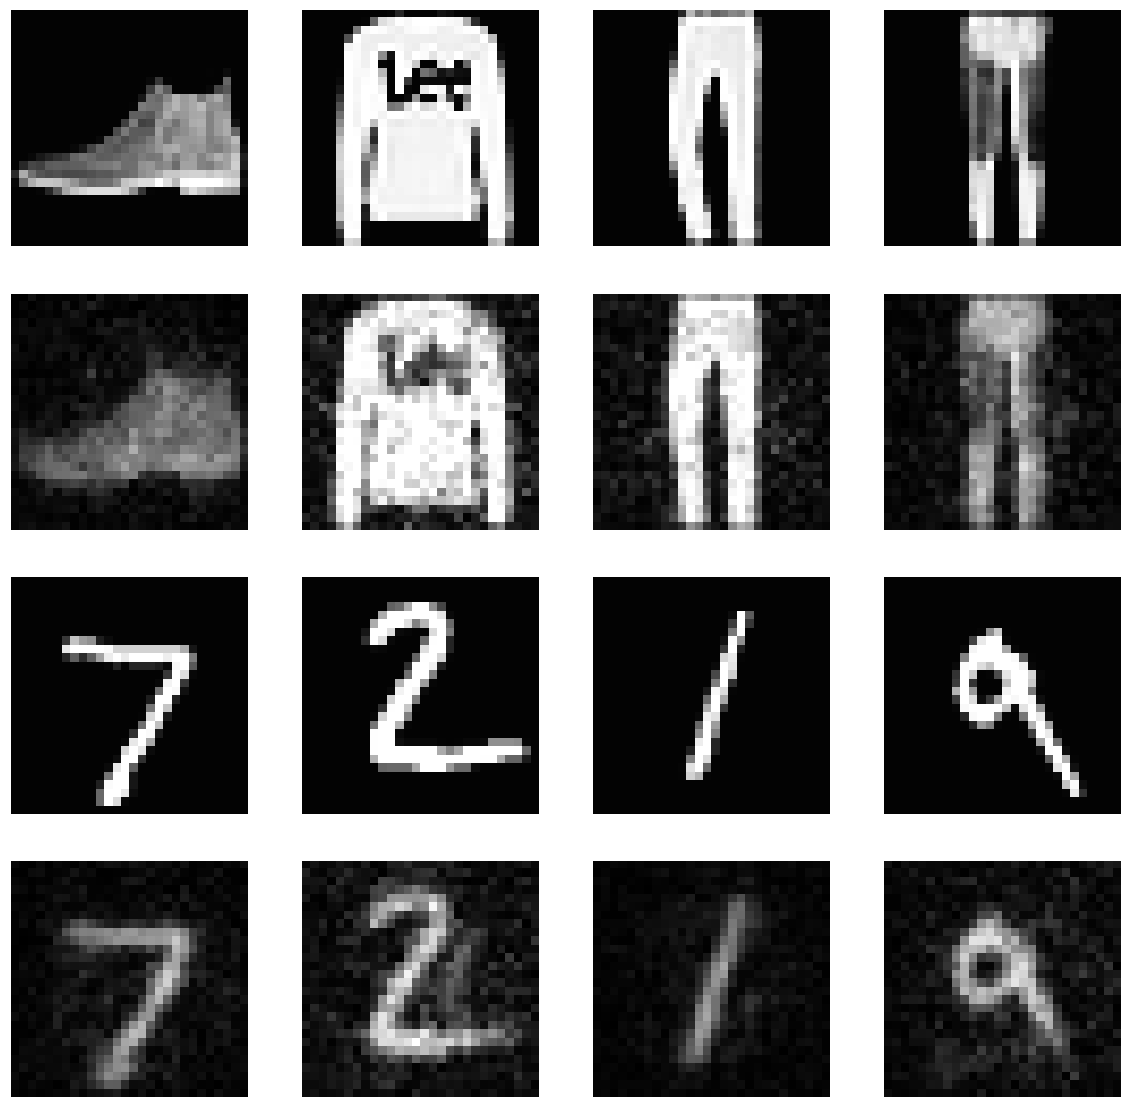

In [22]:
eval_and_display(mod_6, model_name, x_test_ch, [y_test_p[0], y_test_p[1], y_test_p[2]], vmax=255.0)

Train on 44000 samples, validate on 6000 samples
Epoch 1/850
44000/44000 [==============================] - 24s 557us/step - loss: 9381.0955 - amplitude_14_loss: 5125.3038 - amplitude_15_loss: 2059.4367 - amplitude_16_loss: 2195.8380 - amplitude_14_mean_squared_error: 5125.3038 - amplitude_15_mean_squared_error: 2059.4367 - amplitude_16_mean_squared_error: 2195.8380 - val_loss: 5844.8875 - val_amplitude_14_loss: 2522.9414 - val_amplitude_15_loss: 1540.7098 - val_amplitude_16_loss: 1780.3506 - val_amplitude_14_mean_squared_error: 2522.9414 - val_amplitude_15_mean_squared_error: 1540.7098 - val_amplitude_16_mean_squared_error: 1780.3506
Epoch 2/850
44000/44000 [==============================] - 19s 423us/step - loss: 7570.4397 - amplitude_14_loss: 4452.3971 - amplitude_15_loss: 1489.3511 - amplitude_16_loss: 1627.4657 - amplitude_14_mean_squared_error: 4452.3971 - amplitude_15_mean_squared_error: 1489.3511 - amplitude_16_mean_squared_error: 1627.4657 - val_loss: 4795.6547 - val_amplitude

Epoch 15/850
44000/44000 [==============================] - 18s 398us/step - loss: 5194.2906 - amplitude_14_loss: 3278.1722 - amplitude_15_loss: 859.8255 - amplitude_16_loss: 1047.4233 - amplitude_14_mean_squared_error: 3278.1722 - amplitude_15_mean_squared_error: 859.8255 - amplitude_16_mean_squared_error: 1047.4233 - val_loss: 2839.9934 - val_amplitude_14_loss: 1318.3630 - val_amplitude_15_loss: 639.4773 - val_amplitude_16_loss: 872.9990 - val_amplitude_14_mean_squared_error: 1318.3630 - val_amplitude_15_mean_squared_error: 639.4773 - val_amplitude_16_mean_squared_error: 872.9990
Epoch 16/850
44000/44000 [==============================] - 18s 406us/step - loss: 5129.1379 - amplitude_14_loss: 3238.5104 - amplitude_15_loss: 845.7195 - amplitude_16_loss: 1035.4721 - amplitude_14_mean_squared_error: 3238.5104 - amplitude_15_mean_squared_error: 845.7195 - amplitude_16_mean_squared_error: 1035.4721 - val_loss: 2808.9885 - val_amplitude_14_loss: 1305.3377 - val_amplitude_15_loss: 632.3120 -

Epoch 29/850
44000/44000 [==============================] - 18s 402us/step - loss: 4547.1959 - amplitude_14_loss: 2868.1378 - amplitude_15_loss: 728.6779 - amplitude_16_loss: 933.7006 - amplitude_14_mean_squared_error: 2868.1378 - amplitude_15_mean_squared_error: 728.6779 - amplitude_16_mean_squared_error: 933.7006 - val_loss: 2552.1239 - val_amplitude_14_loss: 1183.6513 - val_amplitude_15_loss: 562.9052 - val_amplitude_16_loss: 788.6157 - val_amplitude_14_mean_squared_error: 1183.6513 - val_amplitude_15_mean_squared_error: 562.9052 - val_amplitude_16_mean_squared_error: 788.6157
Epoch 30/850
44000/44000 [==============================] - 18s 401us/step - loss: 4515.3319 - amplitude_14_loss: 2846.9178 - amplitude_15_loss: 722.6299 - amplitude_16_loss: 928.5601 - amplitude_14_mean_squared_error: 2846.9178 - amplitude_15_mean_squared_error: 722.6299 - amplitude_16_mean_squared_error: 928.5601 - val_loss: 2529.2806 - val_amplitude_14_loss: 1174.8494 - val_amplitude_15_loss: 556.6712 - val

Epoch 43/850
44000/44000 [==============================] - 18s 400us/step - loss: 4188.7000 - amplitude_14_loss: 2624.6506 - amplitude_15_loss: 662.8966 - amplitude_16_loss: 876.9991 - amplitude_14_mean_squared_error: 2624.6506 - amplitude_15_mean_squared_error: 662.8966 - amplitude_16_mean_squared_error: 876.9991 - val_loss: 2422.3044 - val_amplitude_14_loss: 1123.3620 - val_amplitude_15_loss: 527.5876 - val_amplitude_16_loss: 746.9400 - val_amplitude_14_mean_squared_error: 1123.3620 - val_amplitude_15_mean_squared_error: 527.5876 - val_amplitude_16_mean_squared_error: 746.9400
Epoch 44/850
44000/44000 [==============================] - 18s 401us/step - loss: 4168.3959 - amplitude_14_loss: 2610.6110 - amplitude_15_loss: 659.3294 - amplitude_16_loss: 873.7807 - amplitude_14_mean_squared_error: 2610.6110 - amplitude_15_mean_squared_error: 659.3294 - amplitude_16_mean_squared_error: 873.7807 - val_loss: 2412.5596 - val_amplitude_14_loss: 1118.0604 - val_amplitude_15_loss: 523.5346 - val

Epoch 57/850
44000/44000 [==============================] - 18s 400us/step - loss: 3949.0802 - amplitude_14_loss: 2455.9755 - amplitude_15_loss: 621.2755 - amplitude_16_loss: 840.5450 - amplitude_14_mean_squared_error: 2455.9755 - amplitude_15_mean_squared_error: 621.2755 - amplitude_16_mean_squared_error: 840.5450 - val_loss: 2360.1391 - val_amplitude_14_loss: 1093.2658 - val_amplitude_15_loss: 507.4838 - val_amplitude_16_loss: 727.8577 - val_amplitude_14_mean_squared_error: 1093.2658 - val_amplitude_15_mean_squared_error: 507.4838 - val_amplitude_16_mean_squared_error: 727.8577
Epoch 58/850
44000/44000 [==============================] - 18s 406us/step - loss: 3934.7847 - amplitude_14_loss: 2445.7246 - amplitude_15_loss: 618.7970 - amplitude_16_loss: 838.4825 - amplitude_14_mean_squared_error: 2445.7246 - amplitude_15_mean_squared_error: 618.7970 - amplitude_16_mean_squared_error: 838.4825 - val_loss: 2343.3380 - val_amplitude_14_loss: 1086.2170 - val_amplitude_15_loss: 503.3498 - val

Epoch 71/850
44000/44000 [==============================] - 18s 403us/step - loss: 3773.5509 - amplitude_14_loss: 2329.2899 - amplitude_15_loss: 591.5033 - amplitude_16_loss: 814.6718 - amplitude_14_mean_squared_error: 2329.2899 - amplitude_15_mean_squared_error: 591.5033 - amplitude_16_mean_squared_error: 814.6718 - val_loss: 2300.7725 - val_amplitude_14_loss: 1067.7065 - val_amplitude_15_loss: 488.6604 - val_amplitude_16_loss: 706.0806 - val_amplitude_14_mean_squared_error: 1067.7065 - val_amplitude_15_mean_squared_error: 488.6604 - val_amplitude_16_mean_squared_error: 706.0806
Epoch 72/850
44000/44000 [==============================] - 18s 406us/step - loss: 3762.5576 - amplitude_14_loss: 2321.3912 - amplitude_15_loss: 589.6828 - amplitude_16_loss: 812.9217 - amplitude_14_mean_squared_error: 2321.3912 - amplitude_15_mean_squared_error: 589.6828 - amplitude_16_mean_squared_error: 812.9217 - val_loss: 2298.2231 - val_amplitude_14_loss: 1066.8966 - val_amplitude_15_loss: 489.2728 - val

Epoch 85/850
44000/44000 [==============================] - 18s 398us/step - loss: 3637.3571 - amplitude_14_loss: 2229.3570 - amplitude_15_loss: 568.8657 - amplitude_16_loss: 794.5436 - amplitude_14_mean_squared_error: 2229.3570 - amplitude_15_mean_squared_error: 568.8657 - amplitude_16_mean_squared_error: 794.5436 - val_loss: 2280.5228 - val_amplitude_14_loss: 1057.1813 - val_amplitude_15_loss: 481.8434 - val_amplitude_16_loss: 696.6799 - val_amplitude_14_mean_squared_error: 1057.1813 - val_amplitude_15_mean_squared_error: 481.8434 - val_amplitude_16_mean_squared_error: 696.6799
Epoch 86/850
44000/44000 [==============================] - 18s 401us/step - loss: 3628.6388 - amplitude_14_loss: 2222.9256 - amplitude_15_loss: 567.4401 - amplitude_16_loss: 793.2290 - amplitude_14_mean_squared_error: 2222.9256 - amplitude_15_mean_squared_error: 567.4401 - amplitude_16_mean_squared_error: 793.2290 - val_loss: 2276.6952 - val_amplitude_14_loss: 1054.3039 - val_amplitude_15_loss: 480.2608 - val

Epoch 99/850
44000/44000 [==============================] - 18s 403us/step - loss: 3527.7928 - amplitude_14_loss: 2147.6817 - amplitude_15_loss: 550.8457 - amplitude_16_loss: 778.4431 - amplitude_14_mean_squared_error: 2147.6817 - amplitude_15_mean_squared_error: 550.8457 - amplitude_16_mean_squared_error: 778.4431 - val_loss: 2253.5750 - val_amplitude_14_loss: 1045.6378 - val_amplitude_15_loss: 473.0748 - val_amplitude_16_loss: 683.8213 - val_amplitude_14_mean_squared_error: 1045.6378 - val_amplitude_15_mean_squared_error: 473.0748 - val_amplitude_16_mean_squared_error: 683.8213
Epoch 100/850
44000/44000 [==============================] - 18s 400us/step - loss: 3520.7194 - amplitude_14_loss: 2142.3654 - amplitude_15_loss: 549.6431 - amplitude_16_loss: 777.4526 - amplitude_14_mean_squared_error: 2142.3654 - amplitude_15_mean_squared_error: 549.6431 - amplitude_16_mean_squared_error: 777.4526 - val_loss: 2253.0361 - val_amplitude_14_loss: 1044.3194 - val_amplitude_15_loss: 471.3877 - va

Epoch 113/850
44000/44000 [==============================] - 18s 399us/step - loss: 3437.2161 - amplitude_14_loss: 2079.3162 - amplitude_15_loss: 535.9839 - amplitude_16_loss: 765.1086 - amplitude_14_mean_squared_error: 2079.3162 - amplitude_15_mean_squared_error: 535.9839 - amplitude_16_mean_squared_error: 765.1086 - val_loss: 2239.2155 - val_amplitude_14_loss: 1037.2406 - val_amplitude_15_loss: 466.0627 - val_amplitude_16_loss: 678.8954 - val_amplitude_14_mean_squared_error: 1037.2406 - val_amplitude_15_mean_squared_error: 466.0627 - val_amplitude_16_mean_squared_error: 678.8954
Epoch 114/850
44000/44000 [==============================] - 18s 403us/step - loss: 3431.2569 - amplitude_14_loss: 2074.8561 - amplitude_15_loss: 534.9979 - amplitude_16_loss: 764.1754 - amplitude_14_mean_squared_error: 2074.8561 - amplitude_15_mean_squared_error: 534.9979 - amplitude_16_mean_squared_error: 764.1754 - val_loss: 2246.0431 - val_amplitude_14_loss: 1039.0951 - val_amplitude_15_loss: 468.6318 - v

Epoch 127/850
44000/44000 [==============================] - 18s 400us/step - loss: 3360.8125 - amplitude_14_loss: 2020.8857 - amplitude_15_loss: 523.4730 - amplitude_16_loss: 753.8845 - amplitude_14_mean_squared_error: 2020.8857 - amplitude_15_mean_squared_error: 523.4730 - amplitude_16_mean_squared_error: 753.8845 - val_loss: 2225.8002 - val_amplitude_14_loss: 1031.7563 - val_amplitude_15_loss: 461.2766 - val_amplitude_16_loss: 669.9953 - val_amplitude_14_mean_squared_error: 1031.7563 - val_amplitude_15_mean_squared_error: 461.2766 - val_amplitude_16_mean_squared_error: 669.9953
Epoch 128/850
44000/44000 [==============================] - 18s 404us/step - loss: 3355.6543 - amplitude_14_loss: 2016.9972 - amplitude_15_loss: 522.6155 - amplitude_16_loss: 753.0690 - amplitude_14_mean_squared_error: 2016.9972 - amplitude_15_mean_squared_error: 522.6155 - amplitude_16_mean_squared_error: 753.0690 - val_loss: 2226.1007 - val_amplitude_14_loss: 1028.8964 - val_amplitude_15_loss: 458.2934 - v

Epoch 141/850
44000/44000 [==============================] - 18s 400us/step - loss: 3294.9432 - amplitude_14_loss: 1970.1749 - amplitude_15_loss: 512.7534 - amplitude_16_loss: 743.8893 - amplitude_14_mean_squared_error: 1970.1749 - amplitude_15_mean_squared_error: 512.7534 - amplitude_16_mean_squared_error: 743.8893 - val_loss: 2211.3051 - val_amplitude_14_loss: 1025.0956 - val_amplitude_15_loss: 453.9477 - val_amplitude_16_loss: 663.9420 - val_amplitude_14_mean_squared_error: 1025.0956 - val_amplitude_15_mean_squared_error: 453.9477 - val_amplitude_16_mean_squared_error: 663.9420
Epoch 142/850
44000/44000 [==============================] - 18s 417us/step - loss: 3290.4521 - amplitude_14_loss: 1966.7169 - amplitude_15_loss: 511.9507 - amplitude_16_loss: 743.2708 - amplitude_14_mean_squared_error: 1966.7169 - amplitude_15_mean_squared_error: 511.9507 - amplitude_16_mean_squared_error: 743.2708 - val_loss: 2215.3010 - val_amplitude_14_loss: 1024.8993 - val_amplitude_15_loss: 454.9227 - v

Epoch 155/850
44000/44000 [==============================] - 18s 402us/step - loss: 3237.4103 - amplitude_14_loss: 1925.3376 - amplitude_15_loss: 503.1951 - amplitude_16_loss: 735.3847 - amplitude_14_mean_squared_error: 1925.3376 - amplitude_15_mean_squared_error: 503.1951 - amplitude_16_mean_squared_error: 735.3847 - val_loss: 2209.6832 - val_amplitude_14_loss: 1020.4075 - val_amplitude_15_loss: 450.7164 - val_amplitude_16_loss: 664.8786 - val_amplitude_14_mean_squared_error: 1020.4075 - val_amplitude_15_mean_squared_error: 450.7164 - val_amplitude_16_mean_squared_error: 664.8786
Epoch 156/850
44000/44000 [==============================] - 18s 402us/step - loss: 3233.5939 - amplitude_14_loss: 1922.3623 - amplitude_15_loss: 502.5831 - amplitude_16_loss: 734.7800 - amplitude_14_mean_squared_error: 1922.3623 - amplitude_15_mean_squared_error: 502.5831 - amplitude_16_mean_squared_error: 734.7800 - val_loss: 2203.9088 - val_amplitude_14_loss: 1020.3743 - val_amplitude_15_loss: 450.3736 - v

Epoch 169/850
44000/44000 [==============================] - 18s 400us/step - loss: 3187.0408 - amplitude_14_loss: 1885.6909 - amplitude_15_loss: 494.9025 - amplitude_16_loss: 727.7608 - amplitude_14_mean_squared_error: 1885.6909 - amplitude_15_mean_squared_error: 494.9025 - amplitude_16_mean_squared_error: 727.7608 - val_loss: 2195.7392 - val_amplitude_14_loss: 1015.9436 - val_amplitude_15_loss: 445.3411 - val_amplitude_16_loss: 655.5866 - val_amplitude_14_mean_squared_error: 1015.9436 - val_amplitude_15_mean_squared_error: 445.3411 - val_amplitude_16_mean_squared_error: 655.5866
Epoch 170/850
44000/44000 [==============================] - 18s 403us/step - loss: 3183.7272 - amplitude_14_loss: 1883.0535 - amplitude_15_loss: 494.3387 - amplitude_16_loss: 727.2846 - amplitude_14_mean_squared_error: 1883.0535 - amplitude_15_mean_squared_error: 494.3387 - amplitude_16_mean_squared_error: 727.2846 - val_loss: 2195.9695 - val_amplitude_14_loss: 1013.6255 - val_amplitude_15_loss: 444.6691 - v

Epoch 183/850
44000/44000 [==============================] - 18s 400us/step - loss: 3142.0561 - amplitude_14_loss: 1849.9665 - amplitude_15_loss: 487.3873 - amplitude_16_loss: 720.9846 - amplitude_14_mean_squared_error: 1849.9665 - amplitude_15_mean_squared_error: 487.3873 - amplitude_16_mean_squared_error: 720.9846 - val_loss: 2190.1319 - val_amplitude_14_loss: 1009.1842 - val_amplitude_15_loss: 441.5025 - val_amplitude_16_loss: 655.5493 - val_amplitude_14_mean_squared_error: 1009.1842 - val_amplitude_15_mean_squared_error: 441.5025 - val_amplitude_16_mean_squared_error: 655.5493
Epoch 184/850
44000/44000 [==============================] - 18s 403us/step - loss: 3139.1899 - amplitude_14_loss: 1847.6573 - amplitude_15_loss: 486.9354 - amplitude_16_loss: 720.5232 - amplitude_14_mean_squared_error: 1847.6573 - amplitude_15_mean_squared_error: 486.9354 - amplitude_16_mean_squared_error: 720.5232 - val_loss: 2193.4738 - val_amplitude_14_loss: 1012.3747 - val_amplitude_15_loss: 444.0571 - v

Epoch 197/850
44000/44000 [==============================] - 18s 402us/step - loss: 3102.0549 - amplitude_14_loss: 1817.8280 - amplitude_15_loss: 480.7326 - amplitude_16_loss: 714.8914 - amplitude_14_mean_squared_error: 1817.8280 - amplitude_15_mean_squared_error: 480.7326 - amplitude_16_mean_squared_error: 714.8914 - val_loss: 2187.1643 - val_amplitude_14_loss: 1009.6257 - val_amplitude_15_loss: 439.2055 - val_amplitude_16_loss: 649.5585 - val_amplitude_14_mean_squared_error: 1009.6257 - val_amplitude_15_mean_squared_error: 439.2055 - val_amplitude_16_mean_squared_error: 649.5585
Epoch 198/850
44000/44000 [==============================] - 18s 402us/step - loss: 3099.4150 - amplitude_14_loss: 1815.7029 - amplitude_15_loss: 480.2976 - amplitude_16_loss: 714.4693 - amplitude_14_mean_squared_error: 1815.7029 - amplitude_15_mean_squared_error: 480.2976 - amplitude_16_mean_squared_error: 714.4693 - val_loss: 2185.9760 - val_amplitude_14_loss: 1008.2742 - val_amplitude_15_loss: 439.1720 - v

Epoch 211/850
44000/44000 [==============================] - 18s 402us/step - loss: 3065.7544 - amplitude_14_loss: 1788.5028 - amplitude_15_loss: 474.6358 - amplitude_16_loss: 709.2705 - amplitude_14_mean_squared_error: 1788.5028 - amplitude_15_mean_squared_error: 474.6358 - amplitude_16_mean_squared_error: 709.2705 - val_loss: 2174.8007 - val_amplitude_14_loss: 1002.6866 - val_amplitude_15_loss: 435.4503 - val_amplitude_16_loss: 643.1488 - val_amplitude_14_mean_squared_error: 1002.6866 - val_amplitude_15_mean_squared_error: 435.4503 - val_amplitude_16_mean_squared_error: 643.1488
Epoch 212/850
44000/44000 [==============================] - 18s 402us/step - loss: 3063.3493 - amplitude_14_loss: 1786.6215 - amplitude_15_loss: 474.2958 - amplitude_16_loss: 708.7512 - amplitude_14_mean_squared_error: 1786.6215 - amplitude_15_mean_squared_error: 474.2958 - amplitude_16_mean_squared_error: 708.7512 - val_loss: 2181.0183 - val_amplitude_14_loss: 1004.7485 - val_amplitude_15_loss: 437.7053 - v

Epoch 225/850
44000/44000 [==============================] - 18s 402us/step - loss: 3032.9056 - amplitude_14_loss: 1761.6952 - amplitude_15_loss: 469.0539 - amplitude_16_loss: 704.1974 - amplitude_14_mean_squared_error: 1761.6952 - amplitude_15_mean_squared_error: 469.0539 - amplitude_16_mean_squared_error: 704.1974 - val_loss: 2172.2929 - val_amplitude_14_loss: 1001.3185 - val_amplitude_15_loss: 432.2187 - val_amplitude_16_loss: 640.6321 - val_amplitude_14_mean_squared_error: 1001.3185 - val_amplitude_15_mean_squared_error: 432.2187 - val_amplitude_16_mean_squared_error: 640.6321
Epoch 226/850
44000/44000 [==============================] - 18s 407us/step - loss: 3030.6350 - amplitude_14_loss: 1759.8188 - amplitude_15_loss: 468.6547 - amplitude_16_loss: 703.8785 - amplitude_14_mean_squared_error: 1759.8188 - amplitude_15_mean_squared_error: 468.6547 - amplitude_16_mean_squared_error: 703.8785 - val_loss: 2177.3563 - val_amplitude_14_loss: 1003.6262 - val_amplitude_15_loss: 435.4641 - v

Epoch 239/850
44000/44000 [==============================] - 18s 399us/step - loss: 3002.7303 - amplitude_14_loss: 1737.0577 - amplitude_15_loss: 463.9846 - amplitude_16_loss: 699.2347 - amplitude_14_mean_squared_error: 1737.0577 - amplitude_15_mean_squared_error: 463.9846 - amplitude_16_mean_squared_error: 699.2347 - val_loss: 2176.3125 - val_amplitude_14_loss: 1001.5538 - val_amplitude_15_loss: 433.0621 - val_amplitude_16_loss: 639.0857 - val_amplitude_14_mean_squared_error: 1001.5538 - val_amplitude_15_mean_squared_error: 433.0621 - val_amplitude_16_mean_squared_error: 639.0857
Epoch 240/850
44000/44000 [==============================] - 18s 405us/step - loss: 3000.6655 - amplitude_14_loss: 1735.2687 - amplitude_15_loss: 463.5655 - amplitude_16_loss: 699.0638 - amplitude_14_mean_squared_error: 1735.2687 - amplitude_15_mean_squared_error: 463.5655 - amplitude_16_mean_squared_error: 699.0638 - val_loss: 2169.6260 - val_amplitude_14_loss: 998.4904 - val_amplitude_15_loss: 430.3128 - va

Epoch 253/850
44000/44000 [==============================] - 18s 400us/step - loss: 2975.1470 - amplitude_14_loss: 1714.1305 - amplitude_15_loss: 459.1621 - amplitude_16_loss: 695.0268 - amplitude_14_mean_squared_error: 1714.1305 - amplitude_15_mean_squared_error: 459.1621 - amplitude_16_mean_squared_error: 695.0268 - val_loss: 2172.8986 - val_amplitude_14_loss: 997.2251 - val_amplitude_15_loss: 429.9820 - val_amplitude_16_loss: 638.7082 - val_amplitude_14_mean_squared_error: 997.2251 - val_amplitude_15_mean_squared_error: 429.9820 - val_amplitude_16_mean_squared_error: 638.7082
Epoch 254/850
44000/44000 [==============================] - 18s 406us/step - loss: 2973.3499 - amplitude_14_loss: 1712.6644 - amplitude_15_loss: 458.9244 - amplitude_16_loss: 694.6243 - amplitude_14_mean_squared_error: 1712.6644 - amplitude_15_mean_squared_error: 458.9244 - amplitude_16_mean_squared_error: 694.6243 - val_loss: 2174.9019 - val_amplitude_14_loss: 1000.1015 - val_amplitude_15_loss: 432.3822 - val

Epoch 267/850
44000/44000 [==============================] - 18s 402us/step - loss: 2949.9078 - amplitude_14_loss: 1693.0877 - amplitude_15_loss: 454.8733 - amplitude_16_loss: 690.8509 - amplitude_14_mean_squared_error: 1693.0877 - amplitude_15_mean_squared_error: 454.8733 - amplitude_16_mean_squared_error: 690.8509 - val_loss: 2170.3055 - val_amplitude_14_loss: 993.7439 - val_amplitude_15_loss: 427.1328 - val_amplitude_16_loss: 638.1831 - val_amplitude_14_mean_squared_error: 993.7439 - val_amplitude_15_mean_squared_error: 427.1328 - val_amplitude_16_mean_squared_error: 638.1831
Epoch 268/850
44000/44000 [==============================] - 18s 405us/step - loss: 2948.2088 - amplitude_14_loss: 1691.5744 - amplitude_15_loss: 454.5380 - amplitude_16_loss: 690.7008 - amplitude_14_mean_squared_error: 1691.5744 - amplitude_15_mean_squared_error: 454.5380 - amplitude_16_mean_squared_error: 690.7008 - val_loss: 2167.1799 - val_amplitude_14_loss: 993.7222 - val_amplitude_15_loss: 426.7067 - val_

Epoch 281/850
44000/44000 [==============================] - 18s 404us/step - loss: 2926.4906 - amplitude_14_loss: 1673.3409 - amplitude_15_loss: 450.7985 - amplitude_16_loss: 687.0925 - amplitude_14_mean_squared_error: 1673.3409 - amplitude_15_mean_squared_error: 450.7985 - amplitude_16_mean_squared_error: 687.0925 - val_loss: 2167.4667 - val_amplitude_14_loss: 993.4194 - val_amplitude_15_loss: 426.1120 - val_amplitude_16_loss: 632.5288 - val_amplitude_14_mean_squared_error: 993.4194 - val_amplitude_15_mean_squared_error: 426.1120 - val_amplitude_16_mean_squared_error: 632.5288
Epoch 282/850
44000/44000 [==============================] - 18s 401us/step - loss: 2924.8952 - amplitude_14_loss: 1671.9789 - amplitude_15_loss: 450.5190 - amplitude_16_loss: 686.8445 - amplitude_14_mean_squared_error: 1671.9789 - amplitude_15_mean_squared_error: 450.5190 - amplitude_16_mean_squared_error: 686.8445 - val_loss: 2166.7611 - val_amplitude_14_loss: 994.1352 - val_amplitude_15_loss: 426.2246 - val_

Epoch 295/850
44000/44000 [==============================] - 18s 400us/step - loss: 2904.8251 - amplitude_14_loss: 1654.9072 - amplitude_15_loss: 446.9528 - amplitude_16_loss: 683.6406 - amplitude_14_mean_squared_error: 1654.9072 - amplitude_15_mean_squared_error: 446.9528 - amplitude_16_mean_squared_error: 683.6406 - val_loss: 2165.1830 - val_amplitude_14_loss: 988.6847 - val_amplitude_15_loss: 423.2194 - val_amplitude_16_loss: 633.8099 - val_amplitude_14_mean_squared_error: 988.6847 - val_amplitude_15_mean_squared_error: 423.2194 - val_amplitude_16_mean_squared_error: 633.8099
Epoch 296/850
44000/44000 [==============================] - 18s 402us/step - loss: 2903.4488 - amplitude_14_loss: 1653.7579 - amplitude_15_loss: 446.8019 - amplitude_16_loss: 683.2758 - amplitude_14_mean_squared_error: 1653.7579 - amplitude_15_mean_squared_error: 446.8019 - amplitude_16_mean_squared_error: 683.2758 - val_loss: 2161.2990 - val_amplitude_14_loss: 989.6285 - val_amplitude_15_loss: 423.4525 - val_

Epoch 309/850
44000/44000 [==============================] - 18s 401us/step - loss: 2884.5620 - amplitude_14_loss: 1637.6762 - amplitude_15_loss: 443.4417 - amplitude_16_loss: 680.1451 - amplitude_14_mean_squared_error: 1637.6762 - amplitude_15_mean_squared_error: 443.4417 - amplitude_16_mean_squared_error: 680.1451 - val_loss: 2166.8817 - val_amplitude_14_loss: 990.0625 - val_amplitude_15_loss: 423.8901 - val_amplitude_16_loss: 629.4901 - val_amplitude_14_mean_squared_error: 990.0625 - val_amplitude_15_mean_squared_error: 423.8901 - val_amplitude_16_mean_squared_error: 629.4901
Epoch 310/850
44000/44000 [==============================] - 18s 404us/step - loss: 2883.2397 - amplitude_14_loss: 1636.4396 - amplitude_15_loss: 443.1308 - amplitude_16_loss: 680.0895 - amplitude_14_mean_squared_error: 1636.4396 - amplitude_15_mean_squared_error: 443.1308 - amplitude_16_mean_squared_error: 680.0895 - val_loss: 2166.1666 - val_amplitude_14_loss: 990.0664 - val_amplitude_15_loss: 423.6986 - val_

Epoch 323/850
44000/44000 [==============================] - 18s 401us/step - loss: 2865.7870 - amplitude_14_loss: 1621.5137 - amplitude_15_loss: 440.0911 - amplitude_16_loss: 676.9984 - amplitude_14_mean_squared_error: 1621.5137 - amplitude_15_mean_squared_error: 440.0911 - amplitude_16_mean_squared_error: 676.9984 - val_loss: 2165.7127 - val_amplitude_14_loss: 984.2667 - val_amplitude_15_loss: 420.8226 - val_amplitude_16_loss: 633.3038 - val_amplitude_14_mean_squared_error: 984.2667 - val_amplitude_15_mean_squared_error: 420.8226 - val_amplitude_16_mean_squared_error: 633.3038
Epoch 324/850
44000/44000 [==============================] - 18s 403us/step - loss: 2864.3787 - amplitude_14_loss: 1620.2757 - amplitude_15_loss: 439.7718 - amplitude_16_loss: 676.8744 - amplitude_14_mean_squared_error: 1620.2757 - amplitude_15_mean_squared_error: 439.7718 - amplitude_16_mean_squared_error: 676.8744 - val_loss: 2163.7042 - val_amplitude_14_loss: 985.3091 - val_amplitude_15_loss: 420.7038 - val_

Epoch 337/850
44000/44000 [==============================] - 18s 401us/step - loss: 2848.2446 - amplitude_14_loss: 1606.2007 - amplitude_15_loss: 436.8912 - amplitude_16_loss: 674.1696 - amplitude_14_mean_squared_error: 1606.2007 - amplitude_15_mean_squared_error: 436.8912 - amplitude_16_mean_squared_error: 674.1696 - val_loss: 2158.9142 - val_amplitude_14_loss: 982.5949 - val_amplitude_15_loss: 418.1255 - val_amplitude_16_loss: 627.0764 - val_amplitude_14_mean_squared_error: 982.5949 - val_amplitude_15_mean_squared_error: 418.1255 - val_amplitude_16_mean_squared_error: 627.0764
Epoch 338/850
44000/44000 [==============================] - 18s 400us/step - loss: 2846.8543 - amplitude_14_loss: 1605.0886 - amplitude_15_loss: 436.6604 - amplitude_16_loss: 673.8544 - amplitude_14_mean_squared_error: 1605.0886 - amplitude_15_mean_squared_error: 436.6604 - amplitude_16_mean_squared_error: 673.8544 - val_loss: 2154.3901 - val_amplitude_14_loss: 978.8134 - val_amplitude_15_loss: 415.2199 - val_

Epoch 351/850
44000/44000 [==============================] - 18s 404us/step - loss: 2831.6655 - amplitude_14_loss: 1591.7176 - amplitude_15_loss: 433.8789 - amplitude_16_loss: 671.3677 - amplitude_14_mean_squared_error: 1591.7176 - amplitude_15_mean_squared_error: 433.8789 - amplitude_16_mean_squared_error: 671.3677 - val_loss: 2154.4292 - val_amplitude_14_loss: 980.1347 - val_amplitude_15_loss: 416.0713 - val_amplitude_16_loss: 623.3898 - val_amplitude_14_mean_squared_error: 980.1347 - val_amplitude_15_mean_squared_error: 416.0713 - val_amplitude_16_mean_squared_error: 623.3898
Epoch 352/850
44000/44000 [==============================] - 18s 406us/step - loss: 2830.5792 - amplitude_14_loss: 1590.7811 - amplitude_15_loss: 433.7513 - amplitude_16_loss: 671.0814 - amplitude_14_mean_squared_error: 1590.7811 - amplitude_15_mean_squared_error: 433.7513 - amplitude_16_mean_squared_error: 671.0814 - val_loss: 2162.6483 - val_amplitude_14_loss: 982.4383 - val_amplitude_15_loss: 417.2173 - val_

Epoch 365/850
44000/44000 [==============================] - 18s 399us/step - loss: 2816.1467 - amplitude_14_loss: 1578.0666 - amplitude_15_loss: 431.0505 - amplitude_16_loss: 668.6866 - amplitude_14_mean_squared_error: 1578.0666 - amplitude_15_mean_squared_error: 431.0505 - amplitude_16_mean_squared_error: 668.6866 - val_loss: 2161.7680 - val_amplitude_14_loss: 981.3193 - val_amplitude_15_loss: 417.7224 - val_amplitude_16_loss: 624.2535 - val_amplitude_14_mean_squared_error: 981.3193 - val_amplitude_15_mean_squared_error: 417.7224 - val_amplitude_16_mean_squared_error: 624.2535
Epoch 366/850
44000/44000 [==============================] - 18s 403us/step - loss: 2814.9928 - amplitude_14_loss: 1577.0933 - amplitude_15_loss: 430.8549 - amplitude_16_loss: 668.4424 - amplitude_14_mean_squared_error: 1577.0933 - amplitude_15_mean_squared_error: 430.8549 - amplitude_16_mean_squared_error: 668.4424 - val_loss: 2155.0724 - val_amplitude_14_loss: 977.9625 - val_amplitude_15_loss: 414.5517 - val_

Epoch 379/850
44000/44000 [==============================] - 18s 401us/step - loss: 2801.5303 - amplitude_14_loss: 1565.1495 - amplitude_15_loss: 428.3800 - amplitude_16_loss: 666.0897 - amplitude_14_mean_squared_error: 1565.1495 - amplitude_15_mean_squared_error: 428.3800 - amplitude_16_mean_squared_error: 666.0897 - val_loss: 2158.0848 - val_amplitude_14_loss: 978.4823 - val_amplitude_15_loss: 415.2784 - val_amplitude_16_loss: 622.2865 - val_amplitude_14_mean_squared_error: 978.4823 - val_amplitude_15_mean_squared_error: 415.2784 - val_amplitude_16_mean_squared_error: 622.2865
Epoch 380/850
44000/44000 [==============================] - 18s 402us/step - loss: 2800.5508 - amplitude_14_loss: 1564.1816 - amplitude_15_loss: 428.1809 - amplitude_16_loss: 666.0248 - amplitude_14_mean_squared_error: 1564.1816 - amplitude_15_mean_squared_error: 428.1809 - amplitude_16_mean_squared_error: 666.0248 - val_loss: 2162.5187 - val_amplitude_14_loss: 978.0635 - val_amplitude_15_loss: 415.0490 - val_

Epoch 393/850
44000/44000 [==============================] - 18s 400us/step - loss: 2787.8117 - amplitude_14_loss: 1552.8225 - amplitude_15_loss: 425.8442 - amplitude_16_loss: 663.7360 - amplitude_14_mean_squared_error: 1552.8225 - amplitude_15_mean_squared_error: 425.8442 - amplitude_16_mean_squared_error: 663.7360 - val_loss: 2158.6493 - val_amplitude_14_loss: 976.0016 - val_amplitude_15_loss: 414.5254 - val_amplitude_16_loss: 622.5912 - val_amplitude_14_mean_squared_error: 976.0016 - val_amplitude_15_mean_squared_error: 414.5254 - val_amplitude_16_mean_squared_error: 622.5912
Epoch 394/850
44000/44000 [==============================] - 18s 405us/step - loss: 2786.9276 - amplitude_14_loss: 1551.9557 - amplitude_15_loss: 425.6167 - amplitude_16_loss: 663.7002 - amplitude_14_mean_squared_error: 1551.9557 - amplitude_15_mean_squared_error: 425.6167 - amplitude_16_mean_squared_error: 663.7002 - val_loss: 2152.1647 - val_amplitude_14_loss: 975.9954 - val_amplitude_15_loss: 412.4067 - val_

Epoch 407/850
44000/44000 [==============================] - 18s 404us/step - loss: 2774.7810 - amplitude_14_loss: 1541.0865 - amplitude_15_loss: 423.3608 - amplitude_16_loss: 661.4974 - amplitude_14_mean_squared_error: 1541.0865 - amplitude_15_mean_squared_error: 423.3608 - amplitude_16_mean_squared_error: 661.4974 - val_loss: 2159.1549 - val_amplitude_14_loss: 975.6519 - val_amplitude_15_loss: 413.2031 - val_amplitude_16_loss: 621.3429 - val_amplitude_14_mean_squared_error: 975.6519 - val_amplitude_15_mean_squared_error: 413.2031 - val_amplitude_16_mean_squared_error: 621.3429
Epoch 408/850
44000/44000 [==============================] - 18s 404us/step - loss: 2774.0731 - amplitude_14_loss: 1540.3373 - amplitude_15_loss: 423.2780 - amplitude_16_loss: 661.3800 - amplitude_14_mean_squared_error: 1540.3373 - amplitude_15_mean_squared_error: 423.2780 - amplitude_16_mean_squared_error: 661.3800 - val_loss: 2152.4817 - val_amplitude_14_loss: 973.7984 - val_amplitude_15_loss: 411.5533 - val_

Epoch 421/850
44000/44000 [==============================] - 18s 401us/step - loss: 2762.7133 - amplitude_14_loss: 1530.0480 - amplitude_15_loss: 421.1204 - amplitude_16_loss: 659.3475 - amplitude_14_mean_squared_error: 1530.0480 - amplitude_15_mean_squared_error: 421.1204 - amplitude_16_mean_squared_error: 659.3475 - val_loss: 2154.4715 - val_amplitude_14_loss: 972.9075 - val_amplitude_15_loss: 411.4234 - val_amplitude_16_loss: 617.8231 - val_amplitude_14_mean_squared_error: 972.9075 - val_amplitude_15_mean_squared_error: 411.4234 - val_amplitude_16_mean_squared_error: 617.8231
Epoch 422/850
44000/44000 [==============================] - 18s 402us/step - loss: 2761.6681 - amplitude_14_loss: 1529.2431 - amplitude_15_loss: 420.9524 - amplitude_16_loss: 659.0366 - amplitude_14_mean_squared_error: 1529.2431 - amplitude_15_mean_squared_error: 420.9524 - amplitude_16_mean_squared_error: 659.0366 - val_loss: 2154.9776 - val_amplitude_14_loss: 972.3102 - val_amplitude_15_loss: 410.6225 - val_

Epoch 435/850
44000/44000 [==============================] - 18s 401us/step - loss: 2750.9942 - amplitude_14_loss: 1519.3344 - amplitude_15_loss: 418.8714 - amplitude_16_loss: 657.2930 - amplitude_14_mean_squared_error: 1519.3344 - amplitude_15_mean_squared_error: 418.8714 - amplitude_16_mean_squared_error: 657.2930 - val_loss: 2150.8203 - val_amplitude_14_loss: 970.4885 - val_amplitude_15_loss: 410.1473 - val_amplitude_16_loss: 614.5710 - val_amplitude_14_mean_squared_error: 970.4885 - val_amplitude_15_mean_squared_error: 410.1473 - val_amplitude_16_mean_squared_error: 614.5710
Epoch 436/850
44000/44000 [==============================] - 18s 411us/step - loss: 2750.0678 - amplitude_14_loss: 1518.5234 - amplitude_15_loss: 418.6829 - amplitude_16_loss: 657.1325 - amplitude_14_mean_squared_error: 1518.5234 - amplitude_15_mean_squared_error: 418.6829 - amplitude_16_mean_squared_error: 657.1325 - val_loss: 2151.0897 - val_amplitude_14_loss: 969.9625 - val_amplitude_15_loss: 408.8014 - val_

Epoch 449/850
44000/44000 [==============================] - 18s 399us/step - loss: 2739.9210 - amplitude_14_loss: 1509.2190 - amplitude_15_loss: 416.7516 - amplitude_16_loss: 655.2160 - amplitude_14_mean_squared_error: 1509.2190 - amplitude_15_mean_squared_error: 416.7516 - amplitude_16_mean_squared_error: 655.2160 - val_loss: 2150.3017 - val_amplitude_14_loss: 968.1105 - val_amplitude_15_loss: 407.6335 - val_amplitude_16_loss: 615.7104 - val_amplitude_14_mean_squared_error: 968.1105 - val_amplitude_15_mean_squared_error: 407.6335 - val_amplitude_16_mean_squared_error: 615.7104
Epoch 450/850
44000/44000 [==============================] - 18s 405us/step - loss: 2738.9670 - amplitude_14_loss: 1508.3914 - amplitude_15_loss: 416.5405 - amplitude_16_loss: 655.0731 - amplitude_14_mean_squared_error: 1508.3914 - amplitude_15_mean_squared_error: 416.5405 - amplitude_16_mean_squared_error: 655.0731 - val_loss: 2159.7157 - val_amplitude_14_loss: 972.0262 - val_amplitude_15_loss: 411.6124 - val_

Epoch 463/850
44000/44000 [==============================] - 18s 406us/step - loss: 2729.3919 - amplitude_14_loss: 1499.3841 - amplitude_15_loss: 414.6738 - amplitude_16_loss: 653.4230 - amplitude_14_mean_squared_error: 1499.3841 - amplitude_15_mean_squared_error: 414.6738 - amplitude_16_mean_squared_error: 653.4230 - val_loss: 2151.3689 - val_amplitude_14_loss: 968.4329 - val_amplitude_15_loss: 407.4805 - val_amplitude_16_loss: 613.4309 - val_amplitude_14_mean_squared_error: 968.4329 - val_amplitude_15_mean_squared_error: 407.4805 - val_amplitude_16_mean_squared_error: 613.4309
Epoch 464/850
44000/44000 [==============================] - 18s 403us/step - loss: 2728.6787 - amplitude_14_loss: 1498.7757 - amplitude_15_loss: 414.5850 - amplitude_16_loss: 653.1800 - amplitude_14_mean_squared_error: 1498.7757 - amplitude_15_mean_squared_error: 414.5850 - amplitude_16_mean_squared_error: 653.1800 - val_loss: 2156.5327 - val_amplitude_14_loss: 969.4010 - val_amplitude_15_loss: 409.7948 - val_

Epoch 477/850
44000/44000 [==============================] - 18s 403us/step - loss: 2719.4208 - amplitude_14_loss: 1490.0998 - amplitude_15_loss: 412.7781 - amplitude_16_loss: 651.5102 - amplitude_14_mean_squared_error: 1490.0998 - amplitude_15_mean_squared_error: 412.7781 - amplitude_16_mean_squared_error: 651.5102 - val_loss: 2149.8094 - val_amplitude_14_loss: 965.4811 - val_amplitude_15_loss: 406.2329 - val_amplitude_16_loss: 612.9519 - val_amplitude_14_mean_squared_error: 965.4811 - val_amplitude_15_mean_squared_error: 406.2329 - val_amplitude_16_mean_squared_error: 612.9519
Epoch 478/850
44000/44000 [==============================] - 18s 404us/step - loss: 2718.6057 - amplitude_14_loss: 1489.4455 - amplitude_15_loss: 412.6172 - amplitude_16_loss: 651.2882 - amplitude_14_mean_squared_error: 1489.4455 - amplitude_15_mean_squared_error: 412.6172 - amplitude_16_mean_squared_error: 651.2882 - val_loss: 2149.8339 - val_amplitude_14_loss: 966.1674 - val_amplitude_15_loss: 406.6739 - val_

Epoch 491/850
44000/44000 [==============================] - 18s 399us/step - loss: 2709.9009 - amplitude_14_loss: 1481.1660 - amplitude_15_loss: 410.9097 - amplitude_16_loss: 649.7253 - amplitude_14_mean_squared_error: 1481.1660 - amplitude_15_mean_squared_error: 410.9097 - amplitude_16_mean_squared_error: 649.7253 - val_loss: 2157.9419 - val_amplitude_14_loss: 965.6763 - val_amplitude_15_loss: 406.7559 - val_amplitude_16_loss: 617.3030 - val_amplitude_14_mean_squared_error: 965.6763 - val_amplitude_15_mean_squared_error: 406.7559 - val_amplitude_16_mean_squared_error: 617.3030
Epoch 492/850
44000/44000 [==============================] - 18s 406us/step - loss: 2709.2911 - amplitude_14_loss: 1480.5690 - amplitude_15_loss: 410.7872 - amplitude_16_loss: 649.6191 - amplitude_14_mean_squared_error: 1480.5690 - amplitude_15_mean_squared_error: 410.7872 - amplitude_16_mean_squared_error: 649.6191 - val_loss: 2154.9408 - val_amplitude_14_loss: 963.3255 - val_amplitude_15_loss: 405.6635 - val_

Epoch 505/850
44000/44000 [==============================] - 18s 400us/step - loss: 2700.8498 - amplitude_14_loss: 1472.5833 - amplitude_15_loss: 409.1188 - amplitude_16_loss: 648.0373 - amplitude_14_mean_squared_error: 1472.5833 - amplitude_15_mean_squared_error: 409.1188 - amplitude_16_mean_squared_error: 648.0373 - val_loss: 2150.2647 - val_amplitude_14_loss: 963.2558 - val_amplitude_15_loss: 404.3275 - val_amplitude_16_loss: 611.4629 - val_amplitude_14_mean_squared_error: 963.2558 - val_amplitude_15_mean_squared_error: 404.3275 - val_amplitude_16_mean_squared_error: 611.4629
Epoch 506/850
44000/44000 [==============================] - 18s 402us/step - loss: 2700.2678 - amplitude_14_loss: 1472.0190 - amplitude_15_loss: 409.0420 - amplitude_16_loss: 647.8823 - amplitude_14_mean_squared_error: 1472.0190 - amplitude_15_mean_squared_error: 409.0420 - amplitude_16_mean_squared_error: 647.8823 - val_loss: 2152.5158 - val_amplitude_14_loss: 963.0450 - val_amplitude_15_loss: 404.2610 - val_

Epoch 519/850
44000/44000 [==============================] - 18s 401us/step - loss: 2692.1700 - amplitude_14_loss: 1464.3428 - amplitude_15_loss: 407.3927 - amplitude_16_loss: 646.3618 - amplitude_14_mean_squared_error: 1464.3428 - amplitude_15_mean_squared_error: 407.3927 - amplitude_16_mean_squared_error: 646.3618 - val_loss: 2155.8669 - val_amplitude_14_loss: 962.6147 - val_amplitude_15_loss: 404.7736 - val_amplitude_16_loss: 614.3012 - val_amplitude_14_mean_squared_error: 962.6147 - val_amplitude_15_mean_squared_error: 404.7736 - val_amplitude_16_mean_squared_error: 614.3012
Epoch 520/850
44000/44000 [==============================] - 18s 402us/step - loss: 2691.5914 - amplitude_14_loss: 1463.7273 - amplitude_15_loss: 407.2554 - amplitude_16_loss: 646.3273 - amplitude_14_mean_squared_error: 1463.7273 - amplitude_15_mean_squared_error: 407.2554 - amplitude_16_mean_squared_error: 646.3273 - val_loss: 2151.6267 - val_amplitude_14_loss: 962.4085 - val_amplitude_15_loss: 404.4196 - val_

Epoch 533/850
44000/44000 [==============================] - 18s 399us/step - loss: 2683.9444 - amplitude_14_loss: 1456.4081 - amplitude_15_loss: 405.7253 - amplitude_16_loss: 644.8280 - amplitude_14_mean_squared_error: 1456.4081 - amplitude_15_mean_squared_error: 405.7253 - amplitude_16_mean_squared_error: 644.8280 - val_loss: 2151.5172 - val_amplitude_14_loss: 961.1504 - val_amplitude_15_loss: 403.2114 - val_amplitude_16_loss: 610.0711 - val_amplitude_14_mean_squared_error: 961.1504 - val_amplitude_15_mean_squared_error: 403.2114 - val_amplitude_16_mean_squared_error: 610.0711
Epoch 534/850
44000/44000 [==============================] - 18s 403us/step - loss: 2683.4301 - amplitude_14_loss: 1455.7863 - amplitude_15_loss: 405.5776 - amplitude_16_loss: 644.8791 - amplitude_14_mean_squared_error: 1455.7863 - amplitude_15_mean_squared_error: 405.5776 - amplitude_16_mean_squared_error: 644.8791 - val_loss: 2156.0926 - val_amplitude_14_loss: 963.1127 - val_amplitude_15_loss: 404.3918 - val_

Epoch 547/850
44000/44000 [==============================] - 18s 399us/step - loss: 2676.0980 - amplitude_14_loss: 1448.7181 - amplitude_15_loss: 404.1092 - amplitude_16_loss: 643.4265 - amplitude_14_mean_squared_error: 1448.7181 - amplitude_15_mean_squared_error: 404.1092 - amplitude_16_mean_squared_error: 643.4265 - val_loss: 2154.8152 - val_amplitude_14_loss: 960.8407 - val_amplitude_15_loss: 403.6369 - val_amplitude_16_loss: 610.3905 - val_amplitude_14_mean_squared_error: 960.8407 - val_amplitude_15_mean_squared_error: 403.6369 - val_amplitude_16_mean_squared_error: 610.3905
Epoch 548/850
44000/44000 [==============================] - 18s 407us/step - loss: 2675.4810 - amplitude_14_loss: 1448.1874 - amplitude_15_loss: 404.0266 - amplitude_16_loss: 643.2181 - amplitude_14_mean_squared_error: 1448.1874 - amplitude_15_mean_squared_error: 404.0266 - amplitude_16_mean_squared_error: 643.2181 - val_loss: 2148.0746 - val_amplitude_14_loss: 958.3987 - val_amplitude_15_loss: 401.5037 - val_

Epoch 561/850
44000/44000 [==============================] - 18s 399us/step - loss: 2668.4492 - amplitude_14_loss: 1441.3142 - amplitude_15_loss: 402.5301 - amplitude_16_loss: 641.9458 - amplitude_14_mean_squared_error: 1441.3142 - amplitude_15_mean_squared_error: 402.5301 - amplitude_16_mean_squared_error: 641.9458 - val_loss: 2151.1714 - val_amplitude_14_loss: 959.1139 - val_amplitude_15_loss: 402.4783 - val_amplitude_16_loss: 606.8194 - val_amplitude_14_mean_squared_error: 959.1139 - val_amplitude_15_mean_squared_error: 402.4783 - val_amplitude_16_mean_squared_error: 606.8194
Epoch 562/850
44000/44000 [==============================] - 18s 402us/step - loss: 2667.9653 - amplitude_14_loss: 1440.8455 - amplitude_15_loss: 402.4622 - amplitude_16_loss: 641.7984 - amplitude_14_mean_squared_error: 1440.8455 - amplitude_15_mean_squared_error: 402.4622 - amplitude_16_mean_squared_error: 641.7984 - val_loss: 2153.9318 - val_amplitude_14_loss: 959.2336 - val_amplitude_15_loss: 402.2719 - val_

Epoch 575/850
44000/44000 [==============================] - 18s 403us/step - loss: 2661.1481 - amplitude_14_loss: 1434.1974 - amplitude_15_loss: 401.0436 - amplitude_16_loss: 640.4777 - amplitude_14_mean_squared_error: 1434.1974 - amplitude_15_mean_squared_error: 401.0436 - amplitude_16_mean_squared_error: 640.4777 - val_loss: 2157.8456 - val_amplitude_14_loss: 961.0743 - val_amplitude_15_loss: 402.8529 - val_amplitude_16_loss: 608.3915 - val_amplitude_14_mean_squared_error: 961.0743 - val_amplitude_15_mean_squared_error: 402.8529 - val_amplitude_16_mean_squared_error: 608.3915
Epoch 576/850
44000/44000 [==============================] - 18s 402us/step - loss: 2660.7333 - amplitude_14_loss: 1433.6925 - amplitude_15_loss: 400.9407 - amplitude_16_loss: 640.4757 - amplitude_14_mean_squared_error: 1433.6925 - amplitude_15_mean_squared_error: 400.9407 - amplitude_16_mean_squared_error: 640.4757 - val_loss: 2155.9591 - val_amplitude_14_loss: 960.4917 - val_amplitude_15_loss: 403.1208 - val_

Epoch 589/850
44000/44000 [==============================] - 18s 401us/step - loss: 2654.4634 - amplitude_14_loss: 1427.4420 - amplitude_15_loss: 399.6637 - amplitude_16_loss: 639.2047 - amplitude_14_mean_squared_error: 1427.4420 - amplitude_15_mean_squared_error: 399.6637 - amplitude_16_mean_squared_error: 639.2047 - val_loss: 2152.9107 - val_amplitude_14_loss: 956.6498 - val_amplitude_15_loss: 400.0295 - val_amplitude_16_loss: 607.9815 - val_amplitude_14_mean_squared_error: 956.6498 - val_amplitude_15_mean_squared_error: 400.0295 - val_amplitude_16_mean_squared_error: 607.9815
Epoch 590/850
44000/44000 [==============================] - 18s 404us/step - loss: 2653.8274 - amplitude_14_loss: 1426.8529 - amplitude_15_loss: 399.4744 - amplitude_16_loss: 639.1540 - amplitude_14_mean_squared_error: 1426.8529 - amplitude_15_mean_squared_error: 399.4744 - amplitude_16_mean_squared_error: 639.1540 - val_loss: 2153.0456 - val_amplitude_14_loss: 957.5838 - val_amplitude_15_loss: 401.9956 - val_

Epoch 603/850
44000/44000 [==============================] - 18s 400us/step - loss: 2647.5817 - amplitude_14_loss: 1420.7123 - amplitude_15_loss: 398.1772 - amplitude_16_loss: 637.8586 - amplitude_14_mean_squared_error: 1420.7123 - amplitude_15_mean_squared_error: 398.1772 - amplitude_16_mean_squared_error: 637.8586 - val_loss: 2156.1023 - val_amplitude_14_loss: 959.7558 - val_amplitude_15_loss: 403.1869 - val_amplitude_16_loss: 602.2299 - val_amplitude_14_mean_squared_error: 959.7558 - val_amplitude_15_mean_squared_error: 403.1869 - val_amplitude_16_mean_squared_error: 602.2299
Epoch 604/850
44000/44000 [==============================] - 18s 408us/step - loss: 2647.2318 - amplitude_14_loss: 1420.3194 - amplitude_15_loss: 398.1569 - amplitude_16_loss: 637.7316 - amplitude_14_mean_squared_error: 1420.3194 - amplitude_15_mean_squared_error: 398.1569 - amplitude_16_mean_squared_error: 637.7316 - val_loss: 2152.6939 - val_amplitude_14_loss: 954.3961 - val_amplitude_15_loss: 399.3675 - val_

Epoch 617/850
44000/44000 [==============================] - 18s 401us/step - loss: 2641.2516 - amplitude_14_loss: 1414.3107 - amplitude_15_loss: 396.8484 - amplitude_16_loss: 636.6201 - amplitude_14_mean_squared_error: 1414.3107 - amplitude_15_mean_squared_error: 396.8484 - amplitude_16_mean_squared_error: 636.6201 - val_loss: 2153.3691 - val_amplitude_14_loss: 954.1295 - val_amplitude_15_loss: 399.5401 - val_amplitude_16_loss: 606.1329 - val_amplitude_14_mean_squared_error: 954.1295 - val_amplitude_15_mean_squared_error: 399.5401 - val_amplitude_16_mean_squared_error: 606.1329
Epoch 618/850
44000/44000 [==============================] - 18s 404us/step - loss: 2640.8143 - amplitude_14_loss: 1413.8780 - amplitude_15_loss: 396.7863 - amplitude_16_loss: 636.4904 - amplitude_14_mean_squared_error: 1413.8780 - amplitude_15_mean_squared_error: 396.7863 - amplitude_16_mean_squared_error: 636.4904 - val_loss: 2155.6238 - val_amplitude_14_loss: 953.1193 - val_amplitude_15_loss: 399.6368 - val_

Epoch 631/850
44000/44000 [==============================] - 18s 402us/step - loss: 2634.9620 - amplitude_14_loss: 1408.1020 - amplitude_15_loss: 395.5656 - amplitude_16_loss: 635.2225 - amplitude_14_mean_squared_error: 1408.1020 - amplitude_15_mean_squared_error: 395.5656 - amplitude_16_mean_squared_error: 635.2225 - val_loss: 2153.8118 - val_amplitude_14_loss: 954.5206 - val_amplitude_15_loss: 400.1124 - val_amplitude_16_loss: 603.0158 - val_amplitude_14_mean_squared_error: 954.5206 - val_amplitude_15_mean_squared_error: 400.1124 - val_amplitude_16_mean_squared_error: 603.0158
Epoch 632/850
44000/44000 [==============================] - 18s 400us/step - loss: 2634.7392 - amplitude_14_loss: 1407.7951 - amplitude_15_loss: 395.5482 - amplitude_16_loss: 635.1395 - amplitude_14_mean_squared_error: 1407.7951 - amplitude_15_mean_squared_error: 395.5482 - amplitude_16_mean_squared_error: 635.1395 - val_loss: 2151.9331 - val_amplitude_14_loss: 951.6411 - val_amplitude_15_loss: 397.8033 - val_

Epoch 645/850
44000/44000 [==============================] - 18s 401us/step - loss: 2629.1504 - amplitude_14_loss: 1402.1317 - amplitude_15_loss: 394.2951 - amplitude_16_loss: 634.0943 - amplitude_14_mean_squared_error: 1402.1317 - amplitude_15_mean_squared_error: 394.2951 - amplitude_16_mean_squared_error: 634.0943 - val_loss: 2152.9377 - val_amplitude_14_loss: 953.7989 - val_amplitude_15_loss: 399.5963 - val_amplitude_16_loss: 600.8236 - val_amplitude_14_mean_squared_error: 953.7989 - val_amplitude_15_mean_squared_error: 399.5963 - val_amplitude_16_mean_squared_error: 600.8236
Epoch 646/850
44000/44000 [==============================] - 18s 403us/step - loss: 2628.8546 - amplitude_14_loss: 1401.6940 - amplitude_15_loss: 394.1893 - amplitude_16_loss: 634.1610 - amplitude_14_mean_squared_error: 1401.6940 - amplitude_15_mean_squared_error: 394.1893 - amplitude_16_mean_squared_error: 634.1610 - val_loss: 2152.6369 - val_amplitude_14_loss: 952.6010 - val_amplitude_15_loss: 397.7328 - val_

Epoch 659/850
44000/44000 [==============================] - 18s 399us/step - loss: 2623.5020 - amplitude_14_loss: 1396.3128 - amplitude_15_loss: 393.0920 - amplitude_16_loss: 632.9490 - amplitude_14_mean_squared_error: 1396.3128 - amplitude_15_mean_squared_error: 393.0920 - amplitude_16_mean_squared_error: 632.9490 - val_loss: 2155.0638 - val_amplitude_14_loss: 953.4556 - val_amplitude_15_loss: 399.6093 - val_amplitude_16_loss: 600.7621 - val_amplitude_14_mean_squared_error: 953.4556 - val_amplitude_15_mean_squared_error: 399.6093 - val_amplitude_16_mean_squared_error: 600.7621
Epoch 660/850
44000/44000 [==============================] - 18s 406us/step - loss: 2623.1843 - amplitude_14_loss: 1395.9324 - amplitude_15_loss: 392.9936 - amplitude_16_loss: 632.9320 - amplitude_14_mean_squared_error: 1395.9324 - amplitude_15_mean_squared_error: 392.9936 - amplitude_16_mean_squared_error: 632.9320 - val_loss: 2154.3742 - val_amplitude_14_loss: 949.4919 - val_amplitude_15_loss: 396.2849 - val_

Epoch 673/850
44000/44000 [==============================] - 18s 401us/step - loss: 2618.0402 - amplitude_14_loss: 1390.7007 - amplitude_15_loss: 391.8948 - amplitude_16_loss: 631.8159 - amplitude_14_mean_squared_error: 1390.7007 - amplitude_15_mean_squared_error: 391.8948 - amplitude_16_mean_squared_error: 631.8159 - val_loss: 2154.0739 - val_amplitude_14_loss: 949.8180 - val_amplitude_15_loss: 397.0145 - val_amplitude_16_loss: 603.5259 - val_amplitude_14_mean_squared_error: 949.8180 - val_amplitude_15_mean_squared_error: 397.0145 - val_amplitude_16_mean_squared_error: 603.5259
Epoch 674/850
44000/44000 [==============================] - 18s 407us/step - loss: 2617.7011 - amplitude_14_loss: 1390.2432 - amplitude_15_loss: 391.7639 - amplitude_16_loss: 631.8910 - amplitude_14_mean_squared_error: 1390.2432 - amplitude_15_mean_squared_error: 391.7639 - amplitude_16_mean_squared_error: 631.8910 - val_loss: 2157.8535 - val_amplitude_14_loss: 949.6108 - val_amplitude_15_loss: 397.2677 - val_

Epoch 687/850
44000/44000 [==============================] - 18s 402us/step - loss: 2612.6845 - amplitude_14_loss: 1385.1511 - amplitude_15_loss: 390.6722 - amplitude_16_loss: 630.7892 - amplitude_14_mean_squared_error: 1385.1511 - amplitude_15_mean_squared_error: 390.6722 - amplitude_16_mean_squared_error: 630.7892 - val_loss: 2153.1169 - val_amplitude_14_loss: 947.1821 - val_amplitude_15_loss: 394.6865 - val_amplitude_16_loss: 605.0885 - val_amplitude_14_mean_squared_error: 947.1821 - val_amplitude_15_mean_squared_error: 394.6865 - val_amplitude_16_mean_squared_error: 605.0885
Epoch 688/850
44000/44000 [==============================] - 18s 403us/step - loss: 2612.4234 - amplitude_14_loss: 1384.8982 - amplitude_15_loss: 390.6782 - amplitude_16_loss: 630.6008 - amplitude_14_mean_squared_error: 1384.8982 - amplitude_15_mean_squared_error: 390.6782 - amplitude_16_mean_squared_error: 630.6008 - val_loss: 2154.8251 - val_amplitude_14_loss: 949.6347 - val_amplitude_15_loss: 396.4459 - val_

Epoch 701/850
44000/44000 [==============================] - 18s 401us/step - loss: 2607.7081 - amplitude_14_loss: 1379.8649 - amplitude_15_loss: 389.5550 - amplitude_16_loss: 629.8096 - amplitude_14_mean_squared_error: 1379.8649 - amplitude_15_mean_squared_error: 389.5550 - amplitude_16_mean_squared_error: 629.8096 - val_loss: 2156.1582 - val_amplitude_14_loss: 948.6733 - val_amplitude_15_loss: 395.9868 - val_amplitude_16_loss: 602.9315 - val_amplitude_14_mean_squared_error: 948.6733 - val_amplitude_15_mean_squared_error: 395.9868 - val_amplitude_16_mean_squared_error: 602.9315
Epoch 702/850
44000/44000 [==============================] - 18s 399us/step - loss: 2607.2769 - amplitude_14_loss: 1379.4951 - amplitude_15_loss: 389.4719 - amplitude_16_loss: 629.6587 - amplitude_14_mean_squared_error: 1379.4951 - amplitude_15_mean_squared_error: 389.4719 - amplitude_16_mean_squared_error: 629.6587 - val_loss: 2157.1220 - val_amplitude_14_loss: 949.4755 - val_amplitude_15_loss: 397.1620 - val_

Epoch 715/850
44000/44000 [==============================] - 18s 400us/step - loss: 2602.7491 - amplitude_14_loss: 1374.7173 - amplitude_15_loss: 388.5082 - amplitude_16_loss: 628.6706 - amplitude_14_mean_squared_error: 1374.7173 - amplitude_15_mean_squared_error: 388.5082 - amplitude_16_mean_squared_error: 628.6706 - val_loss: 2152.6704 - val_amplitude_14_loss: 946.7230 - val_amplitude_15_loss: 395.3220 - val_amplitude_16_loss: 599.6894 - val_amplitude_14_mean_squared_error: 946.7230 - val_amplitude_15_mean_squared_error: 395.3220 - val_amplitude_16_mean_squared_error: 599.6894
Epoch 716/850
44000/44000 [==============================] - 18s 405us/step - loss: 2602.4842 - amplitude_14_loss: 1374.3751 - amplitude_15_loss: 388.3904 - amplitude_16_loss: 628.6978 - amplitude_14_mean_squared_error: 1374.3751 - amplitude_15_mean_squared_error: 388.3904 - amplitude_16_mean_squared_error: 628.6978 - val_loss: 2155.7683 - val_amplitude_14_loss: 947.6334 - val_amplitude_15_loss: 396.0826 - val_

Epoch 729/850
44000/44000 [==============================] - 18s 400us/step - loss: 2598.0652 - amplitude_14_loss: 1369.6690 - amplitude_15_loss: 387.3833 - amplitude_16_loss: 627.8234 - amplitude_14_mean_squared_error: 1369.6690 - amplitude_15_mean_squared_error: 387.3833 - amplitude_16_mean_squared_error: 627.8234 - val_loss: 2157.7129 - val_amplitude_14_loss: 947.7183 - val_amplitude_15_loss: 395.9795 - val_amplitude_16_loss: 600.7420 - val_amplitude_14_mean_squared_error: 947.7183 - val_amplitude_15_mean_squared_error: 395.9795 - val_amplitude_16_mean_squared_error: 600.7420
Epoch 730/850
44000/44000 [==============================] - 18s 403us/step - loss: 2597.7555 - amplitude_14_loss: 1369.3723 - amplitude_15_loss: 387.3468 - amplitude_16_loss: 627.6798 - amplitude_14_mean_squared_error: 1369.3723 - amplitude_15_mean_squared_error: 387.3468 - amplitude_16_mean_squared_error: 627.6798 - val_loss: 2157.7474 - val_amplitude_14_loss: 947.5989 - val_amplitude_15_loss: 395.6288 - val_

Epoch 743/850
44000/44000 [==============================] - 18s 402us/step - loss: 2593.4847 - amplitude_14_loss: 1364.8866 - amplitude_15_loss: 386.4052 - amplitude_16_loss: 626.6983 - amplitude_14_mean_squared_error: 1364.8866 - amplitude_15_mean_squared_error: 386.4052 - amplitude_16_mean_squared_error: 626.6983 - val_loss: 2159.2944 - val_amplitude_14_loss: 944.8479 - val_amplitude_15_loss: 394.4911 - val_amplitude_16_loss: 604.3792 - val_amplitude_14_mean_squared_error: 944.8479 - val_amplitude_15_mean_squared_error: 394.4911 - val_amplitude_16_mean_squared_error: 604.3792
Epoch 744/850
44000/44000 [==============================] - 18s 401us/step - loss: 2593.3475 - amplitude_14_loss: 1364.5576 - amplitude_15_loss: 386.3350 - amplitude_16_loss: 626.7983 - amplitude_14_mean_squared_error: 1364.5576 - amplitude_15_mean_squared_error: 386.3350 - amplitude_16_mean_squared_error: 626.7983 - val_loss: 2156.0133 - val_amplitude_14_loss: 945.6912 - val_amplitude_15_loss: 394.4276 - val_

Epoch 757/850
44000/44000 [==============================] - 18s 403us/step - loss: 2589.0153 - amplitude_14_loss: 1360.0712 - amplitude_15_loss: 385.3347 - amplitude_16_loss: 625.8428 - amplitude_14_mean_squared_error: 1360.0712 - amplitude_15_mean_squared_error: 385.3347 - amplitude_16_mean_squared_error: 625.8428 - val_loss: 2153.8165 - val_amplitude_14_loss: 944.0838 - val_amplitude_15_loss: 393.4700 - val_amplitude_16_loss: 598.4168 - val_amplitude_14_mean_squared_error: 944.0838 - val_amplitude_15_mean_squared_error: 393.4700 - val_amplitude_16_mean_squared_error: 598.4168
Epoch 758/850
44000/44000 [==============================] - 18s 404us/step - loss: 2588.7259 - amplitude_14_loss: 1359.7834 - amplitude_15_loss: 385.3145 - amplitude_16_loss: 625.7000 - amplitude_14_mean_squared_error: 1359.7834 - amplitude_15_mean_squared_error: 385.3145 - amplitude_16_mean_squared_error: 625.7000 - val_loss: 2161.2144 - val_amplitude_14_loss: 945.0097 - val_amplitude_15_loss: 395.1716 - val_

Epoch 771/850
44000/44000 [==============================] - 18s 400us/step - loss: 2584.9096 - amplitude_14_loss: 1355.5579 - amplitude_15_loss: 384.3947 - amplitude_16_loss: 624.9525 - amplitude_14_mean_squared_error: 1355.5579 - amplitude_15_mean_squared_error: 384.3947 - amplitude_16_mean_squared_error: 624.9525 - val_loss: 2154.9954 - val_amplitude_14_loss: 941.4668 - val_amplitude_15_loss: 391.8833 - val_amplitude_16_loss: 601.5614 - val_amplitude_14_mean_squared_error: 941.4668 - val_amplitude_15_mean_squared_error: 391.8833 - val_amplitude_16_mean_squared_error: 601.5614
Epoch 772/850
44000/44000 [==============================] - 18s 410us/step - loss: 2584.6290 - amplitude_14_loss: 1355.2581 - amplitude_15_loss: 384.3739 - amplitude_16_loss: 624.8330 - amplitude_14_mean_squared_error: 1355.2581 - amplitude_15_mean_squared_error: 384.3739 - amplitude_16_mean_squared_error: 624.8330 - val_loss: 2158.0659 - val_amplitude_14_loss: 944.2944 - val_amplitude_15_loss: 394.2538 - val_

Epoch 785/850
44000/44000 [==============================] - 18s 401us/step - loss: 2580.6967 - amplitude_14_loss: 1351.0014 - amplitude_15_loss: 383.4251 - amplitude_16_loss: 624.0583 - amplitude_14_mean_squared_error: 1351.0014 - amplitude_15_mean_squared_error: 383.4251 - amplitude_16_mean_squared_error: 624.0583 - val_loss: 2154.9404 - val_amplitude_14_loss: 941.3045 - val_amplitude_15_loss: 392.8435 - val_amplitude_16_loss: 598.5009 - val_amplitude_14_mean_squared_error: 941.3045 - val_amplitude_15_mean_squared_error: 392.8435 - val_amplitude_16_mean_squared_error: 598.5009
Epoch 786/850
44000/44000 [==============================] - 18s 407us/step - loss: 2580.3931 - amplitude_14_loss: 1350.7465 - amplitude_15_loss: 383.3947 - amplitude_16_loss: 623.8810 - amplitude_14_mean_squared_error: 1350.7465 - amplitude_15_mean_squared_error: 383.3947 - amplitude_16_mean_squared_error: 623.8810 - val_loss: 2154.8834 - val_amplitude_14_loss: 942.1998 - val_amplitude_15_loss: 392.2045 - val_

Epoch 799/850
44000/44000 [==============================] - 18s 401us/step - loss: 2576.7355 - amplitude_14_loss: 1346.6745 - amplitude_15_loss: 382.4959 - amplitude_16_loss: 623.1756 - amplitude_14_mean_squared_error: 1346.6745 - amplitude_15_mean_squared_error: 382.4959 - amplitude_16_mean_squared_error: 623.1756 - val_loss: 2158.9607 - val_amplitude_14_loss: 943.4334 - val_amplitude_15_loss: 393.9461 - val_amplitude_16_loss: 597.1146 - val_amplitude_14_mean_squared_error: 943.4334 - val_amplitude_15_mean_squared_error: 393.9461 - val_amplitude_16_mean_squared_error: 597.1146
Epoch 800/850
44000/44000 [==============================] - 18s 403us/step - loss: 2576.4382 - amplitude_14_loss: 1346.3563 - amplitude_15_loss: 382.4445 - amplitude_16_loss: 623.0940 - amplitude_14_mean_squared_error: 1346.3563 - amplitude_15_mean_squared_error: 382.4445 - amplitude_16_mean_squared_error: 623.0940 - val_loss: 2156.4518 - val_amplitude_14_loss: 942.5252 - val_amplitude_15_loss: 391.8044 - val_

Epoch 813/850
44000/44000 [==============================] - 18s 399us/step - loss: 2572.8805 - amplitude_14_loss: 1342.4083 - amplitude_15_loss: 381.5702 - amplitude_16_loss: 622.3650 - amplitude_14_mean_squared_error: 1342.4083 - amplitude_15_mean_squared_error: 381.5702 - amplitude_16_mean_squared_error: 622.3650 - val_loss: 2162.4709 - val_amplitude_14_loss: 942.2477 - val_amplitude_15_loss: 394.3074 - val_amplitude_16_loss: 599.3030 - val_amplitude_14_mean_squared_error: 942.2477 - val_amplitude_15_mean_squared_error: 394.3074 - val_amplitude_16_mean_squared_error: 599.3030
Epoch 814/850
44000/44000 [==============================] - 18s 405us/step - loss: 2572.5795 - amplitude_14_loss: 1342.1220 - amplitude_15_loss: 381.5208 - amplitude_16_loss: 622.2482 - amplitude_14_mean_squared_error: 1342.1220 - amplitude_15_mean_squared_error: 381.5208 - amplitude_16_mean_squared_error: 622.2482 - val_loss: 2155.8893 - val_amplitude_14_loss: 943.2112 - val_amplitude_15_loss: 393.1874 - val_

Epoch 827/850
44000/44000 [==============================] - 18s 404us/step - loss: 2569.0930 - amplitude_14_loss: 1338.2335 - amplitude_15_loss: 380.6507 - amplitude_16_loss: 621.5554 - amplitude_14_mean_squared_error: 1338.2335 - amplitude_15_mean_squared_error: 380.6507 - amplitude_16_mean_squared_error: 621.5554 - val_loss: 2156.7924 - val_amplitude_14_loss: 939.9049 - val_amplitude_15_loss: 391.1972 - val_amplitude_16_loss: 596.9601 - val_amplitude_14_mean_squared_error: 939.9049 - val_amplitude_15_mean_squared_error: 391.1972 - val_amplitude_16_mean_squared_error: 596.9601
Epoch 828/850
44000/44000 [==============================] - 18s 404us/step - loss: 2568.8987 - amplitude_14_loss: 1338.0490 - amplitude_15_loss: 380.6659 - amplitude_16_loss: 621.3782 - amplitude_14_mean_squared_error: 1338.0490 - amplitude_15_mean_squared_error: 380.6659 - amplitude_16_mean_squared_error: 621.3782 - val_loss: 2158.7428 - val_amplitude_14_loss: 942.2397 - val_amplitude_15_loss: 391.9385 - val_

Epoch 841/850
44000/44000 [==============================] - 18s 400us/step - loss: 2565.4910 - amplitude_14_loss: 1334.2696 - amplitude_15_loss: 379.8422 - amplitude_16_loss: 620.6364 - amplitude_14_mean_squared_error: 1334.2696 - amplitude_15_mean_squared_error: 379.8422 - amplitude_16_mean_squared_error: 620.6364 - val_loss: 2154.4370 - val_amplitude_14_loss: 938.0812 - val_amplitude_15_loss: 389.5354 - val_amplitude_16_loss: 596.0027 - val_amplitude_14_mean_squared_error: 938.0812 - val_amplitude_15_mean_squared_error: 389.5354 - val_amplitude_16_mean_squared_error: 596.0027
Epoch 842/850
44000/44000 [==============================] - 18s 406us/step - loss: 2565.3568 - amplitude_14_loss: 1334.0080 - amplitude_15_loss: 379.8127 - amplitude_16_loss: 620.6453 - amplitude_14_mean_squared_error: 1334.0080 - amplitude_15_mean_squared_error: 379.8127 - amplitude_16_mean_squared_error: 620.6453 - val_loss: 2155.6226 - val_amplitude_14_loss: 939.7069 - val_amplitude_15_loss: 391.7227 - val_

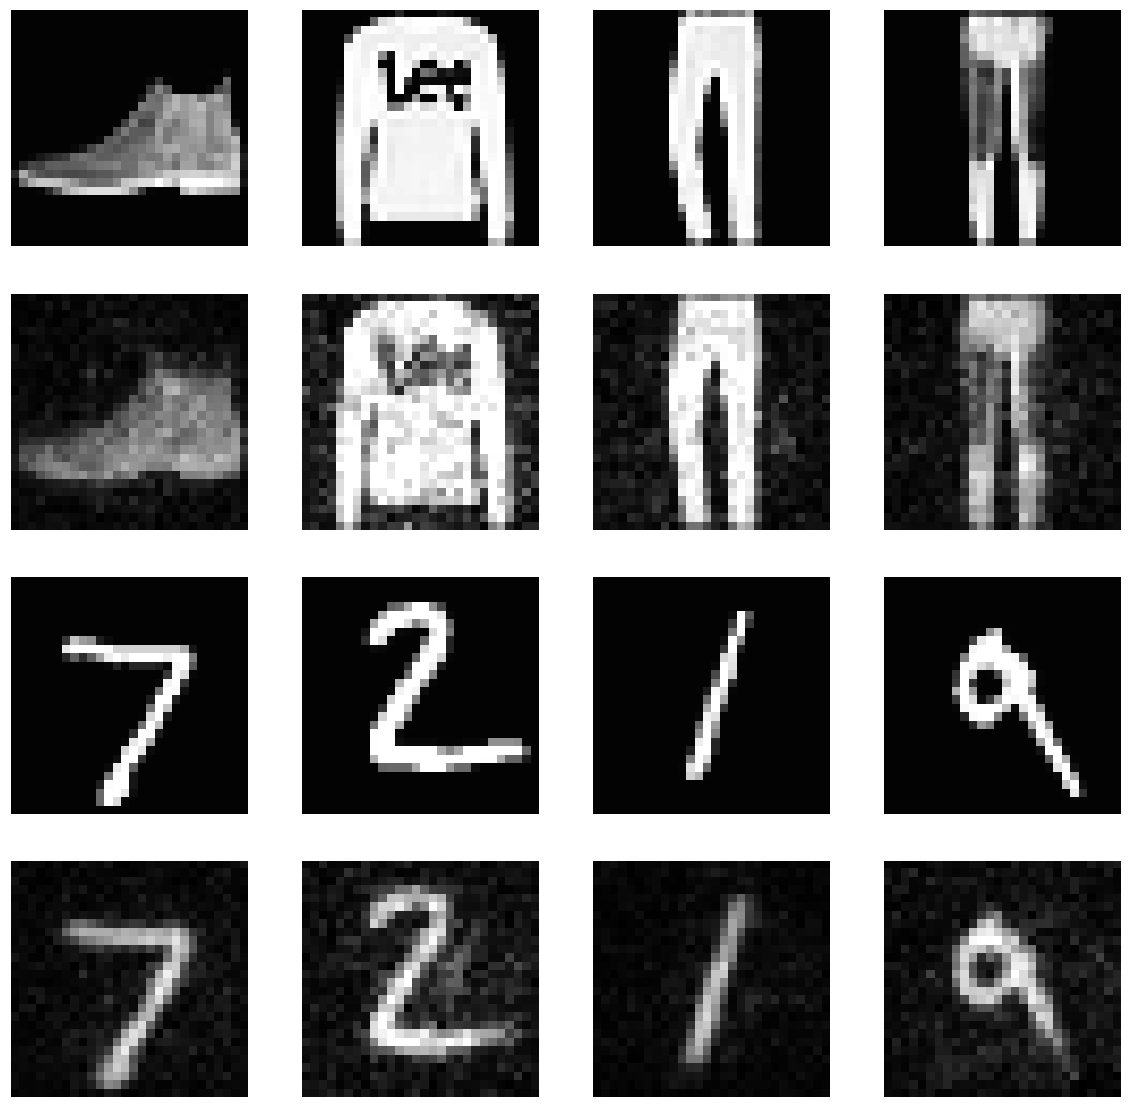

In [23]:
# now do the same for the l2 variant
model_name = 'comp_pyramid_l2'
weights_filepath = f'weights/{model_name}.h5'
model_chk = ModelCheckpoint(weights_filepath, monitor='mse', 
                            verbose=0, save_best_only=False, 
                            save_weights_only=True, mode='auto',
                            period=1)
t_b = TensorBoard(log_dir=f'./logs/{model_name}', histogram_freq=0, batch_size=32, 
                  write_graph=False, write_grads=False, write_images=False,
                  embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
#model.load_weights(weights_filepath)
mod_6l2.fit(x_train_ch,
          [y_train_p[0], y_train_p[1], y_train_p[2]],
          validation_data = (x_test_ch, [y_test_p[0], y_test_p[1], y_test_p[2]]),
          epochs = epochs,
          batch_size = batch_size,
          callbacks = [model_chk, reduce_lr, t_b, early_stop],
          shuffle = True,
         )
eval_and_display(mod_6l2, model_name, x_test_ch, [y_test_p[0], y_test_p[1], y_test_p[2]], vmax= 255.0)

6000/6000 [==============================] - 1s 196us/step
MSE for comp_pyramid_l2 = 937.1149291992188



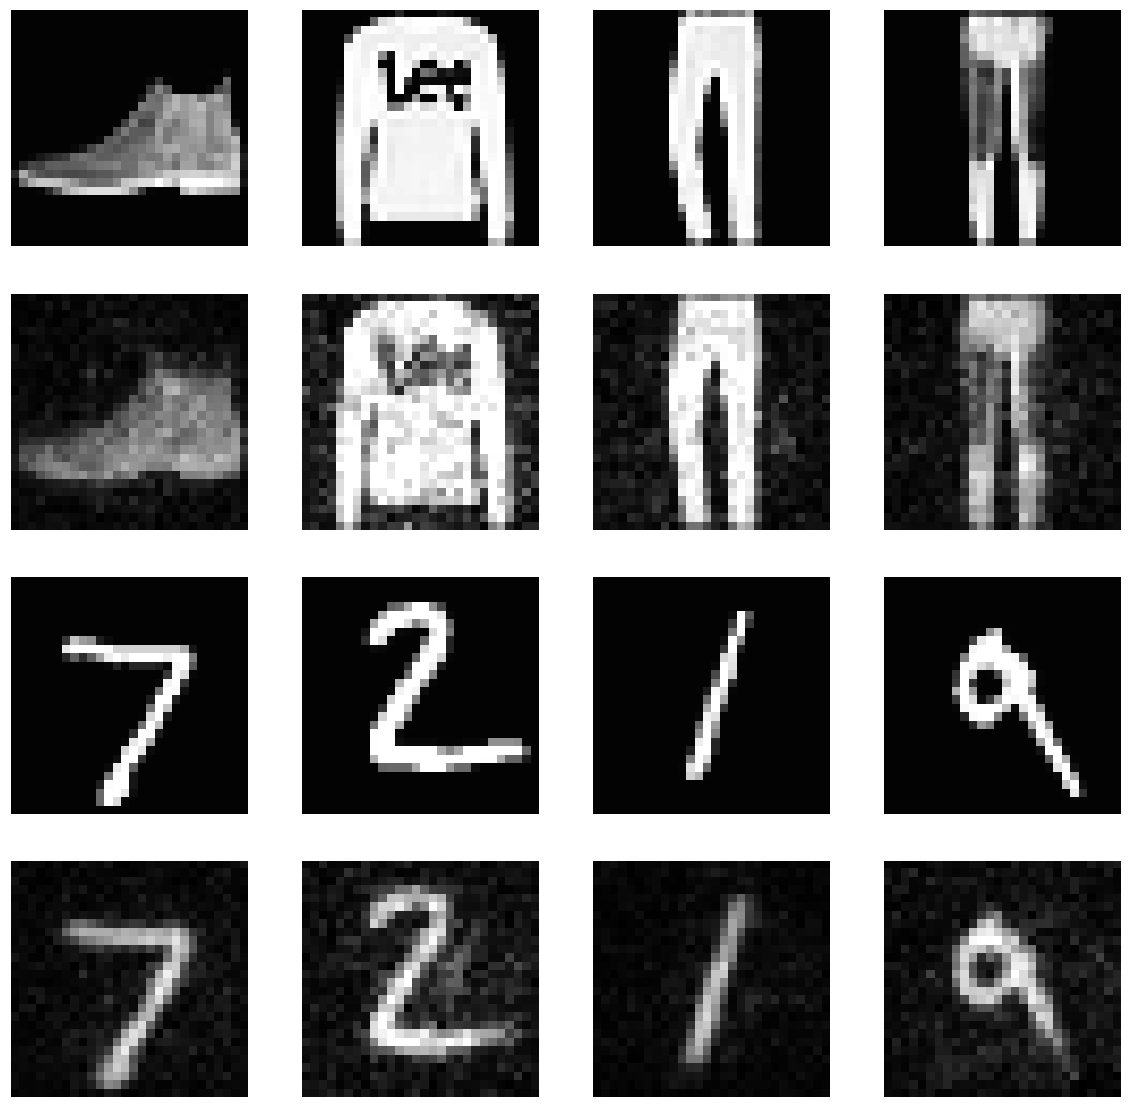

In [24]:
eval_and_display(mod_6l2, model_name, x_test_ch, [y_test_p[0], y_test_p[1], y_test_p[2]], vmax= 255.0)

In [26]:
# now do the same for the no_reg variant
model_name = 'comp_pyramid_no_reg'
weights_filepath = f'weights/{model_name}.h5'
model_chk = ModelCheckpoint(weights_filepath, monitor='mse', 
                            verbose=0, save_best_only=False, 
                            save_weights_only=True, mode='auto',
                            period=1)
t_b = TensorBoard(log_dir=f'./logs/{model_name}', histogram_freq=0, batch_size=32, 
                  write_graph=False, write_grads=False, write_images=False,
                  embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
#model.load_weights(weights_filepath)
mod_6noreg.fit(x_train_ch,
          [y_train_p[0], y_train_p[1], y_train_p[2]],
          validation_data = (x_test_ch, [y_test_p[0], y_test_p[1], y_test_p[2]]),
          epochs = epochs,
          batch_size = batch_size,
          callbacks = [model_chk, reduce_lr, t_b, early_stop],
          shuffle = True,
         )

Train on 44000 samples, validate on 6000 samples
Epoch 1/850
44000/44000 [==============================] - 18s 409us/step - loss: 9384.0819 - amplitude_11_loss: 5125.9775 - amplitude_12_loss: 2060.0344 - amplitude_13_loss: 2198.0700 - amplitude_11_mean_squared_error: 5125.9775 - amplitude_12_mean_squared_error: 2060.0344 - amplitude_13_mean_squared_error: 2198.0700 - val_loss: 5874.6030 - val_amplitude_11_loss: 2531.6498 - val_amplitude_12_loss: 1549.5931 - val_amplitude_13_loss: 1793.3600 - val_amplitude_11_mean_squared_error: 2531.6498 - val_amplitude_12_mean_squared_error: 1549.5931 - val_amplitude_13_mean_squared_error: 1793.3600
Epoch 2/850
44000/44000 [==============================] - 18s 405us/step - loss: 7569.7649 - amplitude_11_loss: 4452.6812 - amplitude_12_loss: 1489.5449 - amplitude_13_loss: 1627.5387 - amplitude_11_mean_squared_error: 4452.6812 - amplitude_12_mean_squared_error: 1489.5449 - amplitude_13_mean_squared_error: 1627.5387 - val_loss: 4775.8616 - val_amplitude

Epoch 15/850
44000/44000 [==============================] - 17s 395us/step - loss: 5181.7818 - amplitude_11_loss: 3276.1522 - amplitude_12_loss: 859.0383 - amplitude_13_loss: 1046.5913 - amplitude_11_mean_squared_error: 3276.1522 - amplitude_12_mean_squared_error: 859.0383 - amplitude_13_mean_squared_error: 1046.5913 - val_loss: 2842.4636 - val_amplitude_11_loss: 1324.7232 - val_amplitude_12_loss: 643.8238 - val_amplitude_13_loss: 873.9166 - val_amplitude_11_mean_squared_error: 1324.7232 - val_amplitude_12_mean_squared_error: 643.8238 - val_amplitude_13_mean_squared_error: 873.9166
Epoch 16/850
44000/44000 [==============================] - 18s 406us/step - loss: 5115.8769 - amplitude_11_loss: 3236.3025 - amplitude_12_loss: 844.8288 - amplitude_13_loss: 1034.7455 - amplitude_11_mean_squared_error: 3236.3025 - amplitude_12_mean_squared_error: 844.8288 - amplitude_13_mean_squared_error: 1034.7455 - val_loss: 2806.8484 - val_amplitude_11_loss: 1304.8764 - val_amplitude_12_loss: 632.3288 -

Epoch 29/850
44000/44000 [==============================] - 18s 399us/step - loss: 4524.7758 - amplitude_11_loss: 2863.9101 - amplitude_12_loss: 727.6604 - amplitude_13_loss: 933.2053 - amplitude_11_mean_squared_error: 2863.9101 - amplitude_12_mean_squared_error: 727.6604 - amplitude_13_mean_squared_error: 933.2053 - val_loss: 2522.8366 - val_amplitude_11_loss: 1180.1295 - val_amplitude_12_loss: 560.1390 - val_amplitude_13_loss: 782.5681 - val_amplitude_11_mean_squared_error: 1180.1295 - val_amplitude_12_mean_squared_error: 560.1390 - val_amplitude_13_mean_squared_error: 782.5681
Epoch 30/850
44000/44000 [==============================] - 17s 396us/step - loss: 4492.0985 - amplitude_11_loss: 2842.5068 - amplitude_12_loss: 721.6273 - amplitude_13_loss: 927.9644 - amplitude_11_mean_squared_error: 2842.5068 - amplitude_12_mean_squared_error: 721.6273 - amplitude_13_mean_squared_error: 927.9644 - val_loss: 2512.2735 - val_amplitude_11_loss: 1173.3904 - val_amplitude_12_loss: 556.2387 - val

Epoch 43/850
44000/44000 [==============================] - 17s 394us/step - loss: 4156.3261 - amplitude_11_loss: 2618.4614 - amplitude_12_loss: 661.7702 - amplitude_13_loss: 876.0945 - amplitude_11_mean_squared_error: 2618.4614 - amplitude_12_mean_squared_error: 661.7702 - amplitude_13_mean_squared_error: 876.0945 - val_loss: 2389.2809 - val_amplitude_11_loss: 1120.6121 - val_amplitude_12_loss: 523.9915 - val_amplitude_13_loss: 744.6773 - val_amplitude_11_mean_squared_error: 1120.6121 - val_amplitude_12_mean_squared_error: 523.9915 - val_amplitude_13_mean_squared_error: 744.6773
Epoch 44/850
44000/44000 [==============================] - 18s 398us/step - loss: 4135.3861 - amplitude_11_loss: 2604.4025 - amplitude_12_loss: 658.2132 - amplitude_13_loss: 872.7704 - amplitude_11_mean_squared_error: 2604.4025 - amplitude_12_mean_squared_error: 658.2132 - amplitude_13_mean_squared_error: 872.7704 - val_loss: 2390.6334 - val_amplitude_11_loss: 1119.3768 - val_amplitude_12_loss: 523.0674 - val

Epoch 57/850
44000/44000 [==============================] - 17s 395us/step - loss: 3906.9753 - amplitude_11_loss: 2448.0338 - amplitude_12_loss: 619.9033 - amplitude_13_loss: 839.0382 - amplitude_11_mean_squared_error: 2448.0338 - amplitude_12_mean_squared_error: 619.9033 - amplitude_13_mean_squared_error: 839.0382 - val_loss: 2320.2290 - val_amplitude_11_loss: 1087.4678 - val_amplitude_12_loss: 504.6164 - val_amplitude_13_loss: 728.1448 - val_amplitude_11_mean_squared_error: 1087.4678 - val_amplitude_12_mean_squared_error: 504.6164 - val_amplitude_13_mean_squared_error: 728.1448
Epoch 58/850
44000/44000 [==============================] - 17s 397us/step - loss: 3892.0673 - amplitude_11_loss: 2437.7259 - amplitude_12_loss: 617.4739 - amplitude_13_loss: 836.8675 - amplitude_11_mean_squared_error: 2437.7259 - amplitude_12_mean_squared_error: 617.4739 - amplitude_13_mean_squared_error: 836.8675 - val_loss: 2319.1778 - val_amplitude_11_loss: 1090.6792 - val_amplitude_12_loss: 508.1464 - val

Epoch 71/850
44000/44000 [==============================] - 18s 399us/step - loss: 3722.6045 - amplitude_11_loss: 2319.8449 - amplitude_12_loss: 590.1229 - amplitude_13_loss: 812.6367 - amplitude_11_mean_squared_error: 2319.8449 - amplitude_12_mean_squared_error: 590.1229 - amplitude_13_mean_squared_error: 812.6367 - val_loss: 2267.8328 - val_amplitude_11_loss: 1068.9211 - val_amplitude_12_loss: 490.1778 - val_amplitude_13_loss: 708.7338 - val_amplitude_11_mean_squared_error: 1068.9211 - val_amplitude_12_mean_squared_error: 490.1778 - val_amplitude_13_mean_squared_error: 708.7338
Epoch 72/850
44000/44000 [==============================] - 18s 398us/step - loss: 3711.1212 - amplitude_11_loss: 2311.8227 - amplitude_12_loss: 588.2999 - amplitude_13_loss: 810.9986 - amplitude_11_mean_squared_error: 2311.8227 - amplitude_12_mean_squared_error: 588.2999 - amplitude_13_mean_squared_error: 810.9986 - val_loss: 2272.9778 - val_amplitude_11_loss: 1069.8362 - val_amplitude_12_loss: 492.0194 - val

Epoch 85/850
44000/44000 [==============================] - 17s 397us/step - loss: 3578.2609 - amplitude_11_loss: 2218.5878 - amplitude_12_loss: 567.4457 - amplitude_13_loss: 792.2275 - amplitude_11_mean_squared_error: 2218.5878 - amplitude_12_mean_squared_error: 567.4457 - amplitude_13_mean_squared_error: 792.2275 - val_loss: 2231.6473 - val_amplitude_11_loss: 1056.7697 - val_amplitude_12_loss: 481.4791 - val_amplitude_13_loss: 693.3985 - val_amplitude_11_mean_squared_error: 1056.7697 - val_amplitude_12_mean_squared_error: 481.4791 - val_amplitude_13_mean_squared_error: 693.3985
Epoch 86/850
44000/44000 [==============================] - 18s 398us/step - loss: 3568.8496 - amplitude_11_loss: 2212.0607 - amplitude_12_loss: 566.0272 - amplitude_13_loss: 790.7618 - amplitude_11_mean_squared_error: 2212.0607 - amplitude_12_mean_squared_error: 566.0272 - amplitude_13_mean_squared_error: 790.7618 - val_loss: 2238.9912 - val_amplitude_11_loss: 1058.3568 - val_amplitude_12_loss: 482.2927 - val

Epoch 99/850
44000/44000 [==============================] - 17s 395us/step - loss: 3460.0594 - amplitude_11_loss: 2135.3705 - amplitude_12_loss: 549.1362 - amplitude_13_loss: 775.5527 - amplitude_11_mean_squared_error: 2135.3705 - amplitude_12_mean_squared_error: 549.1362 - amplitude_13_mean_squared_error: 775.5527 - val_loss: 2194.3445 - val_amplitude_11_loss: 1041.8168 - val_amplitude_12_loss: 469.1900 - val_amplitude_13_loss: 683.3377 - val_amplitude_11_mean_squared_error: 1041.8168 - val_amplitude_12_mean_squared_error: 469.1900 - val_amplitude_13_mean_squared_error: 683.3377
Epoch 100/850
44000/44000 [==============================] - 17s 397us/step - loss: 3452.6485 - amplitude_11_loss: 2130.0107 - amplitude_12_loss: 548.0095 - amplitude_13_loss: 774.6283 - amplitude_11_mean_squared_error: 2130.0107 - amplitude_12_mean_squared_error: 548.0095 - amplitude_13_mean_squared_error: 774.6283 - val_loss: 2199.8550 - val_amplitude_11_loss: 1044.3868 - val_amplitude_12_loss: 472.2349 - va

Epoch 113/850
44000/44000 [==============================] - 17s 396us/step - loss: 3361.6560 - amplitude_11_loss: 2065.6028 - amplitude_12_loss: 534.1756 - amplitude_13_loss: 761.8776 - amplitude_11_mean_squared_error: 2065.6028 - amplitude_12_mean_squared_error: 534.1756 - amplitude_13_mean_squared_error: 761.8776 - val_loss: 2177.2613 - val_amplitude_11_loss: 1035.6741 - val_amplitude_12_loss: 464.8530 - val_amplitude_13_loss: 676.7341 - val_amplitude_11_mean_squared_error: 1035.6741 - val_amplitude_12_mean_squared_error: 464.8530 - val_amplitude_13_mean_squared_error: 676.7341
Epoch 114/850
44000/44000 [==============================] - 17s 397us/step - loss: 3355.2438 - amplitude_11_loss: 2061.1653 - amplitude_12_loss: 533.2811 - amplitude_13_loss: 760.7975 - amplitude_11_mean_squared_error: 2061.1653 - amplitude_12_mean_squared_error: 533.2811 - amplitude_13_mean_squared_error: 760.7975 - val_loss: 2177.5817 - val_amplitude_11_loss: 1037.2496 - val_amplitude_12_loss: 464.1176 - v

Epoch 127/850
44000/44000 [==============================] - 17s 397us/step - loss: 3277.7301 - amplitude_11_loss: 2005.9812 - amplitude_12_loss: 521.5840 - amplitude_13_loss: 750.1650 - amplitude_11_mean_squared_error: 2005.9812 - amplitude_12_mean_squared_error: 521.5840 - amplitude_13_mean_squared_error: 750.1650 - val_loss: 2158.9713 - val_amplitude_11_loss: 1030.9498 - val_amplitude_12_loss: 459.0777 - val_amplitude_13_loss: 668.9438 - val_amplitude_11_mean_squared_error: 1030.9498 - val_amplitude_12_mean_squared_error: 459.0777 - val_amplitude_13_mean_squared_error: 668.9438
Epoch 128/850
44000/44000 [==============================] - 18s 398us/step - loss: 3271.8970 - amplitude_11_loss: 2001.8761 - amplitude_12_loss: 520.6175 - amplitude_13_loss: 749.4034 - amplitude_11_mean_squared_error: 2001.8761 - amplitude_12_mean_squared_error: 520.6175 - amplitude_13_mean_squared_error: 749.4034 - val_loss: 2157.3520 - val_amplitude_11_loss: 1029.3802 - val_amplitude_12_loss: 458.1302 - v

Epoch 141/850
44000/44000 [==============================] - 17s 397us/step - loss: 3204.2088 - amplitude_11_loss: 1953.7900 - amplitude_12_loss: 510.5535 - amplitude_13_loss: 739.8652 - amplitude_11_mean_squared_error: 1953.7900 - amplitude_12_mean_squared_error: 510.5535 - amplitude_13_mean_squared_error: 739.8652 - val_loss: 2150.5221 - val_amplitude_11_loss: 1026.9892 - val_amplitude_12_loss: 457.4102 - val_amplitude_13_loss: 666.1227 - val_amplitude_11_mean_squared_error: 1026.9892 - val_amplitude_12_mean_squared_error: 457.4102 - val_amplitude_13_mean_squared_error: 666.1227
Epoch 142/850
44000/44000 [==============================] - 17s 397us/step - loss: 3199.3504 - amplitude_11_loss: 1950.3386 - amplitude_12_loss: 509.8492 - amplitude_13_loss: 739.1626 - amplitude_11_mean_squared_error: 1950.3386 - amplitude_12_mean_squared_error: 509.8492 - amplitude_13_mean_squared_error: 739.1626 - val_loss: 2139.4022 - val_amplitude_11_loss: 1023.2298 - val_amplitude_12_loss: 453.0396 - v

Epoch 155/850
44000/44000 [==============================] - 17s 397us/step - loss: 3139.8017 - amplitude_11_loss: 1907.9195 - amplitude_12_loss: 501.0140 - amplitude_13_loss: 730.8683 - amplitude_11_mean_squared_error: 1907.9195 - amplitude_12_mean_squared_error: 501.0140 - amplitude_13_mean_squared_error: 730.8683 - val_loss: 2129.5515 - val_amplitude_11_loss: 1020.2721 - val_amplitude_12_loss: 450.4498 - val_amplitude_13_loss: 658.8296 - val_amplitude_11_mean_squared_error: 1020.2721 - val_amplitude_12_mean_squared_error: 450.4498 - val_amplitude_13_mean_squared_error: 658.8296
Epoch 156/850
44000/44000 [==============================] - 17s 397us/step - loss: 3135.4056 - amplitude_11_loss: 1904.8064 - amplitude_12_loss: 500.3570 - amplitude_13_loss: 730.2422 - amplitude_11_mean_squared_error: 1904.8064 - amplitude_12_mean_squared_error: 500.3570 - amplitude_13_mean_squared_error: 730.2422 - val_loss: 2129.3932 - val_amplitude_11_loss: 1022.4138 - val_amplitude_12_loss: 449.6959 - v

Epoch 169/850
44000/44000 [==============================] - 17s 396us/step - loss: 3082.3546 - amplitude_11_loss: 1866.9775 - amplitude_12_loss: 492.4971 - amplitude_13_loss: 722.8800 - amplitude_11_mean_squared_error: 1866.9775 - amplitude_12_mean_squared_error: 492.4971 - amplitude_13_mean_squared_error: 722.8800 - val_loss: 2123.3579 - val_amplitude_11_loss: 1019.8482 - val_amplitude_12_loss: 448.1274 - val_amplitude_13_loss: 655.3822 - val_amplitude_11_mean_squared_error: 1019.8482 - val_amplitude_12_mean_squared_error: 448.1274 - val_amplitude_13_mean_squared_error: 655.3822
Epoch 170/850
44000/44000 [==============================] - 18s 398us/step - loss: 3078.5100 - amplitude_11_loss: 1864.2211 - amplitude_12_loss: 491.9296 - amplitude_13_loss: 722.3593 - amplitude_11_mean_squared_error: 1864.2211 - amplitude_12_mean_squared_error: 491.9296 - amplitude_13_mean_squared_error: 722.3593 - val_loss: 2113.6655 - val_amplitude_11_loss: 1013.9625 - val_amplitude_12_loss: 444.3720 - v

Epoch 183/850
44000/44000 [==============================] - 17s 396us/step - loss: 3030.6172 - amplitude_11_loss: 1830.2060 - amplitude_12_loss: 484.9309 - amplitude_13_loss: 715.4804 - amplitude_11_mean_squared_error: 1830.2060 - amplitude_12_mean_squared_error: 484.9309 - amplitude_13_mean_squared_error: 715.4804 - val_loss: 2111.4440 - val_amplitude_11_loss: 1012.7973 - val_amplitude_12_loss: 441.9726 - val_amplitude_13_loss: 656.6740 - val_amplitude_11_mean_squared_error: 1012.7973 - val_amplitude_12_mean_squared_error: 441.9726 - val_amplitude_13_mean_squared_error: 656.6740
Epoch 184/850
44000/44000 [==============================] - 17s 398us/step - loss: 3027.3051 - amplitude_11_loss: 1827.7175 - amplitude_12_loss: 484.4104 - amplitude_13_loss: 715.1772 - amplitude_11_mean_squared_error: 1827.7175 - amplitude_12_mean_squared_error: 484.4104 - amplitude_13_mean_squared_error: 715.1772 - val_loss: 2102.6631 - val_amplitude_11_loss: 1011.5189 - val_amplitude_12_loss: 441.1040 - v

Epoch 197/850
44000/44000 [==============================] - 17s 388us/step - loss: 2983.7919 - amplitude_11_loss: 1796.8025 - amplitude_12_loss: 477.9983 - amplitude_13_loss: 708.9911 - amplitude_11_mean_squared_error: 1796.8025 - amplitude_12_mean_squared_error: 477.9983 - amplitude_13_mean_squared_error: 708.9911 - val_loss: 2092.1643 - val_amplitude_11_loss: 1008.2840 - val_amplitude_12_loss: 437.8613 - val_amplitude_13_loss: 646.0190 - val_amplitude_11_mean_squared_error: 1008.2840 - val_amplitude_12_mean_squared_error: 437.8613 - val_amplitude_13_mean_squared_error: 646.0190
Epoch 198/850
44000/44000 [==============================] - 17s 390us/step - loss: 2980.7826 - amplitude_11_loss: 1794.5563 - amplitude_12_loss: 477.6055 - amplitude_13_loss: 708.6208 - amplitude_11_mean_squared_error: 1794.5563 - amplitude_12_mean_squared_error: 477.6055 - amplitude_13_mean_squared_error: 708.6208 - val_loss: 2091.1103 - val_amplitude_11_loss: 1007.6937 - val_amplitude_12_loss: 437.6574 - v

Epoch 211/850
44000/44000 [==============================] - 17s 390us/step - loss: 2941.3037 - amplitude_11_loss: 1766.4508 - amplitude_12_loss: 471.8659 - amplitude_13_loss: 702.9870 - amplitude_11_mean_squared_error: 1766.4508 - amplitude_12_mean_squared_error: 471.8659 - amplitude_13_mean_squared_error: 702.9870 - val_loss: 2087.0020 - val_amplitude_11_loss: 1007.6857 - val_amplitude_12_loss: 436.5991 - val_amplitude_13_loss: 642.7173 - val_amplitude_11_mean_squared_error: 1007.6857 - val_amplitude_12_mean_squared_error: 436.5991 - val_amplitude_13_mean_squared_error: 642.7173
Epoch 212/850
44000/44000 [==============================] - 17s 391us/step - loss: 2938.4454 - amplitude_11_loss: 1764.3698 - amplitude_12_loss: 471.4070 - amplitude_13_loss: 702.6686 - amplitude_11_mean_squared_error: 1764.3698 - amplitude_12_mean_squared_error: 471.4070 - amplitude_13_mean_squared_error: 702.6686 - val_loss: 2077.5027 - val_amplitude_11_loss: 1001.6305 - val_amplitude_12_loss: 432.1911 - v

Epoch 225/850
44000/44000 [==============================] - 17s 388us/step - loss: 2902.1947 - amplitude_11_loss: 1738.4656 - amplitude_12_loss: 466.0673 - amplitude_13_loss: 697.6618 - amplitude_11_mean_squared_error: 1738.4656 - amplitude_12_mean_squared_error: 466.0673 - amplitude_13_mean_squared_error: 697.6618 - val_loss: 2077.8012 - val_amplitude_11_loss: 1002.7401 - val_amplitude_12_loss: 431.4520 - val_amplitude_13_loss: 643.6091 - val_amplitude_11_mean_squared_error: 1002.7401 - val_amplitude_12_mean_squared_error: 431.4520 - val_amplitude_13_mean_squared_error: 643.6091
Epoch 226/850
44000/44000 [==============================] - 17s 391us/step - loss: 2899.5202 - amplitude_11_loss: 1736.6199 - amplitude_12_loss: 465.6962 - amplitude_13_loss: 697.2042 - amplitude_11_mean_squared_error: 1736.6199 - amplitude_12_mean_squared_error: 465.6962 - amplitude_13_mean_squared_error: 697.2042 - val_loss: 2078.6077 - val_amplitude_11_loss: 1005.0084 - val_amplitude_12_loss: 433.5601 - v

Epoch 239/850
44000/44000 [==============================] - 17s 390us/step - loss: 2865.9413 - amplitude_11_loss: 1712.6588 - amplitude_12_loss: 460.7496 - amplitude_13_loss: 692.5328 - amplitude_11_mean_squared_error: 1712.6588 - amplitude_12_mean_squared_error: 460.7496 - amplitude_13_mean_squared_error: 692.5328 - val_loss: 2066.9900 - val_amplitude_11_loss: 1000.7364 - val_amplitude_12_loss: 429.6358 - val_amplitude_13_loss: 636.6178 - val_amplitude_11_mean_squared_error: 1000.7364 - val_amplitude_12_mean_squared_error: 429.6358 - val_amplitude_13_mean_squared_error: 636.6178
Epoch 240/850
44000/44000 [==============================] - 17s 393us/step - loss: 2863.4777 - amplitude_11_loss: 1710.8944 - amplitude_12_loss: 460.3834 - amplitude_13_loss: 692.2000 - amplitude_11_mean_squared_error: 1710.8944 - amplitude_12_mean_squared_error: 460.3834 - amplitude_13_mean_squared_error: 692.2000 - val_loss: 2070.5790 - val_amplitude_11_loss: 1002.9194 - val_amplitude_12_loss: 431.7694 - v

Epoch 253/850
44000/44000 [==============================] - 17s 388us/step - loss: 2832.5199 - amplitude_11_loss: 1688.8512 - amplitude_12_loss: 455.9232 - amplitude_13_loss: 687.7455 - amplitude_11_mean_squared_error: 1688.8512 - amplitude_12_mean_squared_error: 455.9232 - amplitude_13_mean_squared_error: 687.7455 - val_loss: 2055.9747 - val_amplitude_11_loss: 996.0825 - val_amplitude_12_loss: 426.1754 - val_amplitude_13_loss: 633.7167 - val_amplitude_11_mean_squared_error: 996.0825 - val_amplitude_12_mean_squared_error: 426.1754 - val_amplitude_13_mean_squared_error: 633.7167
Epoch 254/850
44000/44000 [==============================] - 17s 391us/step - loss: 2830.1851 - amplitude_11_loss: 1687.1409 - amplitude_12_loss: 455.5165 - amplitude_13_loss: 687.5276 - amplitude_11_mean_squared_error: 1687.1409 - amplitude_12_mean_squared_error: 455.5165 - amplitude_13_mean_squared_error: 687.5276 - val_loss: 2062.0568 - val_amplitude_11_loss: 999.5823 - val_amplitude_12_loss: 428.0928 - val_

Epoch 267/850
44000/44000 [==============================] - 17s 387us/step - loss: 2801.3927 - amplitude_11_loss: 1666.7268 - amplitude_12_loss: 451.4371 - amplitude_13_loss: 683.2288 - amplitude_11_mean_squared_error: 1666.7268 - amplitude_12_mean_squared_error: 451.4371 - amplitude_13_mean_squared_error: 683.2288 - val_loss: 2051.0369 - val_amplitude_11_loss: 994.6036 - val_amplitude_12_loss: 424.0133 - val_amplitude_13_loss: 632.4200 - val_amplitude_11_mean_squared_error: 994.6036 - val_amplitude_12_mean_squared_error: 424.0133 - val_amplitude_13_mean_squared_error: 632.4200
Epoch 268/850
44000/44000 [==============================] - 17s 392us/step - loss: 2799.1737 - amplitude_11_loss: 1665.0413 - amplitude_12_loss: 450.9903 - amplitude_13_loss: 683.1422 - amplitude_11_mean_squared_error: 1665.0413 - amplitude_12_mean_squared_error: 450.9903 - amplitude_13_mean_squared_error: 683.1422 - val_loss: 2055.4838 - val_amplitude_11_loss: 998.5561 - val_amplitude_12_loss: 427.4348 - val_

Epoch 281/850
44000/44000 [==============================] - 17s 388us/step - loss: 2772.2403 - amplitude_11_loss: 1645.9144 - amplitude_12_loss: 447.1332 - amplitude_13_loss: 679.1927 - amplitude_11_mean_squared_error: 1645.9144 - amplitude_12_mean_squared_error: 447.1332 - amplitude_13_mean_squared_error: 679.1927 - val_loss: 2048.2416 - val_amplitude_11_loss: 993.3088 - val_amplitude_12_loss: 423.3122 - val_amplitude_13_loss: 631.6206 - val_amplitude_11_mean_squared_error: 993.3088 - val_amplitude_12_mean_squared_error: 423.3122 - val_amplitude_13_mean_squared_error: 631.6206
Epoch 282/850
44000/44000 [==============================] - 17s 392us/step - loss: 2770.3818 - amplitude_11_loss: 1644.4660 - amplitude_12_loss: 446.8487 - amplitude_13_loss: 679.0671 - amplitude_11_mean_squared_error: 1644.4660 - amplitude_12_mean_squared_error: 446.8487 - amplitude_13_mean_squared_error: 679.0671 - val_loss: 2049.0299 - val_amplitude_11_loss: 993.6490 - val_amplitude_12_loss: 424.1796 - val_

Epoch 295/850
44000/44000 [==============================] - 17s 389us/step - loss: 2745.0263 - amplitude_11_loss: 1626.4658 - amplitude_12_loss: 443.1874 - amplitude_13_loss: 675.3731 - amplitude_11_mean_squared_error: 1626.4658 - amplitude_12_mean_squared_error: 443.1874 - amplitude_13_mean_squared_error: 675.3731 - val_loss: 2046.6657 - val_amplitude_11_loss: 994.7079 - val_amplitude_12_loss: 423.6948 - val_amplitude_13_loss: 628.2631 - val_amplitude_11_mean_squared_error: 994.7079 - val_amplitude_12_mean_squared_error: 423.6948 - val_amplitude_13_mean_squared_error: 628.2631
Epoch 296/850
44000/44000 [==============================] - 17s 393us/step - loss: 2743.1473 - amplitude_11_loss: 1625.0523 - amplitude_12_loss: 442.8330 - amplitude_13_loss: 675.2620 - amplitude_11_mean_squared_error: 1625.0523 - amplitude_12_mean_squared_error: 442.8330 - amplitude_13_mean_squared_error: 675.2620 - val_loss: 2040.8102 - val_amplitude_11_loss: 992.8488 - val_amplitude_12_loss: 421.3450 - val_

Epoch 309/850
44000/44000 [==============================] - 17s 389us/step - loss: 2719.4501 - amplitude_11_loss: 1608.2224 - amplitude_12_loss: 439.4265 - amplitude_13_loss: 671.8012 - amplitude_11_mean_squared_error: 1608.2224 - amplitude_12_mean_squared_error: 439.4265 - amplitude_13_mean_squared_error: 671.8012 - val_loss: 2039.6451 - val_amplitude_11_loss: 991.1704 - val_amplitude_12_loss: 419.4936 - val_amplitude_13_loss: 628.9811 - val_amplitude_11_mean_squared_error: 991.1704 - val_amplitude_12_mean_squared_error: 419.4936 - val_amplitude_13_mean_squared_error: 628.9811
Epoch 310/850
44000/44000 [==============================] - 18s 405us/step - loss: 2717.6653 - amplitude_11_loss: 1606.9566 - amplitude_12_loss: 439.1647 - amplitude_13_loss: 671.5440 - amplitude_11_mean_squared_error: 1606.9566 - amplitude_12_mean_squared_error: 439.1647 - amplitude_13_mean_squared_error: 671.5440 - val_loss: 2038.3300 - val_amplitude_11_loss: 992.2824 - val_amplitude_12_loss: 420.8186 - val_

Epoch 323/850
44000/44000 [==============================] - 17s 392us/step - loss: 2695.1895 - amplitude_11_loss: 1591.0222 - amplitude_12_loss: 435.9533 - amplitude_13_loss: 668.2139 - amplitude_11_mean_squared_error: 1591.0222 - amplitude_12_mean_squared_error: 435.9533 - amplitude_13_mean_squared_error: 668.2139 - val_loss: 2038.0332 - val_amplitude_11_loss: 989.4992 - val_amplitude_12_loss: 418.8103 - val_amplitude_13_loss: 629.7237 - val_amplitude_11_mean_squared_error: 989.4992 - val_amplitude_12_mean_squared_error: 418.8103 - val_amplitude_13_mean_squared_error: 629.7237
Epoch 324/850
44000/44000 [==============================] - 17s 389us/step - loss: 2693.5522 - amplitude_11_loss: 1589.7297 - amplitude_12_loss: 435.6566 - amplitude_13_loss: 668.1659 - amplitude_11_mean_squared_error: 1589.7297 - amplitude_12_mean_squared_error: 435.6566 - amplitude_13_mean_squared_error: 668.1659 - val_loss: 2022.6109 - val_amplitude_11_loss: 985.4355 - val_amplitude_12_loss: 415.9602 - val_

Epoch 337/850
44000/44000 [==============================] - 17s 388us/step - loss: 2672.4096 - amplitude_11_loss: 1574.7035 - amplitude_12_loss: 432.5608 - amplitude_13_loss: 665.1453 - amplitude_11_mean_squared_error: 1574.7035 - amplitude_12_mean_squared_error: 432.5608 - amplitude_13_mean_squared_error: 665.1453 - val_loss: 2026.2988 - val_amplitude_11_loss: 987.4138 - val_amplitude_12_loss: 417.3936 - val_amplitude_13_loss: 621.4914 - val_amplitude_11_mean_squared_error: 987.4138 - val_amplitude_12_mean_squared_error: 417.3936 - val_amplitude_13_mean_squared_error: 621.4914
Epoch 338/850
44000/44000 [==============================] - 17s 391us/step - loss: 2670.8641 - amplitude_11_loss: 1573.5870 - amplitude_12_loss: 432.3640 - amplitude_13_loss: 664.9131 - amplitude_11_mean_squared_error: 1573.5870 - amplitude_12_mean_squared_error: 432.3640 - amplitude_13_mean_squared_error: 664.9131 - val_loss: 2023.0893 - val_amplitude_11_loss: 986.3769 - val_amplitude_12_loss: 416.7025 - val_

Epoch 351/850
44000/44000 [==============================] - 17s 388us/step - loss: 2650.7988 - amplitude_11_loss: 1559.3491 - amplitude_12_loss: 429.4554 - amplitude_13_loss: 661.9943 - amplitude_11_mean_squared_error: 1559.3491 - amplitude_12_mean_squared_error: 429.4554 - amplitude_13_mean_squared_error: 661.9943 - val_loss: 2022.6498 - val_amplitude_11_loss: 986.0457 - val_amplitude_12_loss: 416.1289 - val_amplitude_13_loss: 620.4752 - val_amplitude_11_mean_squared_error: 986.0457 - val_amplitude_12_mean_squared_error: 416.1289 - val_amplitude_13_mean_squared_error: 620.4752
Epoch 352/850
44000/44000 [==============================] - 17s 392us/step - loss: 2649.1806 - amplitude_11_loss: 1558.2354 - amplitude_12_loss: 429.1937 - amplitude_13_loss: 661.7514 - amplitude_11_mean_squared_error: 1558.2354 - amplitude_12_mean_squared_error: 429.1937 - amplitude_13_mean_squared_error: 661.7514 - val_loss: 2021.3945 - val_amplitude_11_loss: 984.8002 - val_amplitude_12_loss: 415.3017 - val_

Epoch 365/850
44000/44000 [==============================] - 17s 390us/step - loss: 2630.1587 - amplitude_11_loss: 1544.7157 - amplitude_12_loss: 426.4399 - amplitude_13_loss: 659.0032 - amplitude_11_mean_squared_error: 1544.7157 - amplitude_12_mean_squared_error: 426.4399 - amplitude_13_mean_squared_error: 659.0032 - val_loss: 2022.2640 - val_amplitude_11_loss: 986.8284 - val_amplitude_12_loss: 417.1140 - val_amplitude_13_loss: 618.3216 - val_amplitude_11_mean_squared_error: 986.8284 - val_amplitude_12_mean_squared_error: 417.1140 - val_amplitude_13_mean_squared_error: 618.3216
Epoch 366/850
44000/44000 [==============================] - 17s 392us/step - loss: 2628.8766 - amplitude_11_loss: 1543.7380 - amplitude_12_loss: 426.2972 - amplitude_13_loss: 658.8413 - amplitude_11_mean_squared_error: 1543.7380 - amplitude_12_mean_squared_error: 426.2972 - amplitude_13_mean_squared_error: 658.8413 - val_loss: 2017.4084 - val_amplitude_11_loss: 985.3273 - val_amplitude_12_loss: 414.4172 - val_

Epoch 379/850
44000/44000 [==============================] - 17s 389us/step - loss: 2610.7111 - amplitude_11_loss: 1530.8253 - amplitude_12_loss: 423.6331 - amplitude_13_loss: 656.2527 - amplitude_11_mean_squared_error: 1530.8253 - amplitude_12_mean_squared_error: 423.6331 - amplitude_13_mean_squared_error: 656.2527 - val_loss: 2011.7223 - val_amplitude_11_loss: 982.1270 - val_amplitude_12_loss: 413.5716 - val_amplitude_13_loss: 616.0237 - val_amplitude_11_mean_squared_error: 982.1270 - val_amplitude_12_mean_squared_error: 413.5716 - val_amplitude_13_mean_squared_error: 616.0237
Epoch 380/850
44000/44000 [==============================] - 17s 394us/step - loss: 2609.3940 - amplitude_11_loss: 1529.8988 - amplitude_12_loss: 423.4654 - amplitude_13_loss: 656.0298 - amplitude_11_mean_squared_error: 1529.8988 - amplitude_12_mean_squared_error: 423.4654 - amplitude_13_mean_squared_error: 656.0298 - val_loss: 2014.9086 - val_amplitude_11_loss: 983.1559 - val_amplitude_12_loss: 414.0145 - val_

Epoch 393/850
44000/44000 [==============================] - 17s 392us/step - loss: 2592.2408 - amplitude_11_loss: 1517.6398 - amplitude_12_loss: 420.9370 - amplitude_13_loss: 653.6640 - amplitude_11_mean_squared_error: 1517.6398 - amplitude_12_mean_squared_error: 420.9370 - amplitude_13_mean_squared_error: 653.6640 - val_loss: 2008.4186 - val_amplitude_11_loss: 981.0131 - val_amplitude_12_loss: 411.2654 - val_amplitude_13_loss: 616.1401 - val_amplitude_11_mean_squared_error: 981.0131 - val_amplitude_12_mean_squared_error: 411.2654 - val_amplitude_13_mean_squared_error: 616.1401
Epoch 394/850
44000/44000 [==============================] - 17s 394us/step - loss: 2590.9617 - amplitude_11_loss: 1516.7191 - amplitude_12_loss: 420.7469 - amplitude_13_loss: 653.4958 - amplitude_11_mean_squared_error: 1516.7191 - amplitude_12_mean_squared_error: 420.7469 - amplitude_13_mean_squared_error: 653.4958 - val_loss: 2015.1185 - val_amplitude_11_loss: 983.6844 - val_amplitude_12_loss: 414.3308 - val_

Epoch 407/850
44000/44000 [==============================] - 17s 388us/step - loss: 2574.4910 - amplitude_11_loss: 1505.0546 - amplitude_12_loss: 418.3519 - amplitude_13_loss: 651.0845 - amplitude_11_mean_squared_error: 1505.0546 - amplitude_12_mean_squared_error: 418.3519 - amplitude_13_mean_squared_error: 651.0845 - val_loss: 2008.8337 - val_amplitude_11_loss: 980.3949 - val_amplitude_12_loss: 411.7710 - val_amplitude_13_loss: 616.6679 - val_amplitude_11_mean_squared_error: 980.3949 - val_amplitude_12_mean_squared_error: 411.7710 - val_amplitude_13_mean_squared_error: 616.6679
Epoch 408/850
44000/44000 [==============================] - 17s 392us/step - loss: 2573.1346 - amplitude_11_loss: 1504.1277 - amplitude_12_loss: 418.1618 - amplitude_13_loss: 650.8451 - amplitude_11_mean_squared_error: 1504.1277 - amplitude_12_mean_squared_error: 418.1618 - amplitude_13_mean_squared_error: 650.8451 - val_loss: 2000.6458 - val_amplitude_11_loss: 978.8854 - val_amplitude_12_loss: 410.0088 - val_

Epoch 421/850
44000/44000 [==============================] - 17s 388us/step - loss: 2557.3801 - amplitude_11_loss: 1492.9001 - amplitude_12_loss: 415.8450 - amplitude_13_loss: 648.6350 - amplitude_11_mean_squared_error: 1492.9001 - amplitude_12_mean_squared_error: 415.8450 - amplitude_13_mean_squared_error: 648.6350 - val_loss: 1997.9884 - val_amplitude_11_loss: 978.0499 - val_amplitude_12_loss: 408.5584 - val_amplitude_13_loss: 611.3800 - val_amplitude_11_mean_squared_error: 978.0499 - val_amplitude_12_mean_squared_error: 408.5584 - val_amplitude_13_mean_squared_error: 611.3800
Epoch 422/850
44000/44000 [==============================] - 17s 392us/step - loss: 2556.3520 - amplitude_11_loss: 1492.1896 - amplitude_12_loss: 415.7614 - amplitude_13_loss: 648.4010 - amplitude_11_mean_squared_error: 1492.1896 - amplitude_12_mean_squared_error: 415.7614 - amplitude_13_mean_squared_error: 648.4010 - val_loss: 2000.3769 - val_amplitude_11_loss: 979.8636 - val_amplitude_12_loss: 409.5013 - val_

Epoch 435/850
44000/44000 [==============================] - 17s 391us/step - loss: 2541.2700 - amplitude_11_loss: 1481.4383 - amplitude_12_loss: 413.5212 - amplitude_13_loss: 646.3105 - amplitude_11_mean_squared_error: 1481.4383 - amplitude_12_mean_squared_error: 413.5212 - amplitude_13_mean_squared_error: 646.3105 - val_loss: 2000.7400 - val_amplitude_11_loss: 977.5511 - val_amplitude_12_loss: 409.6111 - val_amplitude_13_loss: 613.5778 - val_amplitude_11_mean_squared_error: 977.5511 - val_amplitude_12_mean_squared_error: 409.6111 - val_amplitude_13_mean_squared_error: 613.5778
Epoch 436/850
44000/44000 [==============================] - 17s 393us/step - loss: 2540.0266 - amplitude_11_loss: 1480.6019 - amplitude_12_loss: 413.3386 - amplitude_13_loss: 646.0861 - amplitude_11_mean_squared_error: 1480.6019 - amplitude_12_mean_squared_error: 413.3386 - amplitude_13_mean_squared_error: 646.0861 - val_loss: 2002.2909 - val_amplitude_11_loss: 978.7271 - val_amplitude_12_loss: 410.6374 - val_

Epoch 449/850
44000/44000 [==============================] - 17s 388us/step - loss: 2525.5485 - amplitude_11_loss: 1470.3178 - amplitude_12_loss: 411.2380 - amplitude_13_loss: 643.9927 - amplitude_11_mean_squared_error: 1470.3178 - amplitude_12_mean_squared_error: 411.2380 - amplitude_13_mean_squared_error: 643.9927 - val_loss: 1986.2458 - val_amplitude_11_loss: 973.1601 - val_amplitude_12_loss: 404.4931 - val_amplitude_13_loss: 608.5926 - val_amplitude_11_mean_squared_error: 973.1601 - val_amplitude_12_mean_squared_error: 404.4931 - val_amplitude_13_mean_squared_error: 608.5926
Epoch 450/850
44000/44000 [==============================] - 17s 391us/step - loss: 2524.5994 - amplitude_11_loss: 1469.5828 - amplitude_12_loss: 411.0910 - amplitude_13_loss: 643.9255 - amplitude_11_mean_squared_error: 1469.5828 - amplitude_12_mean_squared_error: 411.0910 - amplitude_13_mean_squared_error: 643.9255 - val_loss: 1991.6456 - val_amplitude_11_loss: 973.6789 - val_amplitude_12_loss: 406.1443 - val_

Epoch 463/850
44000/44000 [==============================] - 17s 391us/step - loss: 2510.7333 - amplitude_11_loss: 1459.7767 - amplitude_12_loss: 409.1216 - amplitude_13_loss: 641.8350 - amplitude_11_mean_squared_error: 1459.7767 - amplitude_12_mean_squared_error: 409.1216 - amplitude_13_mean_squared_error: 641.8350 - val_loss: 1989.6573 - val_amplitude_11_loss: 974.8840 - val_amplitude_12_loss: 406.2318 - val_amplitude_13_loss: 608.5415 - val_amplitude_11_mean_squared_error: 974.8840 - val_amplitude_12_mean_squared_error: 406.2318 - val_amplitude_13_mean_squared_error: 608.5415
Epoch 464/850
44000/44000 [==============================] - 17s 392us/step - loss: 2509.7271 - amplitude_11_loss: 1459.0315 - amplitude_12_loss: 408.9652 - amplitude_13_loss: 641.7303 - amplitude_11_mean_squared_error: 1459.0315 - amplitude_12_mean_squared_error: 408.9652 - amplitude_13_mean_squared_error: 641.7303 - val_loss: 1994.9823 - val_amplitude_11_loss: 974.9782 - val_amplitude_12_loss: 407.1307 - val_

Epoch 477/850
44000/44000 [==============================] - 17s 392us/step - loss: 2496.4539 - amplitude_11_loss: 1449.6449 - amplitude_12_loss: 407.0407 - amplitude_13_loss: 639.7683 - amplitude_11_mean_squared_error: 1449.6449 - amplitude_12_mean_squared_error: 407.0407 - amplitude_13_mean_squared_error: 639.7683 - val_loss: 1984.7788 - val_amplitude_11_loss: 972.0530 - val_amplitude_12_loss: 404.4752 - val_amplitude_13_loss: 608.2507 - val_amplitude_11_mean_squared_error: 972.0530 - val_amplitude_12_mean_squared_error: 404.4752 - val_amplitude_13_mean_squared_error: 608.2507
Epoch 478/850
44000/44000 [==============================] - 17s 389us/step - loss: 2495.2944 - amplitude_11_loss: 1448.7935 - amplitude_12_loss: 406.7958 - amplitude_13_loss: 639.7051 - amplitude_11_mean_squared_error: 1448.7935 - amplitude_12_mean_squared_error: 406.7958 - amplitude_13_mean_squared_error: 639.7051 - val_loss: 1987.5616 - val_amplitude_11_loss: 971.4333 - val_amplitude_12_loss: 405.2980 - val_

Epoch 491/850
44000/44000 [==============================] - 17s 389us/step - loss: 2482.6894 - amplitude_11_loss: 1439.7410 - amplitude_12_loss: 404.9894 - amplitude_13_loss: 637.9591 - amplitude_11_mean_squared_error: 1439.7410 - amplitude_12_mean_squared_error: 404.9894 - amplitude_13_mean_squared_error: 637.9591 - val_loss: 1982.3384 - val_amplitude_11_loss: 971.2440 - val_amplitude_12_loss: 404.4877 - val_amplitude_13_loss: 606.6066 - val_amplitude_11_mean_squared_error: 971.2440 - val_amplitude_12_mean_squared_error: 404.4877 - val_amplitude_13_mean_squared_error: 606.6066
Epoch 492/850
44000/44000 [==============================] - 17s 392us/step - loss: 2481.4064 - amplitude_11_loss: 1439.0056 - amplitude_12_loss: 404.7948 - amplitude_13_loss: 637.6060 - amplitude_11_mean_squared_error: 1439.0056 - amplitude_12_mean_squared_error: 404.7948 - amplitude_13_mean_squared_error: 637.6060 - val_loss: 1981.0656 - val_amplitude_11_loss: 971.2665 - val_amplitude_12_loss: 403.9099 - val_

Epoch 505/850
44000/44000 [==============================] - 17s 390us/step - loss: 2469.1876 - amplitude_11_loss: 1430.3335 - amplitude_12_loss: 403.0460 - amplitude_13_loss: 635.8082 - amplitude_11_mean_squared_error: 1430.3335 - amplitude_12_mean_squared_error: 403.0460 - amplitude_13_mean_squared_error: 635.8082 - val_loss: 1979.6564 - val_amplitude_11_loss: 971.4407 - val_amplitude_12_loss: 404.1456 - val_amplitude_13_loss: 604.0701 - val_amplitude_11_mean_squared_error: 971.4407 - val_amplitude_12_mean_squared_error: 404.1456 - val_amplitude_13_mean_squared_error: 604.0701
Epoch 506/850
44000/44000 [==============================] - 17s 393us/step - loss: 2468.3360 - amplitude_11_loss: 1429.6495 - amplitude_12_loss: 402.9236 - amplitude_13_loss: 635.7630 - amplitude_11_mean_squared_error: 1429.6495 - amplitude_12_mean_squared_error: 402.9236 - amplitude_13_mean_squared_error: 635.7630 - val_loss: 1975.4559 - val_amplitude_11_loss: 968.0079 - val_amplitude_12_loss: 400.8960 - val_

Epoch 519/850
44000/44000 [==============================] - 17s 391us/step - loss: 2456.4651 - amplitude_11_loss: 1421.1545 - amplitude_12_loss: 401.1498 - amplitude_13_loss: 634.1609 - amplitude_11_mean_squared_error: 1421.1545 - amplitude_12_mean_squared_error: 401.1498 - amplitude_13_mean_squared_error: 634.1609 - val_loss: 1978.2474 - val_amplitude_11_loss: 969.8436 - val_amplitude_12_loss: 403.0447 - val_amplitude_13_loss: 605.3590 - val_amplitude_11_mean_squared_error: 969.8436 - val_amplitude_12_mean_squared_error: 403.0447 - val_amplitude_13_mean_squared_error: 605.3590
Epoch 520/850
44000/44000 [==============================] - 17s 393us/step - loss: 2455.5225 - amplitude_11_loss: 1420.5473 - amplitude_12_loss: 401.0297 - amplitude_13_loss: 633.9454 - amplitude_11_mean_squared_error: 1420.5473 - amplitude_12_mean_squared_error: 401.0297 - amplitude_13_mean_squared_error: 633.9454 - val_loss: 1974.1424 - val_amplitude_11_loss: 967.8946 - val_amplitude_12_loss: 401.0040 - val_

Epoch 533/850
44000/44000 [==============================] - 17s 391us/step - loss: 2444.0674 - amplitude_11_loss: 1412.4604 - amplitude_12_loss: 399.4115 - amplitude_13_loss: 632.1955 - amplitude_11_mean_squared_error: 1412.4604 - amplitude_12_mean_squared_error: 399.4115 - amplitude_13_mean_squared_error: 632.1955 - val_loss: 1974.3861 - val_amplitude_11_loss: 967.5180 - val_amplitude_12_loss: 401.9771 - val_amplitude_13_loss: 604.8910 - val_amplitude_11_mean_squared_error: 967.5180 - val_amplitude_12_mean_squared_error: 401.9771 - val_amplitude_13_mean_squared_error: 604.8910
Epoch 534/850
44000/44000 [==============================] - 17s 393us/step - loss: 2443.1844 - amplitude_11_loss: 1411.7891 - amplitude_12_loss: 399.2474 - amplitude_13_loss: 632.1479 - amplitude_11_mean_squared_error: 1411.7891 - amplitude_12_mean_squared_error: 399.2474 - amplitude_13_mean_squared_error: 632.1479 - val_loss: 1973.6475 - val_amplitude_11_loss: 967.9413 - val_amplitude_12_loss: 401.1676 - val_

Epoch 547/850
44000/44000 [==============================] - 17s 390us/step - loss: 2432.0372 - amplitude_11_loss: 1403.9439 - amplitude_12_loss: 397.6361 - amplitude_13_loss: 630.4572 - amplitude_11_mean_squared_error: 1403.9439 - amplitude_12_mean_squared_error: 397.6361 - amplitude_13_mean_squared_error: 630.4572 - val_loss: 1965.0267 - val_amplitude_11_loss: 965.1460 - val_amplitude_12_loss: 398.7998 - val_amplitude_13_loss: 601.0809 - val_amplitude_11_mean_squared_error: 965.1460 - val_amplitude_12_mean_squared_error: 398.7998 - val_amplitude_13_mean_squared_error: 601.0809
Epoch 548/850
44000/44000 [==============================] - 17s 391us/step - loss: 2431.2150 - amplitude_11_loss: 1403.3394 - amplitude_12_loss: 397.5129 - amplitude_13_loss: 630.3627 - amplitude_11_mean_squared_error: 1403.3394 - amplitude_12_mean_squared_error: 397.5129 - amplitude_13_mean_squared_error: 630.3627 - val_loss: 1968.8146 - val_amplitude_11_loss: 966.5089 - val_amplitude_12_loss: 400.3612 - val_

Epoch 561/850
44000/44000 [==============================] - 17s 387us/step - loss: 2420.4780 - amplitude_11_loss: 1395.7557 - amplitude_12_loss: 395.9567 - amplitude_13_loss: 628.7656 - amplitude_11_mean_squared_error: 1395.7557 - amplitude_12_mean_squared_error: 395.9567 - amplitude_13_mean_squared_error: 628.7656 - val_loss: 1970.6784 - val_amplitude_11_loss: 966.2531 - val_amplitude_12_loss: 400.2914 - val_amplitude_13_loss: 604.1339 - val_amplitude_11_mean_squared_error: 966.2531 - val_amplitude_12_mean_squared_error: 400.2914 - val_amplitude_13_mean_squared_error: 604.1339
Epoch 562/850
44000/44000 [==============================] - 17s 391us/step - loss: 2419.7071 - amplitude_11_loss: 1395.1953 - amplitude_12_loss: 395.8437 - amplitude_13_loss: 628.6682 - amplitude_11_mean_squared_error: 1395.1953 - amplitude_12_mean_squared_error: 395.8437 - amplitude_13_mean_squared_error: 628.6682 - val_loss: 1967.5703 - val_amplitude_11_loss: 966.6418 - val_amplitude_12_loss: 400.5625 - val_

Epoch 575/850
44000/44000 [==============================] - 17s 390us/step - loss: 2409.2249 - amplitude_11_loss: 1387.7331 - amplitude_12_loss: 394.2417 - amplitude_13_loss: 627.2501 - amplitude_11_mean_squared_error: 1387.7331 - amplitude_12_mean_squared_error: 394.2417 - amplitude_13_mean_squared_error: 627.2501 - val_loss: 1968.4827 - val_amplitude_11_loss: 966.6563 - val_amplitude_12_loss: 400.0452 - val_amplitude_13_loss: 601.7812 - val_amplitude_11_mean_squared_error: 966.6563 - val_amplitude_12_mean_squared_error: 400.0452 - val_amplitude_13_mean_squared_error: 601.7812
Epoch 576/850
44000/44000 [==============================] - 17s 394us/step - loss: 2408.5021 - amplitude_11_loss: 1387.2809 - amplitude_12_loss: 394.2112 - amplitude_13_loss: 627.0100 - amplitude_11_mean_squared_error: 1387.2809 - amplitude_12_mean_squared_error: 394.2112 - amplitude_13_mean_squared_error: 627.0100 - val_loss: 1963.1223 - val_amplitude_11_loss: 966.0323 - val_amplitude_12_loss: 399.8603 - val_

Epoch 589/850
44000/44000 [==============================] - 17s 389us/step - loss: 2398.5031 - amplitude_11_loss: 1380.1971 - amplitude_12_loss: 392.7855 - amplitude_13_loss: 625.5204 - amplitude_11_mean_squared_error: 1380.1971 - amplitude_12_mean_squared_error: 392.7855 - amplitude_13_mean_squared_error: 625.5204 - val_loss: 1959.2576 - val_amplitude_11_loss: 962.3091 - val_amplitude_12_loss: 396.4950 - val_amplitude_13_loss: 600.4535 - val_amplitude_11_mean_squared_error: 962.3091 - val_amplitude_12_mean_squared_error: 396.4950 - val_amplitude_13_mean_squared_error: 600.4535
Epoch 590/850
44000/44000 [==============================] - 17s 392us/step - loss: 2397.6898 - amplitude_11_loss: 1379.5859 - amplitude_12_loss: 392.6172 - amplitude_13_loss: 625.4868 - amplitude_11_mean_squared_error: 1379.5859 - amplitude_12_mean_squared_error: 392.6172 - amplitude_13_mean_squared_error: 625.4868 - val_loss: 1959.1340 - val_amplitude_11_loss: 962.9079 - val_amplitude_12_loss: 397.1186 - val_

Epoch 603/850
44000/44000 [==============================] - 17s 388us/step - loss: 2387.9071 - amplitude_11_loss: 1372.6867 - amplitude_12_loss: 391.2197 - amplitude_13_loss: 624.0007 - amplitude_11_mean_squared_error: 1372.6867 - amplitude_12_mean_squared_error: 391.2197 - amplitude_13_mean_squared_error: 624.0007 - val_loss: 1956.5537 - val_amplitude_11_loss: 963.4014 - val_amplitude_12_loss: 397.2482 - val_amplitude_13_loss: 595.9041 - val_amplitude_11_mean_squared_error: 963.4014 - val_amplitude_12_mean_squared_error: 397.2482 - val_amplitude_13_mean_squared_error: 595.9041
Epoch 604/850
44000/44000 [==============================] - 17s 391us/step - loss: 2387.1122 - amplitude_11_loss: 1372.1607 - amplitude_12_loss: 391.0719 - amplitude_13_loss: 623.8796 - amplitude_11_mean_squared_error: 1372.1607 - amplitude_12_mean_squared_error: 391.0719 - amplitude_13_mean_squared_error: 623.8796 - val_loss: 1957.2683 - val_amplitude_11_loss: 961.3698 - val_amplitude_12_loss: 396.5447 - val_

Epoch 617/850
44000/44000 [==============================] - 17s 388us/step - loss: 2377.7811 - amplitude_11_loss: 1365.4574 - amplitude_12_loss: 389.7187 - amplitude_13_loss: 622.6049 - amplitude_11_mean_squared_error: 1365.4574 - amplitude_12_mean_squared_error: 389.7187 - amplitude_13_mean_squared_error: 622.6049 - val_loss: 1952.9006 - val_amplitude_11_loss: 959.6920 - val_amplitude_12_loss: 395.8595 - val_amplitude_13_loss: 597.3491 - val_amplitude_11_mean_squared_error: 959.6920 - val_amplitude_12_mean_squared_error: 395.8595 - val_amplitude_13_mean_squared_error: 597.3491
Epoch 618/850
44000/44000 [==============================] - 17s 390us/step - loss: 2377.1543 - amplitude_11_loss: 1365.0330 - amplitude_12_loss: 389.6709 - amplitude_13_loss: 622.4505 - amplitude_11_mean_squared_error: 1365.0330 - amplitude_12_mean_squared_error: 389.6709 - amplitude_13_mean_squared_error: 622.4505 - val_loss: 1952.2242 - val_amplitude_11_loss: 960.4902 - val_amplitude_12_loss: 396.5185 - val_

Epoch 631/850
44000/44000 [==============================] - 17s 389us/step - loss: 2367.8982 - amplitude_11_loss: 1358.5046 - amplitude_12_loss: 388.2876 - amplitude_13_loss: 621.1060 - amplitude_11_mean_squared_error: 1358.5046 - amplitude_12_mean_squared_error: 388.2876 - amplitude_13_mean_squared_error: 621.1060 - val_loss: 1952.9938 - val_amplitude_11_loss: 960.1032 - val_amplitude_12_loss: 396.2241 - val_amplitude_13_loss: 596.6665 - val_amplitude_11_mean_squared_error: 960.1032 - val_amplitude_12_mean_squared_error: 396.2241 - val_amplitude_13_mean_squared_error: 596.6665
Epoch 632/850
44000/44000 [==============================] - 17s 393us/step - loss: 2367.1752 - amplitude_11_loss: 1357.9910 - amplitude_12_loss: 388.1467 - amplitude_13_loss: 621.0375 - amplitude_11_mean_squared_error: 1357.9910 - amplitude_12_mean_squared_error: 388.1467 - amplitude_13_mean_squared_error: 621.0375 - val_loss: 1956.2856 - val_amplitude_11_loss: 959.5171 - val_amplitude_12_loss: 396.2626 - val_

Epoch 645/850
44000/44000 [==============================] - 17s 391us/step - loss: 2358.2197 - amplitude_11_loss: 1351.6215 - amplitude_12_loss: 386.8003 - amplitude_13_loss: 619.7979 - amplitude_11_mean_squared_error: 1351.6215 - amplitude_12_mean_squared_error: 386.8003 - amplitude_13_mean_squared_error: 619.7979 - val_loss: 1949.7236 - val_amplitude_11_loss: 959.0633 - val_amplitude_12_loss: 394.5100 - val_amplitude_13_loss: 596.1503 - val_amplitude_11_mean_squared_error: 959.0633 - val_amplitude_12_mean_squared_error: 394.5100 - val_amplitude_13_mean_squared_error: 596.1503
Epoch 646/850
44000/44000 [==============================] - 17s 391us/step - loss: 2357.5402 - amplitude_11_loss: 1351.1962 - amplitude_12_loss: 386.7692 - amplitude_13_loss: 619.5748 - amplitude_11_mean_squared_error: 1351.1962 - amplitude_12_mean_squared_error: 386.7692 - amplitude_13_mean_squared_error: 619.5748 - val_loss: 1950.3072 - val_amplitude_11_loss: 959.5877 - val_amplitude_12_loss: 395.2320 - val_

Epoch 659/850
44000/44000 [==============================] - 17s 390us/step - loss: 2348.9062 - amplitude_11_loss: 1345.0957 - amplitude_12_loss: 385.5011 - amplitude_13_loss: 618.3094 - amplitude_11_mean_squared_error: 1345.0957 - amplitude_12_mean_squared_error: 385.5011 - amplitude_13_mean_squared_error: 618.3094 - val_loss: 1954.7868 - val_amplitude_11_loss: 958.9854 - val_amplitude_12_loss: 395.9066 - val_amplitude_13_loss: 599.8949 - val_amplitude_11_mean_squared_error: 958.9854 - val_amplitude_12_mean_squared_error: 395.9066 - val_amplitude_13_mean_squared_error: 599.8949
Epoch 660/850
44000/44000 [==============================] - 17s 392us/step - loss: 2348.3460 - amplitude_11_loss: 1344.6157 - amplitude_12_loss: 385.4072 - amplitude_13_loss: 618.3231 - amplitude_11_mean_squared_error: 1344.6157 - amplitude_12_mean_squared_error: 385.4072 - amplitude_13_mean_squared_error: 618.3231 - val_loss: 1953.4347 - val_amplitude_11_loss: 958.8983 - val_amplitude_12_loss: 395.1092 - val_

Epoch 673/850
44000/44000 [==============================] - 17s 390us/step - loss: 2339.8114 - amplitude_11_loss: 1338.6548 - amplitude_12_loss: 384.1617 - amplitude_13_loss: 616.9949 - amplitude_11_mean_squared_error: 1338.6548 - amplitude_12_mean_squared_error: 384.1617 - amplitude_13_mean_squared_error: 616.9949 - val_loss: 1940.8815 - val_amplitude_11_loss: 955.1080 - val_amplitude_12_loss: 392.1929 - val_amplitude_13_loss: 593.5807 - val_amplitude_11_mean_squared_error: 955.1080 - val_amplitude_12_mean_squared_error: 392.1929 - val_amplitude_13_mean_squared_error: 593.5807
Epoch 674/850
44000/44000 [==============================] - 17s 393us/step - loss: 2339.1981 - amplitude_11_loss: 1338.2097 - amplitude_12_loss: 384.1000 - amplitude_13_loss: 616.8884 - amplitude_11_mean_squared_error: 1338.2097 - amplitude_12_mean_squared_error: 384.1000 - amplitude_13_mean_squared_error: 616.8884 - val_loss: 1949.2790 - val_amplitude_11_loss: 957.9062 - val_amplitude_12_loss: 394.3822 - val_

Epoch 687/850
44000/44000 [==============================] - 17s 388us/step - loss: 2331.1699 - amplitude_11_loss: 1332.4848 - amplitude_12_loss: 382.9415 - amplitude_13_loss: 615.7436 - amplitude_11_mean_squared_error: 1332.4848 - amplitude_12_mean_squared_error: 382.9415 - amplitude_13_mean_squared_error: 615.7436 - val_loss: 1943.9632 - val_amplitude_11_loss: 955.1173 - val_amplitude_12_loss: 392.7128 - val_amplitude_13_loss: 596.1332 - val_amplitude_11_mean_squared_error: 955.1173 - val_amplitude_12_mean_squared_error: 392.7128 - val_amplitude_13_mean_squared_error: 596.1332
Epoch 688/850
44000/44000 [==============================] - 17s 391us/step - loss: 2330.4131 - amplitude_11_loss: 1331.9643 - amplitude_12_loss: 382.7853 - amplitude_13_loss: 615.6634 - amplitude_11_mean_squared_error: 1331.9643 - amplitude_12_mean_squared_error: 382.7853 - amplitude_13_mean_squared_error: 615.6634 - val_loss: 1942.4630 - val_amplitude_11_loss: 956.3471 - val_amplitude_12_loss: 392.6083 - val_

Epoch 701/850
44000/44000 [==============================] - 17s 390us/step - loss: 2322.5943 - amplitude_11_loss: 1326.4180 - amplitude_12_loss: 381.6943 - amplitude_13_loss: 614.4820 - amplitude_11_mean_squared_error: 1326.4180 - amplitude_12_mean_squared_error: 381.6943 - amplitude_13_mean_squared_error: 614.4820 - val_loss: 1936.3481 - val_amplitude_11_loss: 953.3083 - val_amplitude_12_loss: 390.9704 - val_amplitude_13_loss: 592.0694 - val_amplitude_11_mean_squared_error: 953.3083 - val_amplitude_12_mean_squared_error: 390.9704 - val_amplitude_13_mean_squared_error: 592.0694
Epoch 702/850
44000/44000 [==============================] - 17s 392us/step - loss: 2321.8567 - amplitude_11_loss: 1325.9369 - amplitude_12_loss: 381.5546 - amplitude_13_loss: 614.3651 - amplitude_11_mean_squared_error: 1325.9369 - amplitude_12_mean_squared_error: 381.5546 - amplitude_13_mean_squared_error: 614.3651 - val_loss: 1941.6578 - val_amplitude_11_loss: 955.8143 - val_amplitude_12_loss: 392.6418 - val_

Epoch 715/850
44000/44000 [==============================] - 17s 389us/step - loss: 2314.0610 - amplitude_11_loss: 1320.4310 - amplitude_12_loss: 380.4111 - amplitude_13_loss: 613.2189 - amplitude_11_mean_squared_error: 1320.4310 - amplitude_12_mean_squared_error: 380.4111 - amplitude_13_mean_squared_error: 613.2189 - val_loss: 1935.2073 - val_amplitude_11_loss: 954.0915 - val_amplitude_12_loss: 391.1929 - val_amplitude_13_loss: 589.9228 - val_amplitude_11_mean_squared_error: 954.0915 - val_amplitude_12_mean_squared_error: 391.1929 - val_amplitude_13_mean_squared_error: 589.9228
Epoch 716/850
44000/44000 [==============================] - 17s 393us/step - loss: 2313.4862 - amplitude_11_loss: 1320.0808 - amplitude_12_loss: 380.3865 - amplitude_13_loss: 613.0189 - amplitude_11_mean_squared_error: 1320.0808 - amplitude_12_mean_squared_error: 380.3865 - amplitude_13_mean_squared_error: 613.0189 - val_loss: 1937.3529 - val_amplitude_11_loss: 951.5446 - val_amplitude_12_loss: 389.7658 - val_

Epoch 729/850
44000/44000 [==============================] - 17s 388us/step - loss: 2306.0120 - amplitude_11_loss: 1314.7133 - amplitude_12_loss: 379.2423 - amplitude_13_loss: 612.0564 - amplitude_11_mean_squared_error: 1314.7133 - amplitude_12_mean_squared_error: 379.2423 - amplitude_13_mean_squared_error: 612.0564 - val_loss: 1936.0584 - val_amplitude_11_loss: 952.6901 - val_amplitude_12_loss: 390.3684 - val_amplitude_13_loss: 592.9999 - val_amplitude_11_mean_squared_error: 952.6901 - val_amplitude_12_mean_squared_error: 390.3684 - val_amplitude_13_mean_squared_error: 592.9999
Epoch 730/850
44000/44000 [==============================] - 17s 392us/step - loss: 2305.4221 - amplitude_11_loss: 1314.2777 - amplitude_12_loss: 379.1455 - amplitude_13_loss: 611.9989 - amplitude_11_mean_squared_error: 1314.2777 - amplitude_12_mean_squared_error: 379.1455 - amplitude_13_mean_squared_error: 611.9989 - val_loss: 1938.1919 - val_amplitude_11_loss: 954.0951 - val_amplitude_12_loss: 392.6983 - val_

Epoch 743/850
44000/44000 [==============================] - 17s 390us/step - loss: 2298.0248 - amplitude_11_loss: 1309.1054 - amplitude_12_loss: 378.1148 - amplitude_13_loss: 610.8045 - amplitude_11_mean_squared_error: 1309.1054 - amplitude_12_mean_squared_error: 378.1148 - amplitude_13_mean_squared_error: 610.8045 - val_loss: 1937.0440 - val_amplitude_11_loss: 953.1029 - val_amplitude_12_loss: 391.2281 - val_amplitude_13_loss: 592.7130 - val_amplitude_11_mean_squared_error: 953.1029 - val_amplitude_12_mean_squared_error: 391.2281 - val_amplitude_13_mean_squared_error: 592.7130
Epoch 744/850
44000/44000 [==============================] - 17s 395us/step - loss: 2297.4777 - amplitude_11_loss: 1308.6881 - amplitude_12_loss: 377.9604 - amplitude_13_loss: 610.8292 - amplitude_11_mean_squared_error: 1308.6881 - amplitude_12_mean_squared_error: 377.9604 - amplitude_13_mean_squared_error: 610.8292 - val_loss: 1935.1873 - val_amplitude_11_loss: 952.3541 - val_amplitude_12_loss: 390.4103 - val_

Epoch 757/850
44000/44000 [==============================] - 17s 390us/step - loss: 2290.3414 - amplitude_11_loss: 1303.5697 - amplitude_12_loss: 376.9350 - amplitude_13_loss: 609.8368 - amplitude_11_mean_squared_error: 1303.5697 - amplitude_12_mean_squared_error: 376.9350 - amplitude_13_mean_squared_error: 609.8368 - val_loss: 1930.9085 - val_amplitude_11_loss: 950.2425 - val_amplitude_12_loss: 389.4625 - val_amplitude_13_loss: 591.2034 - val_amplitude_11_mean_squared_error: 950.2425 - val_amplitude_12_mean_squared_error: 389.4625 - val_amplitude_13_mean_squared_error: 591.2034
Epoch 758/850
44000/44000 [==============================] - 17s 391us/step - loss: 2289.7461 - amplitude_11_loss: 1303.2350 - amplitude_12_loss: 376.8829 - amplitude_13_loss: 609.6281 - amplitude_11_mean_squared_error: 1303.2350 - amplitude_12_mean_squared_error: 376.8829 - amplitude_13_mean_squared_error: 609.6281 - val_loss: 1932.6681 - val_amplitude_11_loss: 950.3892 - val_amplitude_12_loss: 389.8670 - val_

Epoch 771/850
44000/44000 [==============================] - 17s 387us/step - loss: 2282.7264 - amplitude_11_loss: 1298.2097 - amplitude_12_loss: 375.8036 - amplitude_13_loss: 608.7131 - amplitude_11_mean_squared_error: 1298.2097 - amplitude_12_mean_squared_error: 375.8036 - amplitude_13_mean_squared_error: 608.7131 - val_loss: 1931.7003 - val_amplitude_11_loss: 951.7524 - val_amplitude_12_loss: 390.9976 - val_amplitude_13_loss: 588.9503 - val_amplitude_11_mean_squared_error: 951.7524 - val_amplitude_12_mean_squared_error: 390.9976 - val_amplitude_13_mean_squared_error: 588.9503
Epoch 772/850
44000/44000 [==============================] - 17s 392us/step - loss: 2282.1725 - amplitude_11_loss: 1297.8955 - amplitude_12_loss: 375.7772 - amplitude_13_loss: 608.4998 - amplitude_11_mean_squared_error: 1297.8955 - amplitude_12_mean_squared_error: 375.7772 - amplitude_13_mean_squared_error: 608.4998 - val_loss: 1930.1842 - val_amplitude_11_loss: 951.1291 - val_amplitude_12_loss: 389.4185 - val_

Epoch 785/850
44000/44000 [==============================] - 17s 390us/step - loss: 2275.4713 - amplitude_11_loss: 1293.1237 - amplitude_12_loss: 374.8114 - amplitude_13_loss: 607.5363 - amplitude_11_mean_squared_error: 1293.1237 - amplitude_12_mean_squared_error: 374.8114 - amplitude_13_mean_squared_error: 607.5363 - val_loss: 1928.5018 - val_amplitude_11_loss: 949.4571 - val_amplitude_12_loss: 388.9721 - val_amplitude_13_loss: 590.0726 - val_amplitude_11_mean_squared_error: 949.4571 - val_amplitude_12_mean_squared_error: 388.9721 - val_amplitude_13_mean_squared_error: 590.0726
Epoch 786/850
44000/44000 [==============================] - 17s 391us/step - loss: 2274.8728 - amplitude_11_loss: 1292.7338 - amplitude_12_loss: 374.7118 - amplitude_13_loss: 607.4272 - amplitude_11_mean_squared_error: 1292.7338 - amplitude_12_mean_squared_error: 374.7118 - amplitude_13_mean_squared_error: 607.4272 - val_loss: 1924.8479 - val_amplitude_11_loss: 948.4995 - val_amplitude_12_loss: 387.6554 - val_

Epoch 799/850
44000/44000 [==============================] - 17s 390us/step - loss: 2268.1759 - amplitude_11_loss: 1288.0117 - amplitude_12_loss: 373.7453 - amplitude_13_loss: 606.4188 - amplitude_11_mean_squared_error: 1288.0117 - amplitude_12_mean_squared_error: 373.7453 - amplitude_13_mean_squared_error: 606.4188 - val_loss: 1925.9288 - val_amplitude_11_loss: 949.2243 - val_amplitude_12_loss: 388.4231 - val_amplitude_13_loss: 588.2814 - val_amplitude_11_mean_squared_error: 949.2243 - val_amplitude_12_mean_squared_error: 388.4231 - val_amplitude_13_mean_squared_error: 588.2814
Epoch 800/850
44000/44000 [==============================] - 17s 392us/step - loss: 2267.6471 - amplitude_11_loss: 1287.6117 - amplitude_12_loss: 373.6097 - amplitude_13_loss: 606.4257 - amplitude_11_mean_squared_error: 1287.6117 - amplitude_12_mean_squared_error: 373.6097 - amplitude_13_mean_squared_error: 606.4257 - val_loss: 1922.1783 - val_amplitude_11_loss: 947.3652 - val_amplitude_12_loss: 387.2632 - val_

Epoch 813/850
44000/44000 [==============================] - 17s 392us/step - loss: 2261.1479 - amplitude_11_loss: 1282.9631 - amplitude_12_loss: 372.6434 - amplitude_13_loss: 605.5414 - amplitude_11_mean_squared_error: 1282.9631 - amplitude_12_mean_squared_error: 372.6434 - amplitude_13_mean_squared_error: 605.5414 - val_loss: 1932.2132 - val_amplitude_11_loss: 951.5420 - val_amplitude_12_loss: 391.1873 - val_amplitude_13_loss: 589.4839 - val_amplitude_11_mean_squared_error: 951.5420 - val_amplitude_12_mean_squared_error: 391.1873 - val_amplitude_13_mean_squared_error: 589.4839
Epoch 814/850
44000/44000 [==============================] - 17s 392us/step - loss: 2260.6790 - amplitude_11_loss: 1282.6370 - amplitude_12_loss: 372.5932 - amplitude_13_loss: 605.4487 - amplitude_11_mean_squared_error: 1282.6370 - amplitude_12_mean_squared_error: 372.5932 - amplitude_13_mean_squared_error: 605.4487 - val_loss: 1921.8398 - val_amplitude_11_loss: 947.9419 - val_amplitude_12_loss: 387.0624 - val_

Epoch 827/850
44000/44000 [==============================] - 17s 391us/step - loss: 2254.2547 - amplitude_11_loss: 1278.1069 - amplitude_12_loss: 371.6447 - amplitude_13_loss: 604.5031 - amplitude_11_mean_squared_error: 1278.1069 - amplitude_12_mean_squared_error: 371.6447 - amplitude_13_mean_squared_error: 604.5031 - val_loss: 1927.0872 - val_amplitude_11_loss: 949.7713 - val_amplitude_12_loss: 388.8900 - val_amplitude_13_loss: 588.4260 - val_amplitude_11_mean_squared_error: 949.7713 - val_amplitude_12_mean_squared_error: 388.8900 - val_amplitude_13_mean_squared_error: 588.4260
Epoch 828/850
44000/44000 [==============================] - 17s 393us/step - loss: 2253.7750 - amplitude_11_loss: 1277.8301 - amplitude_12_loss: 371.6220 - amplitude_13_loss: 604.3229 - amplitude_11_mean_squared_error: 1277.8301 - amplitude_12_mean_squared_error: 371.6220 - amplitude_13_mean_squared_error: 604.3229 - val_loss: 1924.3994 - val_amplitude_11_loss: 946.7800 - val_amplitude_12_loss: 387.1787 - val_

Epoch 841/850
44000/44000 [==============================] - 17s 389us/step - loss: 2247.5140 - amplitude_11_loss: 1273.3905 - amplitude_12_loss: 370.6835 - amplitude_13_loss: 603.4401 - amplitude_11_mean_squared_error: 1273.3905 - amplitude_12_mean_squared_error: 370.6835 - amplitude_13_mean_squared_error: 603.4401 - val_loss: 1918.7933 - val_amplitude_11_loss: 945.0204 - val_amplitude_12_loss: 386.4737 - val_amplitude_13_loss: 587.2991 - val_amplitude_11_mean_squared_error: 945.0204 - val_amplitude_12_mean_squared_error: 386.4737 - val_amplitude_13_mean_squared_error: 587.2991
Epoch 842/850
44000/44000 [==============================] - 17s 394us/step - loss: 2246.9960 - amplitude_11_loss: 1273.0299 - amplitude_12_loss: 370.5808 - amplitude_13_loss: 603.3853 - amplitude_11_mean_squared_error: 1273.0299 - amplitude_12_mean_squared_error: 370.5808 - amplitude_13_mean_squared_error: 603.3853 - val_loss: 1920.6674 - val_amplitude_11_loss: 946.5057 - val_amplitude_12_loss: 386.9400 - val_

6000/6000 [==============================] - 1s 192us/step
MSE for comp_pyramid_no_reg = 947.2723693847656



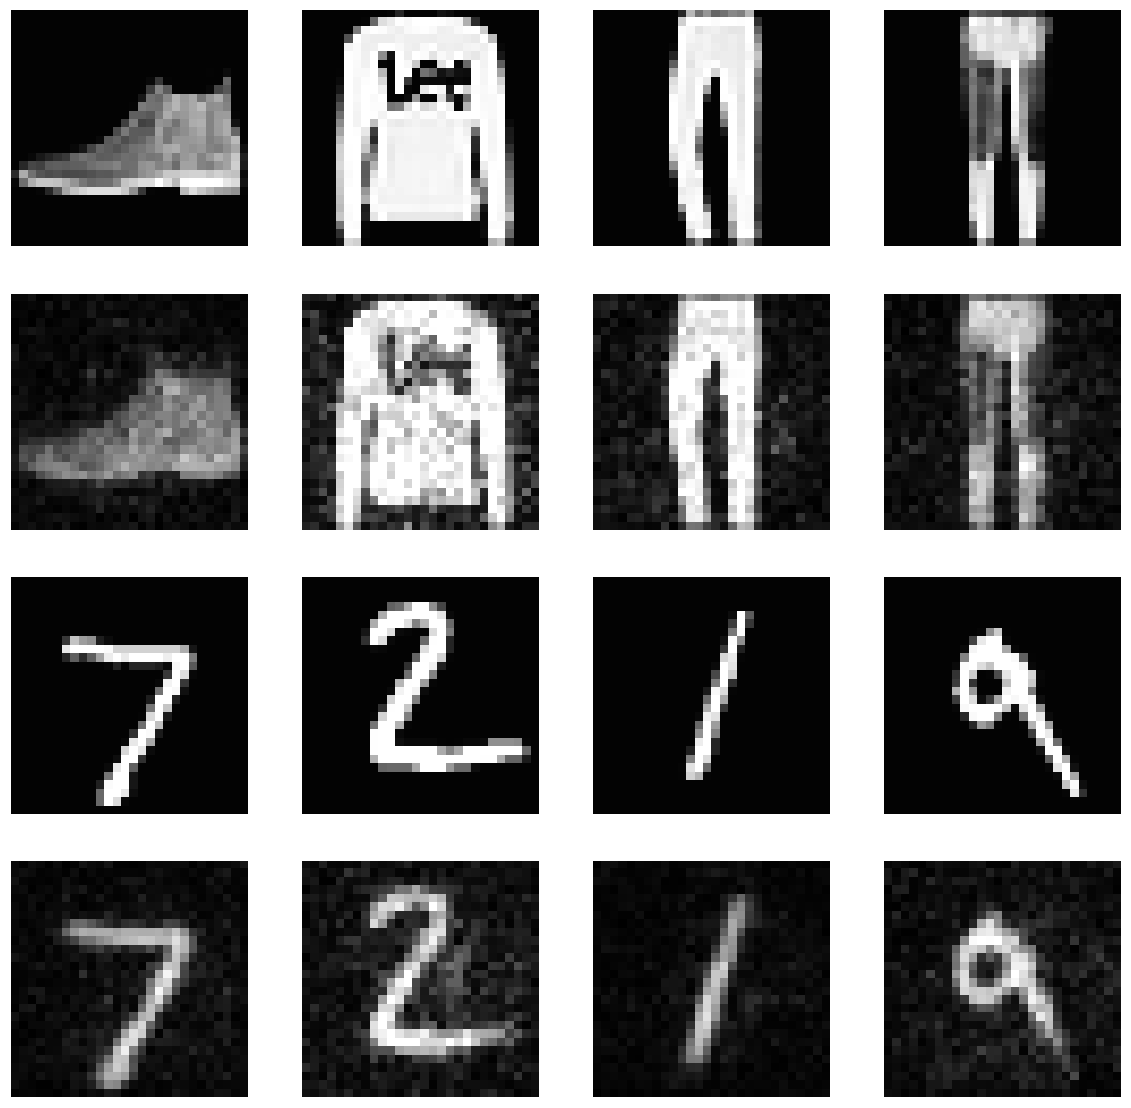

In [27]:
eval_and_display(mod_6noreg, model_name, x_test_ch, [y_test_p[0], y_test_p[1], y_test_p[2]], vmax= 255.0)

In [ ]:
%%time
epochs = 700
models = {  
             'comp_sq_no_reg': mod_5snu,
      'comp_sq_un_reg': mod_5s,
   #       'comp_l2_reg': mod_4,
   #       'real_no_reg': mod_1,

    #       'comp_no_reg': mod_3,
      #     'real_l2_reg': mod_2,
     #          'comp_un_reg': mod_5,
     #      'comp_un_reg2': mod_52,
         }

for model_name, model in models.items():
    weights_filepath = f'weights/{model_name}.h5'
    # Setup callbacks
    model_chk = ModelCheckpoint(weights_filepath, monitor='mse', 
                                verbose=0, save_best_only=False, 
                                save_weights_only=True, mode='auto',
                                period=1)

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                                  patience=2, min_lr=lr/1e3,
                                  verbose=1)
    
    early_stop = EarlyStopping(monitor='loss', min_delta=0.0001, patience=8)
    
    t_b = TensorBoard(log_dir=f'./logs/{model_name}', histogram_freq=0, batch_size=32, 
                      write_graph=False, write_grads=False, write_images=False,
                      embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
    
    #model.load_weights(weights_filepath)

    # Train
    model.fit(x_train_ch, 
              y_train, #[y_train, y_train_phase],
              validation_data = (x_test_ch, y_test),#[y_test, y_test_phase]),
              epochs = epochs,
              batch_size = batch_size,
              callbacks = [model_chk, reduce_lr, t_b, early_stop],
              shuffle = True)

    eval_and_display(model, model_name, x_test_ch, y_test, vmax= 255.0)

# End of table
with open("tables/MSE.txt", "a") as file:
    file.write("\\bottomrule\n"
               "\\end{tabular}\n"
               "\\end{table}")

eval_and_display(model, model_name, x_test_ch, y_test, vmax= 255.0)

Train on 44000 samples, validate on 6000 samples
Epoch 1/700
44000/44000 [==============================] - 14s 309us/step - loss: 7041.5567 - mean_squared_error: 7041.5567 - val_loss: 4926.4615 - val_mean_squared_error: 4926.4615
Epoch 2/700
44000/44000 [==============================] - 14s 308us/step - loss: 6328.2354 - mean_squared_error: 6328.2354 - val_loss: 4579.5457 - val_mean_squared_error: 4579.5457
Epoch 3/700
44000/44000 [==============================] - 14s 309us/step - loss: 6113.2720 - mean_squared_error: 6113.2720 - val_loss: 4354.6699 - val_mean_squared_error: 4354.6699
Epoch 4/700
44000/44000 [==============================] - 14s 307us/step - loss: 5951.4891 - mean_squared_error: 5951.4891 - val_loss: 4165.1478 - val_mean_squared_error: 4165.1478
Epoch 5/700
44000/44000 [==============================] - 13s 306us/step - loss: 5824.0138 - mean_squared_error: 5824.0138 - val_loss: 4021.8949 - val_mean_squared_error: 4021.8949
Epoch 6/700
44000/44000 [================

In [ ]:
eval_and_display(model, model_name, x_test_ch, y_test, vmax= 255.0)

In [ ]:
W = model.get_weights()[0]
T = W[:,:,0]+1j*W[:,:,1]
Ti = np.conj(T).T
d1 = np.dot(Ti,T)
d2 = np.dot(T,Ti)
plt.figure()
plt.imshow(np.absolute(d1))
plt.figure()
plt.imshow(np.absolute(d2))
print(np.sum(np.absolute(d1)))
print(np.sum(np.absolute(d2)))
print(np.min(d1))
print(np.absolute(d1[0:10,0:10]))
print(np.absolute(d2[0:10,0:10]))

#F = model.get_weights()
f = model.layers[1].get_weights()[0]
print (np.shape(f))
#plt.figure()
#plt.imshow(F)


## Figure 6 - MSE & SSIM investigation

In [ ]:
# Reshape output to be compatible with SSIM
#y_train = np.expand_dims(y_train, -1).reshape(-1, 28, 28, 1)
#y_test = np.expand_dims(y_test, -1).reshape(-1, 28, 28, 1)

### Model trained to convergence with MSE

In [ ]:
# if you haven't already run this you can re-run it.
inp_4 = Input(shape=(image_dim*image_dim, 2))
lay_4 = ComplexDense(28*28, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(inp_4)
had_4 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_4)
out_4 = Amplitude()(had_4)
#out_ph4 = Phase()(had_4)
mod_4 = Model(inputs=inp_4, outputs=out_4)#, out_ph4])

mod_4.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse'])
mod_4.summary()

In [ ]:
# we have probably already trained this model, so just load it
model = mod_4
model_name = "comp_l2_reg"
weights_filepath = f'weights/{model_name}.h5'
model.load_weights(weights_filepath)

In [ ]:
# run this if you haven't already trained it.
%%time
epochs = 1000
# Setup callbacks
model_chk = ModelCheckpoint(weights_filepath, monitor='mse', 
                            verbose=0, save_best_only=False, 
                            save_weights_only=True, mode='auto',
                            period=1)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=lr/1e3,
                              verbose=1,)

t_b = TensorBoard(log_dir=f'./logs/{model_name}', histogram_freq=0, batch_size=32, 
                  write_graph=False, write_grads=False, write_images=False,
                  embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

model.load_weights(weights_filepath)
# Train
model.fit(x_train_ch, 
          y_train,
          validation_data = (x_test_ch, y_test),
          epochs = epochs,
          batch_size = batch_size,
          callbacks = [model_chk, reduce_lr, t_b, early_stop],
          shuffle = True,
         )

In [ ]:
model_name = "MSE"
eval_and_display(model, model_name, x_test_ch, y_test, vmax= 255.0)
model_name = "comp_l2_reg"

### Training the same model further using SSIM

In [ ]:
epochs = 1000
inp_7 = Input(shape=(image_dim*image_dim, 2))
lay_7 = ComplexDense(28*28, use_bias=False, kernel_regularizer=regularizers.l2(lamb))(inp_7)
had_7 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(lay_7)
lay_7 = Amplitude()(had_7)
out_7 = Reshape((28,28,1))(lay_7) # reshape for compatability with SSIM
mod_7 = Model(inputs=inp_7, outputs=[out_7])

mod_7.load_weights(weights_filepath) # Load weights from the model trained with just MSE
mod_7.compile(optimizer=SGD(lr=lr), loss=DSSIMObjective(), metrics=['mse',])
mod_7.summary()

In [ ]:
%%time

model = mod_7
model_name = "MSE_then_SSIM"
weights_filepath = f'weights/{model_name}.h5'
model.load_weights(weights_filepath)
# Setup callbacks
model_chk = ModelCheckpoint(weights_filepath, monitor='mse', 
                            verbose=0, save_best_only=False, 
                            save_weights_only=True, mode='auto',
                            period=1)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=lr/1e3,
                              verbose=1,)

t_b = TensorBoard(log_dir=f'./logs/{model_name}', histogram_freq=0, batch_size=32, 
                  write_graph=False, write_grads=False, write_images=False,
                  embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

# Train
model.fit(x_train_ch, 
          np.reshape(y_train, (np.shape(y_train)[0],28, 28,1)),
          validation_data = (x_test_ch, np.reshape( y_test, (np.shape(y_test)[0],28, 28,1))),
          epochs = epochs,
          batch_size = batch_size,
          callbacks = [model_chk, reduce_lr, t_b, early_stop],
          shuffle = True,
         )
eval_and_display(model, model_name, x_test_ch, np.reshape( y_test, (np.shape(y_test)[0],28, 28,1)), vmax= 255.0)


In [ ]:
eval_and_display(model, model_name, x_test_ch, np.reshape( y_test, (np.shape(y_test)[0],28, 28,1)), vmax= 255.0)

## Figure 7 - Impact of speckle resolution on reconstructed image

In [6]:
epochs = 1500
lr = 1e-5
batch_size = 32
lamb = 0.03
image_dims = [14*(2**x) for x in range(5)]

rows = 3
cols = len(image_dims)
ex = 3001 # "Lee" top
images = [None]*cols*rows

#### Loading Phase and Amplitude & Hadamard Layer

In [7]:
#Import phase and amplitude
from scipy import interpolate
experimentalAmp   = np.load(my_path + 'amplitude.npy')
experimentalPhase = np.load(my_path + 'phase.npy')
experimentalPhase = np.append(experimentalPhase, experimentalPhase[-2] ) # add in missing datapoint

x1 = np.arange(0.0,101.0)/100.0
x2 = np.arange(0.0,101.0)/100.0
print(len(experimentalPhase), len(x2))
testx = np.arange(0.0,100.0,0.5)/100.0
fSLMamp = interpolate.interp1d(x1, experimentalAmp/np.max(experimentalAmp))
fSLMphase = interpolate.interp1d(x2, experimentalPhase)


class Hadamard2(Layer):
    # creates a custom layer for elementwise multiplying every element of a vector by another weight vector
    # assumes input is complex in separate real and imaginary channels
    def __init__(self, kernel_constraint=None, **kwargs):
        super(Hadamard2, self).__init__(**kwargs)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
 
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(1,input_shape[1]),
                                      initializer=keras.initializers.Constant(value=1.0),
                                      constraint=self.kernel_constraint,
                                      trainable=True)
        super(Hadamard2, self).build(input_shape)  # Be sure to call this somewhere!
 
    def call(self, x):
        if tf.keras.backend.ndim(x) == 3:
            return complex_to_channels(channels_to_complex(x) * 
                                       tf.complex(self.kernel, 0*self.kernel))
        else:
            return x*self.kernel
        
    def get_config(self):
        config = {
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint)
        }
        base_config = super(Hadamard2, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
 
    def compute_output_shape(self, input_shape):
        return input_shape


101 101


In [ ]:
%%time


##
out_dim = 28
speckle_dim = 112 #56
image_dim = speckle_dim
Use_root    = False
phase_shift = False


file_location = 'Data_1m.h5'
hf = h5py.File( my_path + file_location , 'r')



# Original/input image filenames
orig_img_filenames =  {'digi': 'Training/Original_images/MNIST',
                      'fash': 'Training/Original_images/Fashion-MNIST',
                      'rand': 'Training/Original_images/Random Patterns',
                 'fash_test': 'Testing/Original_images/MNIST',
                 'digi_test': 'Testing/Original_images/Fashion-MNIST',
                      'punc': 'Testing/Original_images/Muybridge Punch'}

orig_imgs = {dataset: None for dataset in orig_img_filenames}


for dataset, filename in orig_img_filenames.items():
    # Load
    fl = hf[filename]
    orig_imgs[dataset] =  np.array(fl)



################################################################################


    
for idx, image_dim in enumerate(image_dims):
    print(f"=============================================")
    print(f"COMMENCING RESOLUTION {image_dim}x{image_dim}")
    print(f"---------------------------------------------")
    
    model_name = f'multi_resolution_{image_dim}x{image_dim}'

    ## TRAIN
    # Group 
  

    ## TRAIN
    y_train = np.concatenate((orig_imgs['digi'],
                              orig_imgs['fash'],
                              orig_imgs['rand'],
                             ))

    y_train = np.squeeze(y_train.reshape(-1, 28*28, 1))

## TEST
    y_test = np.concatenate((orig_imgs['digi_test'],
                             orig_imgs['fash_test'],))

    y_test = np.squeeze(y_test.reshape(-1, 28*28, 1))




# Load and resize all datasets

# Original/input image filenames
    speckle_img_filenames =  {'digi': 'Training/Speckle_images/MNIST',
                      'fash': 'Training/Speckle_images/Fashion-MNIST',
                      'rand': 'Training/Speckle_images/Random Patterns',
                 'fash_test': 'Testing/Speckle_images/MNIST',
                 'digi_test': 'Testing/Speckle_images/Fashion-MNIST',
                      'punc': 'Testing/Speckle_images/Muybridge Punch'}

    data_dict = {dataset: None for dataset in speckle_img_filenames}


# import speckle images and resize them from 224 to the chosen speckle_dim
    for dataset, filename in speckle_img_filenames.items():
        print(f"Loading {dataset} ...")
        # Load
        fl = hf[filename]
        data_dict[dataset] =  np.array(fl)
        # To resize we recover the original image shape
        Data_resize = np.reshape(data_dict[dataset], (data_dict[dataset].shape[0],224,224) )
        Data_temp = np.zeros((data_dict[dataset].shape[0],image_dim*image_dim))
        # Resize
        for im in range(data_dict[dataset].shape[0]):
    
            Data_temp[im] = np.reshape(cv2.resize(Data_resize[im], dsize=(image_dim, image_dim), interpolation=cv2.INTER_AREA), (image_dim*image_dim))
    
        data_dict[dataset] = Data_temp            
        del Data_temp, Data_resize
        gc.collect()



    #TRAIN
    x_train = np.concatenate((data_dict['digi'],
                          data_dict['fash'],
                          data_dict['rand'],
                         ))
    # TEST
    x_test = np.concatenate((data_dict['digi_test'], data_dict['fash_test'],))


    x_train_ch = real_to_channels_np(x_train.astype('float32'))
    x_test_ch  = real_to_channels_np(x_test.astype('float32'))

   
    
    
    y_train_phase = fSLMphase(y_train)*255.0
    y_test_phase  = fSLMphase(y_test)*255.0
    y_train       = fSLMamp(y_train)*255.0
    y_test        = fSLMamp(y_test)*255.0

    # Single Layer
    input_img = Input(shape=(image_dim*image_dim, 2))
    l = input_img
    l = ComplexDense(28*28, use_bias=False, 
                     #kernel_regularizer=unitary_reg(lamb)
                     kernel_regularizer=regularizers.l2(lamb)
                     #kernel_regularizer=amplitude_reg_l2(lamb)
                    )(l)
    l = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=1.0, 
                                                                     rate=1.0, axis=0))(l)
    
    l = Amplitude()(l)
    #l = keras.layers.PReLU()(l)
    out_layer = l
    model = Model(inputs=input_img, outputs=[out_layer])

    ## Train
    weights_filepath = f"weights/{model_name}.h5"
    #model.load_weights(weights_filepath)

    ## Compile Model
    model.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse',])

    # Callbacks
    model_chk = ModelCheckpoint(weights_filepath, monitor='mse', 
                                verbose=0, save_best_only=False, 
                                save_weights_only=True, mode='auto',
                                period=1)

    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                                  patience=2, min_lr=lr/1e3,
                                  verbose=1,)

    t_b = TensorBoard(log_dir=f'./logs/{model_name}', histogram_freq=0, batch_size=32, 
                      write_graph=True, write_grads=False, write_images=True,
                      embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

    early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=5)
    
    model.fit(x_train_ch, 
              y_train,
              validation_data=(x_test_ch, y_test),
              epochs=epochs,
              batch_size=batch_size,
              callbacks = [model_chk, reduce_lr, t_b, early_stop],
              shuffle=True,
             )

    #model.evaluate(x_test_ch, y_test, batch_size=6000)

    pred_test = model.predict(x_test_ch)
    #pred_test.shape

    pred_test = model.predict(x_test_ch)

    images[idx] = (y_test[ex].reshape(28,28))
    images[idx+cols] = (x_test[ex].reshape(image_dim,image_dim))
    images[idx+2*cols] = (pred_test[ex].reshape(28,28))

    K.clear_session()
    

hf.close()


COMMENCING RESOLUTION 14x14
---------------------------------------------
Loading digi ...
Loading fash ...
Loading rand ...
Loading fash_test ...
Loading digi_test ...
Loading punc ...
Train on 44000 samples, validate on 6000 samples
Epoch 1/15
44000/44000 [==============================] - 13s 295us/step - loss: 7669.9275 - mean_squared_error: 7668.7519 - val_loss: 5340.2045 - val_mean_squared_error: 5338.5742
Epoch 2/15
44000/44000 [==============================] - 13s 292us/step - loss: 6728.4389 - mean_squared_error: 6726.7577 - val_loss: 5274.8748 - val_mean_squared_error: 5273.1604
Epoch 3/15
44000/44000 [==============================] - 13s 290us/step - loss: 6679.6523 - mean_squared_error: 6677.8866 - val_loss: 5242.8337 - val_mean_squared_error: 5241.0070
Epoch 4/15
44000/44000 [==============================] - 13s 290us/step - loss: 6633.4430 - mean_squared_error: 6631.5559 - val_loss: 5172.2000 - val_mean_squared_error: 5170.2396
Epoch 5/15
44000/44000 [=================

In [ ]:
rows, cols = 2, 6 
x_size, y_size = 25, 20
labelpad = 10

y_labels = {
    (cols-1)*0: 'Input',
    (cols-1)*1: 'Output',
    (cols-1)*2: 'Reconstruction',
}

x_labels = {
    0: '28×28',
    1: '28×28',
    2: '28×28',
    3: '28×28',
    4: '28×28',
    
    5: '14×14',
    6: '28×28',
    7: '56×56',
    8: '112×112',
    9: '224×224',
   
   10: '28×28',
   11: '28×28',
   12: '28×28',
   13: '28×28',
   14: '28×28',
}

f, ax_arr = plt.subplots(rows, cols, figsize=(20, 7))

# Single example input
plt.subplot(rows, cols, 1)
plt.imshow(images[0])
plt.ylabel(y_labels[0], size=y_size)
plt.xlabel(x_labels[0], size=x_size, labelpad=labelpad)
plt.xticks([]); plt.yticks([])
    
# Outputs
shift = 3
for i in range(2, 7):#len(images)):
    plt.subplot(rows, cols, i)
    plt.imshow(images[i + shift])
    if i%cols == 2: 
        plt.ylabel(y_labels[i + shift], size=y_size)
    plt.xlabel(x_labels[i + shift], size=x_size, labelpad=labelpad)
    plt.xticks([]); plt.yticks([])
    
# Empty box below example input
plt.subplot(rows, cols, 7)
plt.xticks([]); plt.yticks([])

# Reconstructions
shift = 2
for i in range(8, 13):#len(images)):
    plt.subplot(rows, cols, i)
    plt.imshow(images[i + shift])
    if i%cols == 2: 
        plt.ylabel(y_labels[i + shift], size=y_size)
    plt.xlabel(x_labels[i + shift], size=x_size, labelpad=labelpad)
    plt.xticks([]); plt.yticks([])
    
f.savefig(f'figures/multi_res_{epochs}_epochs_example_{ex}.png', bbox_inches='tight')

In [ ]:
x_size, y_size = 25, 25

y_labels = {
    0: 'Input',
    5: 'Output',
   10: 'Reconstruction',
}

x_labels = {
    0: '28×28',
    1: '28×28',
    2: '28×28',
    3: '28×28',
    4: '28×28',
    
    5: '14×14',
    6: '28×28',
    7: '56×56',
    8: '112×112',
    9: '224×224',
   
   10: '28×28',
   11: '28×28',
   12: '28×28',
   13: '28×28',
   14: '28×28',
}
#cols +=1
f, ax_arr = plt.subplots(rows, cols, figsize=(20, 12))
for i in range(len(images)):
    plt.subplot(rows,cols,i+1)
    plt.imshow(images[i])
    if i%cols==0: 
        plt.ylabel(y_labels[i], size=y_size)
    plt.xlabel(x_labels[i], size=x_size)
    plt.xticks([]); plt.yticks([])
    
f.savefig(f'figures/multi_res_{epochs}_epochs_example_{ex}.png', bbox_inches='tight')

## Muybridge video punch example 1m

In [2]:
image_dim = 112
epochs = 800
lr = 1e-5
batch_size = 32
lamb = 0.1

# Comparison Video & Frame
comp_video = 'punc'
comp_frame = 5
model_name = 'length_comparison_1_m'

### 1 m

Loading digi ...
Loading fash ...
Loading rand ...
Loading fash_test ...
Loading digi_test ...
Loading punc ...


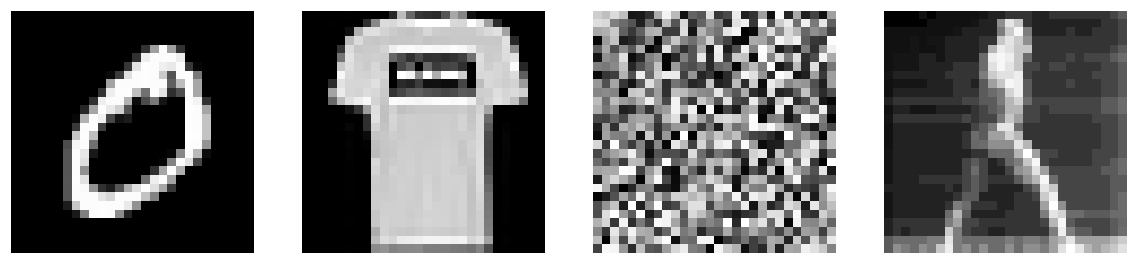

In [4]:
speckle_dim = 112
image_dim = speckle_dim
Use_root    = False
phase_shift = False


file_location = 'Data_1m.h5'
hf = h5py.File( my_path + file_location , 'r')



# Original/input image filenames
orig_img_filenames =  {'digi': 'Training/Original_images/MNIST',
                      'fash': 'Training/Original_images/Fashion-MNIST',
                      'rand': 'Training/Original_images/Random Patterns',
                 'fash_test': 'Testing/Original_images/MNIST',
                 'digi_test': 'Testing/Original_images/Fashion-MNIST',
                      'punc': 'Testing/Original_images/Muybridge Punch'}

orig_imgs = {dataset: None for dataset in orig_img_filenames}


for dataset, filename in orig_img_filenames.items():
    # Load
    fl = hf[filename]
    orig_imgs[dataset] =  np.array(fl)


## TRAIN
y_train = np.concatenate((orig_imgs['digi'],
                          orig_imgs['fash'],
                          orig_imgs['rand'],
                         ))

y_train = np.squeeze(y_train.reshape(-1, 28*28, 1))

## TEST
y_test = np.concatenate((orig_imgs['digi_test'],
                         orig_imgs['fash_test'],))

y_test = np.squeeze(y_test.reshape(-1, 28*28, 1))


## Example of each dataset
rows, cols = 1, len(orig_img_filenames)-2 # exclude test sets
f, ax_arr = plt.subplots(rows, cols, figsize=(20, 10))
ex = 1

i = 1
for name in (name for name in orig_img_filenames if 'test' not in name):
    plt.subplot(rows, cols, i)
    plt.imshow(orig_imgs[name][ex].reshape(28,28))
    axes_off()
    i+=1




# Load and resize all datasets

# Original/input image filenames
speckle_img_filenames =  {'digi': 'Training/Speckle_images/MNIST',
                      'fash': 'Training/Speckle_images/Fashion-MNIST',
                      'rand': 'Training/Speckle_images/Random Patterns',
                 'fash_test': 'Testing/Speckle_images/MNIST',
                 'digi_test': 'Testing/Speckle_images/Fashion-MNIST',
                      'punc': 'Testing/Speckle_images/Muybridge Punch'}

data_dict = {dataset: None for dataset in speckle_img_filenames}


# import speckle images and resize them from 224 to the chosen speckle_dim
for dataset, filename in speckle_img_filenames.items():
    print(f"Loading {dataset} ...")
    # Load
    fl = hf[filename]
    data_dict[dataset] =  np.array(fl)
    # To resize we recover the original image shape
    Data_resize = np.reshape(data_dict[dataset], (data_dict[dataset].shape[0],224,224) )
    Data_temp = np.zeros((data_dict[dataset].shape[0],speckle_dim*speckle_dim))
    # Resize
    for im in range(data_dict[dataset].shape[0]):

        Data_temp[im] = np.reshape(cv2.resize(Data_resize[im], dsize=(speckle_dim, speckle_dim), interpolation=cv2.INTER_AREA), (speckle_dim*speckle_dim))
    
    data_dict[dataset] = Data_temp            
    del Data_temp, Data_resize
    gc.collect()




#TRAIN
x_train = np.concatenate((data_dict['digi'],
                          data_dict['fash'],
                          data_dict['rand'],
                         ))
# TEST
x_test = np.concatenate((data_dict['digi_test'], data_dict['fash_test'],))


x_train_ch = real_to_channels_np(x_train.astype('float32'))
x_test_ch  = real_to_channels_np(x_test.astype('float32'))



hf.close()

In [7]:
#lets use one we trained earlier
inp_4 = Input(shape=(image_dim*image_dim, 2))
lay_4 = ComplexDense(28*28, use_bias=False, kernel_regularizer=regularizers.l2(lamb)
                     #kernel_regularizer=UnitaryReg2(lamb/10.0)
                    )(inp_4)
                     
had_4 = Hadamard2(kernel_constraint = keras.constraints.min_max_norm(min_value=0.01, 
                                                                     max_value=10.0, 
                                                                     rate=1.0, axis=0))(lay_4)
out_4 = Amplitude()(had_4)
#out_ph4 = Phase()(had_4)
mod_4 = Model(inputs=inp_4, outputs=out_4)#, out_ph4])

mod_4.compile(optimizer=SGD(lr=lr), loss='mse', metrics=['mse'])
mod_4.summary()
model = mod_4
model_name = 'comp_l2_reg'
#model_name = 'length_comparison_1_m'
weights_filepath = f'weights/{model_name}.h5'
model.load_weights(weights_filepath)
model_name = 'length_comparison_1_m'
weights_filepath = f'weights/{model_name}.h5'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 12544, 2)          0         
_________________________________________________________________
complex_dense_2 (ComplexDens (None, 784, 2)            19668992  
_________________________________________________________________
hadamard2_1 (Hadamard2)      (None, 784, 2)            784       
_________________________________________________________________
amplitude_1 (Amplitude)      (None, 784)               0         
Total params: 19,669,776
Trainable params: 19,669,776
Non-trainable params: 0
_________________________________________________________________


OSError: Unable to open file (unable to open file: name = 'weights/comp_l2_reg.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
%%time
weights_filepath = f"weights/{model_name}.h5"

# Callbacks
model_chk = ModelCheckpoint(weights_filepath, monitor='mse', 
                            verbose=0, save_best_only=False, 
                            save_weights_only=True, mode='auto',
                            period=1)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=lr/1e3,
                              verbose=1,)

t_b = TensorBoard(log_dir=f'./logs/{model_name}', histogram_freq=0, batch_size=32, 
                  write_graph=True, write_grads=False, write_images=True,
                  embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

# Train
model.fit(x_train_ch, 
          y_train,
          validation_data=(x_test_ch, y_test),
          epochs=epochs,
          batch_size=batch_size,
          callbacks = [model_chk, reduce_lr, t_b],
          shuffle=True,
         )

In [ ]:
def create_and_save_gif(input_data, output_filename, resolution):
    # reshape
    input_data = input_data.reshape(-1, resolution, resolution)
    
    # normalise to 0,255 range
    input_data -= input_data.min()
    input_data *= 255/input_data.max()

    # create and save gif
    imageio.mimsave(output_filename, input_data.astype('uint8'))

vids = ['punc']
spec_res = image_dim

for vid in vids:
    print(f"Preparing {vid} gifs ...")
    name = eval(vid) # Convert to file location
    
    ## ORIG GIF
    orig_vid = orig_imgs[vid]
    orig_fname = f'gifs/orig_{vid}.gif'
    create_and_save_gif(orig_vid, orig_fname, 28)
     

    ## SPECKLE GIF 
    spec_vid = data_dict[name]
    spec_fname = f'gifs/1m_{spec_res}x{spec_res}_{vid}_speckles.gif'
    create_and_save_gif(spec_vid, spec_fname, spec_res)
    
    
    ## PREDICTED GIF
    pred_vid = model.predict(real_to_channels_np(data_dict[name]))
    pred_fname = f'gifs/{vid}_{model_name}.gif'
    create_and_save_gif(pred_vid, pred_fname, 28)
    
    ## GENERATE TRIPTYCHS
    subprocess.call("bash triptych.sh "
                f"{orig_fname} "
                f"{spec_fname} "
                f"{pred_fname} "
                f"{image_dim} "
                f"{spec_res} "
                f"{image_dim} "
                f"triptychs/triptych_{model_name}_{vid}.gif", shell=True)

In [ ]:
trips = [f"triptychs/triptych_{model_name}_{vid}.gif" for vid in vids]
table = '<tr><td><img src="' + '"></td></tr> <tr><td><img src="'.join(trips) + '"></td></tr>'

HTML(f'\
<table style="width:50%;">\
  {table}\
</table>')